# Imports and setup

In [1]:
# Basic
import numpy as np
import scipy
import scipy.stats
import os
import itertools
import warnings
import sys
from copy import deepcopy

# Data Loading
import cmlreaders as cml #Penn Computational Memory Lab's library of data loading functions

# Data Handling
import os
from os import listdir as ld
import os.path as op
from os.path import join, exists as ex
import time
import datetime

# Data Analysis
import pandas as pd
import xarray as xr

# EEG & Signal Processing
import ptsa
from ptsa.data.readers import BaseEventReader, EEGReader, CMLEventReader, TalReader
from ptsa.data.filters import MonopolarToBipolarMapper, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parallelization
import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm as cl
from cluster import wait, get_exceptions_quiet as get_ex
import cmldask

%load_ext autoreload
%autoreload 2


# Custom
from cstat import * #circular statistics
from misc import * #helper functions for loading and saving data, and for other purposes
from matrix_operations import * #matrix operations

USERNAME = get_username_from_working_directory(index=2)
root_dir = f'/scratch/{USERNAME}/retrieval_connectivity2'

# specify hypothesis for end-to-end testing of this analysis pipeline with simulated EEG data
simulation_tag = 'null_connectivity'
is_simulation = simulation_tag not in ['standard', '', None]
from simulate_eeg import AVAILABLE_SIMULATIONS

if is_simulation and (simulation_tag != 'null_connectivity'):
    raise NotImplementedError('need to update simulation to give difference in PPC across conditions!')
    raise NotImplementedError('also keep current sims as higher variance nulls!')

if is_simulation:
    assert simulation_tag in AVAILABLE_SIMULATIONS
    root_dir = os.path.join(root_dir, 'simulation_tests', simulation_tag)

if not os.path.exists(root_dir):
    os.makedirs(root_dir)

import helper
from helper import *
helper.root_dir = root_dir

from functools import partial
cluster_log_dir = 'cluster'
cl = partial(cl, log_directory=cluster_log_dir)
if not os.path.exists(cluster_log_dir):
    os.mkdir(cluster_log_dir)

font_dirs = ['fonts']


/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ptsa/data/readers/__init__.py:19: FutureWarning: PTSA readers will be removed in a future release. Please consider using the cmlreaders package instead: https://github.com/pennmem/cmlreaders
  FutureWarning


In [2]:
import shutil
for f1 in ['en', 'en_all', 'rm', 'ri']:
#     path = join(root_dir, f1)
#     if ex(path): shutil.rmtree(path)
#     for f2 in ['events', 'elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
    # for f2 in ['elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
    for f2 in ['elpomxs', 'regpomxs']:
        path = join(root_dir, f1, f2)
        if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'data_check')
# if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'behavioral_stats')
# if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'electrode_information')
# if ex(path): shutil.rmtree(path)

In [3]:
for f1 in ['en', 'en_all', 'rm', 'ri']:
    path = join(root_dir, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['eeg', 'events', 'elsymxs', 'regsymxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
    for f2 in ['elpomxs', 'regpomxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
        for f3 in ['theta', 'gamma']:
            path = join(root_dir, f1, f2, f3)
            if not ex(path): os.mkdir(path)
path = join(root_dir, 'data_check')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'behavioral_stats')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'electrode_information')
if not ex(path): 
    os.mkdir(path)
    os.mkdir(join(path, 'pairs'))
    os.mkdir(join(path, 'localization'))

# Create dataset

## Initialize dataset

"ethan_subject_list," etc. refers to the subject list used by Ethan A. Solomon in his 2017 Nature Communications paper, "Widespread theta synchrony underlies enhanced cognition," and it was taken from the publicly available code for that paper.

The initial dataset was created by checking the CMLReaders data index for all pyFR, catFR1, and FR1 sessions (all delayed free recall sessions collected by the Penn Computational Memory Lab). Just in case, the presumed session list (see code) that Ethan Solomon used for his 2017 paper was appended as well.

The sessions were then checked to ensure that all necessary data, including the behavioral events, EEG data, and electrode contact locations, were available and unproblematic.

In [4]:
ethan_subject_list = [['R1031M', 'FR1'],['R1033D', 'FR1'],['R1042M', 'FR1'],['R1044J', 'FR1'],['R1039M', 'FR1'],['R1048E', 'FR1'],['R1035M', 'FR1'],['R1030J', 'FR1'],['R1050M', 'FR1'],['R1053M', 'FR1'],['R1036M', 'FR1'],['R1018P', 'FR1'],['R1020J', 'FR1'],['R1026D', 'FR1'],['R1032D', 'FR1'],['R1056M', 'FR1'],['R1002P', 'FR1'],['R1027J', 'FR1'],['R1045E', 'FR1'],['R1057E', 'FR1'],['R1063C', 'FR1'],['R1001P', 'FR1'],['R1003P', 'FR1'],['R1015J', 'FR1'],['R1049J', 'FR1'],['R1022J', 'FR1'],['R1074M', 'FR1'],['R1069M', 'FR1'],['R1076D', 'FR1'],['R1102P', 'FR1'],['R1023J', 'FR1'],['R1155D', 'FR1'],['R1162N', 'FR1'],['R1086M', 'FR1'],['R1149N', 'FR1'],['R1034D', 'FR1'],['R1051J', 'FR1'],['R1159P', 'FR1'],['R1101T', 'FR1'],['R1178P', 'FR1'],['R1104D', 'FR1'],['R1089P', 'FR1'],['R1105E', 'FR1'],['R1060M', 'FR1'],['R1186P', 'FR1'],['R1112M', 'FR1'],['R1202M', 'FR1'],['R1066P', 'FR1'],['R1084T', 'FR1'],['R1096E', 'FR1'],['R1176M', 'FR1'],['R1187P', 'FR1'],['R1169P', 'FR1'],['R1081J', 'FR1'],['R1006P', 'FR1'],['R1164E', 'FR1'],['R1196N', 'FR1'],['R1127P', 'FR1'],['R1010J', 'FR1'],['R1175N', 'FR1'],['R1148P', 'FR1'],['R1203T', 'FR1'],['R1193T', 'FR1'],['R1167M', 'FR1'],['R1075J', 'FR1'],['R1177M', 'FR1'],['R1080E', 'FR1'],['R1161E', 'FR1'],['R1068J', 'FR1'],['R1054J', 'FR1'],['R1195E', 'FR1'],['R1189M', 'FR1'],['R1131M', 'FR1'],['R1200T', 'FR1'],['R1100D', 'FR1'],['R1142N', 'FR1'],['R1114C', 'FR1'],['R1247P', 'FR1'],['R1128E', 'FR1'],['R1138T', 'FR1'],['R1059J', 'FR1'],['R1067P', 'FR1'],['R1215M', 'FR1'],['R1111M', 'FR1'],['R1171M', 'FR1'],['R1106M', 'FR1'],['R1129D', 'FR1'],['R1146E', 'FR1'],['R1098D', 'FR1'],['R1130M', 'FR1'],['R1115T', 'FR1'],['R1150J', 'FR1'],['R1173J', 'FR1'],['R1154D', 'FR1'],['R1136N', 'FR1'],['R1137E', 'FR1'],['R1204T', 'FR1'],['R1174T', 'FR1'],['R1230J', 'FR1'],['R1122E', 'FR1'],['R1229M', 'FR1'],['R1158T', 'FR1'],['R1163T', 'FR1'],['R1250N', 'FR1'],['R1147P', 'FR1'],['R1166D', 'FR1'],['R1241J', 'FR1'],['R1123C', 'FR1'],['R1120E', 'FR1'],['R1083J', 'FR1'],['R1113T', 'FR1'],['R1226D', 'FR1'],['R1228M', 'FR1'],['R1062J', 'FR1'],['R1232N', 'FR1'],['R1217T', 'FR1'],['R1151E', 'FR1'],['R1070T', 'FR1'],['R1121M', 'FR1'],['R1222M', 'FR1'],['R1168T', 'FR1'],['R1172E', 'FR1'],['R1223E', 'FR1'],['R1134T', 'FR1'],['R1077T', 'FR1'],['R1094T', 'FR1'],['R1260D', 'FR1'],['R1061T', 'FR1'],['R1243T', 'FR1'],['R1191J', 'FR1'],['R1240T', 'FR1'],['R1231M', 'FR1'],['R1234D', 'FR1'],['R1135E', 'FR1'],['R1004D', 'catFR1'],['R1065J', 'FR1'],['R1236J', 'FR1'],['R1016M', 'catFR1'],['R1021D', 'catFR1'],['R1028M', 'catFR1'],['R1041M', 'catFR1'],['R1029W', 'catFR1'],['R1119P', 'catFR1'],['R1107J', 'catFR1'],['R1141T', 'catFR1'],['R1144E', 'catFR1'],['R1188C', 'catFR1'],['R1180C', 'catFR1'],['R1157C', 'catFR1'],['R1181E', 'catFR1'],['R1190P', 'catFR1'],['R1227T', 'catFR1'],['R1192C', 'catFR1'],['R1221P', 'catFR1'],['R1239E', 'catFR1'],['R1273D', 'catFR1'],['TJ017', 'pyFR'],['TJ018_2', 'pyFR'],['TJ018', 'pyFR'],['TJ019', 'pyFR'],['TJ021', 'pyFR'],['TJ020', 'pyFR'],['TJ024', 'pyFR'],['TJ027', 'pyFR'],['TJ022', 'pyFR'],['TJ028', 'pyFR'],['TJ029', 'pyFR'],['TJ033', 'pyFR'],['TJ030', 'pyFR'],['TJ031', 'pyFR'],['TJ025', 'pyFR'],['TJ032', 'pyFR'],['TJ036', 'pyFR'],['TJ034', 'pyFR'],['TJ037', 'pyFR'],['TJ035_1', 'pyFR'],['TJ038_1', 'pyFR'],['TJ038', 'pyFR'],['TJ040_1', 'pyFR'],['TJ040', 'pyFR'],['TJ042', 'pyFR'],['TJ041', 'pyFR'],['TJ043', 'pyFR'],['TJ041_2', 'pyFR'],['TJ039', 'pyFR'],['TJ044', 'pyFR'],['TJ045', 'pyFR'],['TJ047', 'pyFR'],['TJ048', 'pyFR'],['TJ049', 'pyFR'],['TJ052', 'pyFR'],['TJ053_2', 'pyFR'],['TJ053_3', 'pyFR'],['TJ055', 'pyFR'],['TJ054', 'pyFR'],['TJ056', 'pyFR'],['TJ058', 'pyFR'],['TJ057', 'pyFR'],['TJ059', 'pyFR'],['TJ061', 'pyFR'],['TJ064', 'pyFR'],['TJ062_2', 'pyFR'],['TJ060', 'pyFR'],['TJ065', 'pyFR'],['TJ064_1', 'pyFR'],['TJ066', 'pyFR'],['TJ068', 'pyFR'],['TJ069_1', 'pyFR'],['TJ069', 'pyFR'],['TJ071', 'pyFR'],['TJ072', 'pyFR'],['TJ074_1', 'pyFR'],['TJ073', 'pyFR'],['TJ074', 'pyFR'],['TJ077', 'pyFR'],['TJ078_1', 'pyFR'],['TJ078', 'pyFR'],['TJ081', 'pyFR'],['TJ079', 'pyFR'],['TJ080', 'pyFR'],['UP016', 'pyFR'],['UP017', 'pyFR'],['UP019', 'pyFR'],['UP020', 'pyFR'],['UP022', 'pyFR'],['UP021', 'pyFR'],['UP028', 'pyFR'],['UP024', 'pyFR'],['UP029', 'pyFR'],['UP034', 'pyFR'],['UP036', 'pyFR'],['UP038', 'pyFR'],['UP037', 'pyFR'],['UP042', 'pyFR'],['UP041', 'pyFR'],['UP040', 'pyFR'],['UP044_1', 'pyFR'],['UP043', 'pyFR'],['UP044', 'pyFR'],['UP045', 'pyFR'],['R1153T', 'FR1'],['R1156D', 'FR1'],['R1207J', 'FR1'],['TJ051', 'pyFR'],['R1052E_1', 'FR1'],['R1052E_2', 'FR1'],['R1055J', 'FR1'],['R1059J_1', 'FR1'],['R1063C_1', 'FR1'],['R1066P_1', 'FR1'],['R1083J_1', 'FR1'],['R1092J_2', 'FR1'],['R1108J_1', 'FR1'],['R1118N_1', 'FR1'],['R1124J_1', 'FR1'],['R1127P_1', 'FR1'],['R1145J_1', 'FR1'],['TJ086', 'FR1'],['UT009', 'FR1'],['R1170J_1', 'FR1'],['R1171M_1', 'FR1'],['R1092J_3', 'FR1'],['R1185N_1', 'FR1'],['R1201P_1', 'FR1'],['R1216E_1', 'FR1'],['R1291M', 'FR1'],['R1093J', 'catFR1'],['R1013E_1', 'catFR1'],['R1024E_1', 'catFR1'],['R1092J', 'catFR1'],['R1108J', 'catFR1'],['R1127P_2', 'catFR1'],['R1135E_1', 'catFR1'],['R1138T_1', 'catFR1'],['TJ084', 'catFR1'],['R1191J_1', 'catFR1'],['R1247P_1', 'catFR1'],['R1269E_1', 'catFR1'],['R1278E_1', 'catFR1'],['FR150', 'pyFR'],['FR160', 'pyFR'],['FR190', 'pyFR'],['FR220', 'pyFR'],['FR230', 'pyFR']]
ethan_subject_list = np.asarray(ethan_subject_list)
print(f'{len(np.unique(ethan_subject_list[:, 0]))} subjects in Ethan Solomon\'s dataset.')

284 subjects in Ethan Solomon's dataset.


In [5]:
ethan_sess_list = []
data_index = cml.get_data_index()
for subexp in ethan_subject_list:
    sub, exp = subexp
    sess_list = data_index.query('subject == @sub & experiment == @exp')[['session', 'localization', 'montage']].to_numpy()
    for r in sess_list:
        sess, loc, mon = r
        sess, loc, mon = int(sess), int(loc), int(mon)
        row = np.asarray([sub, exp, sess, loc, mon], dtype='object')
        ethan_sess_list.append(row)
ethan_sess_list = np.asarray(ethan_sess_list)
ethan_sess_list = pd.DataFrame(ethan_sess_list, columns=['subject', 'experiment', 'session', 'localization', 'montage'])

In [6]:
data_index = cml.get_data_index()
cmlreaders_sess_list = data_index.query('experiment in ["pyFR", "catFR1", "FR1"]')[['subject', 'experiment', 'session', 'localization', 'montage']]

In [7]:
sess_list_df = pd.concat([cmlreaders_sess_list, ethan_sess_list], axis=0).drop_duplicates(ignore_index=True)
sess_list_df = sess_list_df.rename({'subject': 'sub', 'experiment': 'exp', 'session': 'sess', 'localization': 'loc', 'montage': 'mon'}, axis=1)
sess_list_df.to_csv(join(root_dir, 'sess_list_df_initial.csv'), index=False)

## Check data availability

See here for more details about the electrode localization procedures used to assign region labels and coordinates to the analyzed contacts: https://github.com/pennmem/neurorad_pipeline/blob/master/RELEASE_NOTES.md.

In [8]:
def check_pairs(dfrow):
    
    def get_mat_pairs(sub, mon_):

        tal_path=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'
        df = load_mat(tal_path)
        k = 'bpTalStruct' if 'bpTalStruct' in df.keys() else 'subjTalEvents'
        df = pd.DataFrame(df[k][0])
        df.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
        channel_info=np.asarray([[df['channel'][i][0][0],df['channel'][i][0][1],df['tagName'][i][0],str(df['Loc1'][i][0]),str(df['Loc2'][i][0]),str(df['Loc3'][i][0]),str(df['Loc4'][i][0]),str(df['Loc5'][i][0]),df['x'][i][0][0],df['y'][i][0][0],df['z'][i][0][0],df['distance'][i][0][0]] for i in range(len(df))])
        pairs=pd.DataFrame(channel_info, columns = ['contact_1','contact_2','label','Loc1','Loc2','Loc3','Loc4','Loc5','x','y','z','distance'])
        pairs[['x', 'y', 'z', 'distance']] = pairs[['x', 'y', 'z', 'distance']].astype(float)

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if surf_col in df.columns: 
                reg_col_values = [str(df[surf_col][i]['anatRegion'][0][0][0]) if len(df[surf_col][i]['anatRegion'][0][0]) > 0 else 'nan' for i in range(len(df))]
                if not np.all(np.isin(np.char.lower(reg_col_values), ['nan', 'none', 'unknown'])):
                    pairs[reg_col] = reg_col_values

        assert np.any(np.isin(['mat.avg.region', 'mat.ind.region'], pairs.columns)), f'{surf_col} information not available'

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if reg_col not in df.columns: continue
            for reg_corr_col_, surf_corr_col, in zip(['.corrected.region', '.snap.region', '.dural.region'], ['anatRegion_Dykstra', 'anatRegion_dural', 'anatRegion_snap']):
                if surf_corr_col not in df[surf_col][0].dtype.names: continue
                reg_corr_col = reg_corr_col_.replace('.region', col)
                pairs[reg_corr_col] = [str(df[surf_col][i][surf_corr_col][0][0][0]) if len(df[surf_col][i][surf_corr_col][0][0]) > 0 else 'nan' for i in range(len(df))]

        def get_hemisphere(pair):

            if 'left' in pair['Loc2'].lower(): return 'L'
            if 'right' in pair['Loc2'].lower(): return 'R'

            if str(pair['x']) == 'nan': return 'nan'
            elif pair['x'] < 0: return 'L'
            elif pair['x'] > 0: return 'R'

            return 'nan'

        pairs['hemisphere'] = pairs.apply(lambda x: get_hemisphere(x), axis=1)
        pairs[['contact_1', 'contact_2']] = pairs[['contact_1', 'contact_2']].astype(int)

        def get_tal_region(r):
            
            Loc3_to_Loc5_dict = {'Parahippocampal Gyrus': ['Hippocampus', 'Amygdala'],
                                 'Uncus': ['Amygdala'],
                                 'Lentiform Nucleus': ['Lateral Globus Pallidus', 'Putamen', 'Medial Globus Pallidus']}

            return (r['Loc3'] + ' ' + r['Loc5']) if r['Loc5'] in Loc3_to_Loc5_dict.get(r['Loc3'], []) else r['Loc3']

        pairs['mat.tal.region'] = pairs.apply(lambda r: get_tal_region(r), axis=1)

        return pairs
    
    try:
        sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
        mon_ = '' if mon==0 else f'_{mon}'
        reader = cml.CMLReader(subject=sub, 
                               experiment=exp, 
                               session=sess,
                               localization=loc,
                               montage=mon)
        atlas = np.nan
        contacts_source = np.nan
        try: 
            pairs = reader.load('pairs')
            if 'type_1' in pairs.columns: pairs = pairs[~(pairs['type_1'] == 'uD')].reset_index() #throw out any microwire channels
            
            pairs.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
            
            if 'distance' not in pairs.columns:
                
                def get_contact_label(label):
                    split_label = label.split('-')
                    if len(split_label) == 2: return split_label
                    split_idx = int(np.median(np.where(np.asarray([*label]) == '-')))
                    return [label[:split_idx], label[(split_idx+1):]]
                
                atlas = 'avg' if (np.all(np.isin(['avg.x', 'avg.y', 'avg.z'], pairs.columns))) and (pd.isna(pairs[['avg.x', 'avg.y', 'avg.z']]).values.sum() == 0) else 'tal'
                atlas_coordinates = ['avg.x', 'avg.y', 'avg.z']
                pairs[['contact_label_1', 'contact_label_2']] = pairs.apply(lambda pair: get_contact_label(pair['label']), result_type='expand', axis=1)
                
                def load_localization_contacts(reader):
                    
                    contacts = reader.load('localization').loc['contacts']
                    for iCol, col in enumerate(['avg.x', 'avg.y', 'avg.z']): contacts[col] = [x[0] for x in contacts['coordinate_spaces.fsaverage.raw'].values]
                    return contacts
                
                if tuple(dfrow) in [('R1373T', 'FR1', 0, 0, 0), ('R1478T', 'catFR1', 0, 0, 0), ('R1490T', 'catFR1', 0, 0, 0)]: #these three sessions don't have contacts.json available
                    contacts = load_localization_contacts(reader)
                    contacts_source = 'localization'
                else:
                    contacts = reader.load('contacts').set_index('label')
                    contacts_source = 'contacts'
                    if len(contacts.index) < len(np.unique(pairs[['contact_label_1', 'contact_label_2']].values.ravel())):
                        contacts = load_localization_contacts(reader)
                        contacts_source = 'localization'

                pairs['distance'] = pairs.apply(lambda pair: np.sqrt(np.sum((contacts.loc[pair[f'contact_label_2'], atlas_coordinates].values.astype(float) - contacts.loc[pair[f'contact_label_1'], atlas_coordinates].values.astype(float))**2)), axis=1)
        
            if ex(f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'):
                mat_pairs = get_mat_pairs(sub, mon_)
                mat_pairs_available = True
                mat_pairs.set_index('label', inplace=True)
                pairs['tal.region'] = mat_pairs['mat.tal.region']
                for col in ['Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'mat.ind.corrected.region', 'mat.ind.snap.region', 'mat.ind.dural.region', 'mat.ind.region', 'mat.avg.corrected.region', 'mat.avg.snap.region', 'mat.avg.dural.region', 'mat.avg.region', 'mat.tal.region']:
                    if (col not in pairs.columns) and (col in mat_pairs.columns): 
                        pairs[col] = np.nan
                        for i in range(len(pairs)):
                            label = pairs.loc[i, 'label']
                            if label in mat_pairs.index.values: 
                                pairs.loc[i, col] = mat_pairs.loc[label, col]
            else:
                mat_pairs_available = False
            pairs_data_source = 'cmlreaders'
            try: 
                localization = reader.load('localization')
                assert np.any(np.isin(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'], localization))
            except: 
                localization = []
                assert np.any(np.isin(['stein.region', 'das.region', 'wb.region', 'dk.region', 'ind.corrected.region', 'ind.snap.region', 'ind.dural.region', 'ind.region', 'avg.corrected.region', 'avg.snap.region', 'avg.dural.region', 'avg.region', 'mni.region'], pairs.columns))
        except Exception as e:
            print(e)
            pairs = get_mat_pairs(sub, mon_)
            mat_pairs_available = True
            pairs_data_source = 'mat'
            localization = []
    
        distance_threshold = 20
        assert pd.isna(pairs['distance']).sum() == 0, 'missing distance values for pairs'
        long_distance_pairs_count = len(pairs.query('distance > @distance_threshold'))
        pairs = pairs.query('distance <= @distance_threshold')
        
        return pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, True
    except Exception as e:
        print(e)
        return None, None, np.nan, np.nan, np.nan, np.nan, np.nan, False

In [9]:
def check_regionalizations(pairs, localization):
    
    try:
        regionalizations = regionalize_electrodes(pairs, localization)
        return regionalizations, True
    except:
        return None, False
        

In [10]:
def check_eeg(dfrow, pairs, start=-1500, end=1500):
    
    import traceback
    
    data_check = pd.Series({})
    global errors
    errors = []
    
    def check_eegoffset_monotonicity(events):
        
        return np.all(events.groupby('eegfile')['eegoffset'].diff().fillna(0) >= -10)
    
    def check_mstime_eegoffset_match(events):

        events = events.query('type in ["WORD", "REC_WORD", "REC_WORD_VV"]')[['eegfile', 'mstime', 'rectime', 'eegoffset']].reset_index()
        events['mstime_diff'] = events['mstime'].diff()/1000
        events['eegoffset_time_diff'] = events['eegoffset'].diff()/sr
        eegfiles = events.eegfile.values
        eegfile_change_idxs = np.asarray([i for i, x in enumerate(eegfiles) if eegfiles[i] != eegfiles[i-1]])
        if len(eegfile_change_idxs) > 0:                                  
            events.at[eegfile_change_idxs, ['mstime_diff', 'eegoffset_time_diff']] = np.nan

        mean_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).mean()
        median_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).median()
        if (0.99 <= mean_mstime_eegoffset_ratio <= 1.01) and (0.99 <= median_mstime_eegoffset_ratio <= 1.01):
            mstime_eegoffset_match = True
        else:
            mstime_eegoffset_match = False
        return mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match
    
    try:
        #Load EEG
        try: 
            sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
            reader = cml.CMLReader(subject=sub, 
                                   experiment=exp, 
                                   session=sess,
                                   localization=loc,
                                   montage=mon)
            events = reader.load('events')
            empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]')['eegfile'])))
            try: 
                assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            en_events = events.query('type == "WORD" & eegfile != ""').iloc[0:1]
            eeg = reader.load_eeg(en_events, start, end, scheme=pairs)
            sr = float(eeg.samplerate)
            evs_data_source = eeg_data_source = 'cmlreaders'
            no_channels = eeg.shape[1]
            eeg = eeg.to_ptsa()
            
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
            
        except: 
            
            evs_data_source, eeg_data_source, sr, no_channels, eeg, events = check_ptsa_eeg(dfrow, start, end)
            events = pd.DataFrame.from_records(events)
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
        
        eeg = eeg.resampled(250)
        
        dim_map = {}
        if 'events' in eeg.dims: dim_map['events'] = 'event'
        if 'channels' in eeg.dims: dim_map['channels'] = 'channel'
        eeg = eeg.rename(dim_map)
        eeg = eeg.transpose('event', 'channel', 'time')

        data_check['eeg_error'] = np.nan
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'no_channels']:
            data_check[var] = locals()[var]

        return eeg, True, data_check
    
    except Exception as e:
        errors.append(e)
        data_check['eeg_error'] = globals()['errors']
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'no_channels']:
            data_check[var] = np.nan
        return None, False, data_check
    
def check_ptsa_eeg(dfrow, start, end):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    exp_dict = {'FR1': 'RAM_FR1', 'catFR1': 'RAM_CatFR1', 'pyFR': 'pyFR'}
    exp = exp_dict[exp] #for tal_reader path name
    mon_ = '' if mon==0 else f'_{mon}' #for tal_reader path name
        
    def load_ptsa_eeg(events):        
        
        en_events = events[(events.session==sess) & (events.type=='WORD') & (events.eegfile!='')][0:1]

        tal_reader = TalReader(filename=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat')
        channels = tal_reader.get_monopolar_channels()
        eeg = EEGReader(events=en_events, channels=channels,
                    start_time=start/1000, end_time=end/1000).read()
 
        bipolar_pairs = tal_reader.get_bipolar_pairs()
        mapper= MonopolarToBipolarMapper(bipolar_pairs=bipolar_pairs)
        eeg = mapper.filter(timeseries=eeg)
        eeg = eeg.transpose('events', 'channels', 'time')
        
        return eeg
    
    try:
        events = BaseEventReader(filename=f'/data/events/{exp}/{sub}{mon_}_events.mat', use_reref_eeg=False).read()
        empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])))
        try: 
            assert not empty_eegfile, 'ptsa events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'ptsa'
        eeg_data_source = 'ptsa'
    except Exception as e:
        print(e)
        globals()['errors'].append(e)
        reader = cml.CMLReader(subject=sub, 
                       experiment=exp, 
                       session=sess,
                       localization=loc,
                       montage=mon)
        events = reader.load('events')
        events = events.to_records()
        empty_eegfile = '' in np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])
        try: 
            assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'cmlreaders'
        eeg_data_source = 'ptsa'
    
    sr = float(eeg.samplerate)
    no_channels = eeg.shape[1]
    events = events[np.isin(events.type, ['WORD', 'REC_WORD', 'REC_WORD_VV'])]

    return evs_data_source, eeg_data_source, sr, no_channels, eeg, events
        
def check_phase(eeg):
    
    try:
        freqs = [3]
        phase = get_phase(eeg, freqs)
        sr = float(phase.samplerate)
        timebinned_phase = timebin_phase_timeseries(phase.data, sr)
        return phase, True
    except:
        return None, False

In [11]:
def check_data(dfrow):
    
    data_check = pd.Series({})
    for k in ['pairs', 'regionalizations', 'eeg', 'phase']: data_check[k] = False
        
    pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, data_check['pairs'] = check_pairs(dfrow)
    if not data_check['pairs']: return data_check
    data_check['pairs_data_source'] = pairs_data_source
    data_check['mat_pairs_available'] = mat_pairs_available
    data_check['pairs_count'] = len(pairs)
    data_check['long_distance_pairs_count'] = long_distance_pairs_count
    data_check['atlas'] = atlas
    data_check['contacts_source'] = contacts_source
    data_check['localization'] = len(localization) > 0
    pairs.reset_index(drop=True).to_json(join(root_dir, 'electrode_information', 'pairs', f'{ftag(dfrow)}_pairs.json'))
    if data_check['localization']: localization.reset_index().to_json(join(root_dir, 'electrode_information', 'localization', f'{ftag(dfrow)}_localization.json'))
        
    eeg, data_check['eeg'], eeg_data_check = check_eeg(dfrow, pairs)
    
    for k in eeg_data_check.keys(): 
        data_check[k] = eeg_data_check[k]

    if not data_check['eeg']: return data_check

    phase, data_check['phase'] = check_phase(eeg)
    
    regionalizations, data_check['regionalizations'] = check_regionalizations(pairs, localization)
    if not data_check['regionalizations']: return data_check
    data_check['regionalizations_count'] = len(regionalizations)
    data_check['nonempty_regionalizations_count'] = len([r for r in regionalizations if r != 'nan'])
    
    return data_check

In [12]:
def run_check_data(dfrow):
    
    dfrow = get_dfrow(dfrow)
    data_check = check_data(dfrow)
    
    data_check.to_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'))

In [13]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('check_data', '20G', int(4000/20), walltime=10000)
futures = client.map(run_check_data, sess_list)
wait(futures, client, check_delay=30)


Simulations finished after 94.6 s: 1592 / 1592 (16.8 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [14]:
len(ld(join(root_dir, 'data_check')))

1592

In [15]:
client.shutdown()

In [16]:
def load_data_check(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'), typ='series')
    return data_check

In [17]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

sess_list_df_data_check = sess_list_df.apply(lambda r: load_data_check(r), axis=1)
sess_list_df[sess_list_df_data_check.columns] = sess_list_df_data_check
sess_list_df['sr_present'] = ~pd.isna(sess_list_df['sr'])
# sess_list_df['pairs_regionalizations_match'] = sess_list_df['pairs_count'] == sess_list_df['regionalizations_count']

In [18]:
sess_list_df['include'] = True
sess_list_df.loc[sess_list_df.eval('sr_present == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('sr < 249'), 'include'] = False
# sess_list_df.loc[sess_list_df.eval('pairs_regionalizations_match == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('phase == False'), 'include'] = False

In [19]:
for r in [('R1093J', 'FR1', 0, 0, 1),
          ('R1331T', 'FR1', 0, 0, 0),
          ('CH042', 'pyFR', 2, 0, 0),
          ('R1277J', 'FR1', 0, 0, 1),
          ('FR140', 'pyFR', 1, 0, 0),
          ('FR160', 'pyFR', 1, 0, 0),
          ('FR280', 'pyFR', 0, 0, 0),
          ('UP001', 'pyFR', 3, 0, 0),
          ('R1216E', 'FR1', 0, 0, 1),
          ('R1216E', 'FR1', 1, 0, 1),
          ('R1235E', 'catFR1', 0, 0, 0)]:
    if r in sess_list_df.index:
        sess_list_df.at[r, 'include'] = False

The following are additional drops. These drops were made either because the sessions' behavioral and EEG data were duplicates of another (R1275D, R1310J, R1486J), or because there were two sessions that had duplicate behavioral events but had different EEG signal, meaning both sessions had to be thrown out (R1100D, R1408N).

In [20]:
for r in [('R1100D', 'FR1', 0, 0, 0),
          ('R1100D', 'FR1', 1, 0, 0),
          ('R1408N', 'catFR1', 0, 0, 0),
          ('R1408N', 'catFR1', 1, 0, 0),
          ('R1275D', 'FR1', 3, 0, 0),
          ('R1310J', 'catFR1', 1, 0, 0),
          ('R1486J', 'catFR1', 4, 0, 1),
          ('R1486J', 'catFR1', 5, 0, 1),
          ('R1486J', 'catFR1', 6, 0, 1),
          ('R1486J', 'catFR1', 7, 0, 1)]:
    if r in sess_list_df.index:
        sess_list_df.at[r, 'include'] = False

In [21]:
passed_sessions_count = len(sess_list_df.query('include==True'))
print(f'{passed_sessions_count} sessions passed the initial data check.')

1407 sessions passed the initial data check.


In [22]:
sess_list_df.to_json(join(root_dir, 'sess_list_df_data_check.json'))

Explanation of session exclusions:

[R1093J, FR1, 0, 0, 1] was excluded. The session notes (/data10/RAM/subjects/R1093J_1/docs/readme.txt) said: 'BAD SESSION- could not be processed due to laptop reset. No recall for list 10. PC disconnected during list 11 math, restarted. Alert over hospital PA system at 14:36.' On Asana, the last comment on a task for fixing this session was: Logan O'Sullivan · Mar 16, 2016: 'Could not be processed.' (https://app.asana.com/0/9094005070980/64243709084297/f) 

[R1331T, FR1, 0, 0, 0] was excluded. Study events for trials 1 through 6 are duplicated. There were 15 trials. Threw out session out of suspicion that the event logging is incorrect.  Nothing informative in session notes (/data10/RAM/subjects/R1331T/docs/readme.txt), just:

'start:16:42
stop:17:04

Notes: 17:03 computer died'

[CH042, pyFR, 2, 0, 0] was excluded. The session notes said of the EEG file: 'This file was cut off.  It appears that someone must have started a new montage during testing and
 the synchpulse was lost.  I have sent over the section of the file that had our channel.  If you need me to resend the entire file, so you can see it, please let me know.'

[R1277J, FR1, 0, 0, 1] was excluded because EEG data could not be loaded for many (encoding) events.

[FR140, pyFR, 1, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[FR160, pyFR, 1, 0, 0] was excluded because EEG data could not be loaded for many (encoding) events.

[FR280, pyFR, 0, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[UP001, pyFR, 3, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[R1216E, FR1, 0, 0, 1] was excluded because the loaded pairs file was missing almost half of the bipolar electrodes in comparison with the loaded EEG, and had a different re-referencing scheme, suggesting a problem with the data.

[R1216E, FR1, 0, 0, 1] was excluded because of the issue explained just above.

[R1235E, catFR1, 0, 0, 0] was excluded because certain events could not be loaded. These events were specified according to the eegoffset in the error message printed to screen when attempting to load EEG from the encoding events. These eegoffset values did not correspond to any particular events and smaller and greater eegoffset values were among the events. When loading the EEG, a handful of events were missing from the EEG. For convenience the session was discarded without further investigation of the issue.

The following sessions were problematic, and the events structures have been modified accordingly in match_events.py.

[R1171M, FR1, 2, 0, 0]. The Trial 1 events seem weird, so the trial was thrown out because of the suspicion that the event logging is incorrect. Session notes (/data10/RAM/subjects/R1171M/docs/readme.txt): 'Alert and attentive. Patient was fidgety throughout session. List #2 - no recalls. Phone call during list #15 encoding (throw out).

[R1329T, FR1, 0, 0, 0]. Trial 4 study events duplicated, so threw out trial 4. Session notes (/data10/RAM/subjects/R1329T/docs/readme.txt): '@ 15:56 - list 4  - program shut down and break for pain medication
16:02 - start back up
Ended early after 8 lists.'

[R1341T, FR1, 1, 0, 0]. Trial 8 study events duplicated, so threw out tiral 8. Session notes (/data10/RAM/subjects/R1341T/docs/readme.txt): '15:08 - before list 8 - bathroom break - list started
15:30 - Continue test.'

[R1374T, FR1, 0, 0, 0]. Nothing informative in session notes (/data10/RAM/subjects/R1374T/docs/readme.txt). Trial 1 has 19 study events instead of 12 like the other trials, so trial 1 was thrown out.

[R1488T, catFR1, 0, 0, 0]. Trial 11 had 22 study events instead of 12 like the other trials, so trial 11 was thrown out. Session notes on REDCap (Test Day 1, 07-05-2019): 
'Parents whispering in corner of room. Says words outlaid during encoding list. Some conversation with experiments during testing. Some confusion over which list of words remember at beginning. Mom out of room at ~11:15 quietly. Return at ~11:19 quietly. Performance down as lists went on. Stop at 11:27, list 10 bc parents wanted to leave, Dad left as did mother. Restart at 11:30 at list 11'

[TJ040, pyFR, 0, 0, 1]. Session notes (/data7/eeg/TJ040_1/docs/readme.txt): 'This session of pyFR had a long break in between, as well as a session of trackball (the following 
one).' Presumably this break was at trial 6, because the first two study events (SINK and PANTS) are duplicated, with intervening E, B, SESS_START, TRIAL, ORIENT events. Threw out trial 6.

[FR060, pyFR, 1, 0, 0]. Trial 1 only has 19 study events (item 12 is just skipped). Trial 1 was thrown out in case there was an event logging error. Nothing in session notes (/data1/eeg/freiburg/group0/FR060/docs/readme.txt).

## Get behavioral events
Note: this subsection must be run using the `workshop_311` environment while the rest of the notebook must be run with the `workshop` environment. First run the cells above this subsection in the `workshop` environment. Then restart the kernel with the `workshop_311` environment, run the first cell containing the project imports, and run this subsection. After executing this subsection, restart the kernel in the `workshop` environment and continue running the analyses below this section (again, after running the first cell of imports).

In [2]:
import shutil
for f1 in ['en', 'en_all', 'rm', 'ri']:
    for f2 in ['events']:
        path = join(root_dir, f1, f2)
        if ex(path): 
            shutil.rmtree(path)
            os.mkdir(path)
path = join(root_dir, 'behavioral_stats')
shutil.rmtree(path)
os.mkdir(path)

In [3]:
def fix_event_cols(events):
    
    for x in ['answer', 'exp_version', 'intrusion', 'is_stim', 'iscorrect', 'item_num', 'msoffset', 'recalled', 'stim_list', 'stim_params', 'test']:
        if x in events.columns: events = events.drop(x, axis=1)
    for x in ['session', 'list', 'eegoffset', 'mstime', 'montage']:
        events[x] = events[x].astype(int)
        
    return events

In [4]:
def get_events(dfrow):
    
    np.random.seed(202406)
    
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    sr = get_sr(dfrow)
    sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
    sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
    evs_data_source = sess_list_df.loc[tuple(dfrow), 'evs_data_source']

    beh_to_proximity_buffer = {'en': 1, 'rm': 5000, 'ri': 5000}
    beh_to_event_count_threshold = {'en': 10, 'rm': 10, 'ri': 10}
    # beh_to_event_count_threshold = {'en': 6, 'rm': 6, 'ri': 6}
    
    import match_events as match_events
    matcher = match_events.MatchedEvents(dfrow, sr, evs_data_source)
    
    for beh in ['en', 'rm', 'ri']:
        
        proximity_buffer = beh_to_proximity_buffer[beh]
        event_count_threshold = beh_to_event_count_threshold[beh]
        matched_events = matcher.match_events(beh, proximity_buffer, event_count_threshold,
                                              rec_window=[-1000, 0], post_rec_distance=1000, pre_rec_distance=1000)
        mask = matcher.mask[beh]
        status = pd.Series(matcher.status[beh])
        metadata = pd.Series({'beh': beh,
                              'sr': sr,
                              'mask': mask,
                              'proximity_buffer': proximity_buffer,
                              'event_count_threshold': event_count_threshold})
        metadata = pd.concat([status, metadata], axis=0)
        metadata.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events_metadata.json'))

        if matcher.status[beh]['matching_successful']:
            matched_events = fix_event_cols(matched_events)
            matched_events.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json'))
         
    if matcher.study_events is not None:
        en_all_events = matcher.study_events

        mask = en_all_events['correct_recall'].values == 1
        en_all_events_metadata = pd.Series({'beh': 'en_all', 
                                            'sr': sr,
                                            'mask': mask})
        en_all_events_metadata.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events_metadata.json'))
        en_all_events = fix_event_cols(en_all_events)
        en_all_events.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events.json'))
    
    analyze_behavior(matcher)
    
def analyze_behavior(matcher):
    
    no_presented = len(matcher.study_events) if matcher.study_events is not None else np.nan
    no_recalled = matcher.status['rm']['no_successful']
    no_intrusions = matcher.status['ri']['no_unsuccessful']
    
    no_matches = {}
    mean_succ_times = {}
    mean_unsucc_times = {}
    beh_to_time_col = {'en': 'serialpos', 
                       'rm': 'rectime', 
                       'ri': 'rectime'}
    
    for beh in ['en', 'rm', 'ri']:
        if matcher.status[beh]['matching_successful']:       
            no_matches[beh] = matcher.status[beh]['no_matched']
            matched_events = matcher.matched_events[beh]
            mask = matcher.mask[beh]
            time_col = beh_to_time_col[beh]
            mean_succ_times[beh] = np.mean(matched_events[time_col][mask])
            mean_unsucc_times[beh] = np.mean(matched_events[time_col][~mask])
        else:
            no_matches[beh] = np.nan
            mean_succ_times[beh] = np.nan
            mean_unsucc_times[beh] = np.nan
            
    behavioral_stats = pd.Series({})
    
    for var in ['no_presented', 'no_recalled', 'no_intrusions']:
        behavioral_stats[var] = locals()[var]
    for beh in ['en', 'rm', 'ri']:
        for var in ['no_matches', 'mean_succ_times', 'mean_unsucc_times']:
            behavioral_stats[f'{var}_{beh}'] = locals()[var][beh]
    
    behavioral_stats.to_json(join(root_dir, 'behavioral_stats', f'{ftag(matcher.dfrow)}_behavioral_stats.json'))

In [5]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('get_events', '10G', int(3000/10), walltime=10000)
futures = client.map(get_events, sess_list)
wait(futures, client, check_delay=30)

Simulations finished after 61.6 s: 1407 / 1407 (22.8 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [6]:
get_ex(futures, sess_list)

In [7]:
len(ld(join(root_dir, 'behavioral_stats')))

1407

In [8]:
client.shutdown()

2024-11-27 23:58:59,070 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [9]:
def load_behavioral_stats(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'behavioral_stats', f'{ftag(dfrow)}_behavioral_stats.json'), typ='series')
    return data_check

def check_events(dfrow, beh):
    
    dfrow = get_dfrow(list(dfrow.name))
    fname = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json')
    return ex(fname)

In [10]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

for beh in ['en', 'en_all', 'rm', 'ri']:
    sess_list_df[f'{beh}_events'] = sess_list_df.apply(lambda r: check_events(r, beh), axis=1)

sess_list_df_behavioral_stats = sess_list_df.apply(lambda r: load_behavioral_stats(r), axis=1)
sess_list_df[sess_list_df_behavioral_stats.columns] = sess_list_df_behavioral_stats
    
sess_list_df['recall_rate'] = sess_list_df['no_recalled']/sess_list_df['no_presented']

for beh, denominator in zip(['en', 'rm', 'ri'], ['no_presented', 'no_recalled', 'no_recalled']):
    query = f'{beh}_events == True'
    sess_list_df_sel = sess_list_df.query(query)
    sess_list_df.loc[sess_list_df.eval(query), f'{beh}_match_rate'] = sess_list_df_sel[f'no_matches_{beh}']/sess_list_df_sel[denominator]

In [11]:
for beh in ['en', 'en_all', 'rm']:
    sess_list_df.loc[sess_list_df.eval(f'{beh}_events == False'), 'include'] = False

In [12]:
for beh in ['en', 'en_all', 'rm']:
    no_subs = len(sess_list_df.query(f'include == True')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')
for beh in ['ri']:
    no_subs = len(sess_list_df.query(f'(include == True) & (ri_events == True)')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')

en: analyzable behavioral events available for 378 subjects.
en_all: analyzable behavioral events available for 378 subjects.
rm: analyzable behavioral events available for 378 subjects.
ri: analyzable behavioral events available for 167 subjects.


In [13]:
def print_recall_rate(grouped_sess_list_df):
    
    recall_rates = grouped_sess_list_df['recall_rate'].mean()
    recall_rate_mean = recall_rates.mean()
    recall_rate_std = recall_rates.std()
    print(f'Recall Rate across Subjects (Mean ± SD): {recall_rate_mean*100:.2f}% ± {recall_rate_std*100:.2f}%')

def print_match_rate(grouped_sess_list_df, beh):
    
    match_rates = grouped_sess_list_df[f'{beh}_match_rate'].mean()
    print(f'{beh} Match Rate across Subjects (Mean ± SD): {match_rates.mean()*100:.2f}% ± {match_rates.std()*100:.2f}%')
    
def print_event_timings(grouped_sess_list_df, beh):
    
    succ_times = grouped_sess_list_df[f'mean_succ_times_{beh}'].mean()
    unsucc_times = grouped_sess_list_df[f'mean_unsucc_times_{beh}'].mean()
    succ_unsucc_time_diff = succ_times - unsucc_times
    t, _ = scipy.stats.ttest_1samp(succ_unsucc_time_diff.values.astype(float), popmean=0, alternative='two-sided')
    print(f'Difference in Successful/Unsuccesful Memory Event Timings: {np.mean(succ_unsucc_time_diff):.3f} ± {np.std(succ_unsucc_time_diff):.3f}')
    print(f't_{len(succ_unsucc_time_diff)-1} = {t}')

In [14]:
sess_list_df.to_json(join(root_dir, 'sess_list_df.json'))

In [15]:
sess_list_df.drop(['sub', 'exp', 'sess', 'loc', 'mon'], axis=1, inplace=True)

In [16]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))

In [17]:
main_analysis_grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(main_analysis_grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(main_analysis_grouped_sess_list_df, beh)
    print_event_timings(main_analysis_grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.12% ± 11.93%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.50%
Difference in Successful/Unsuccesful Memory Event Timings: -0.151 ± 0.247
t_377 = -11.878697945777484
rm Match Rate across Subjects (Mean ± SD): 34.11% ± 11.60%
Difference in Successful/Unsuccesful Memory Event Timings: 461.825 ± 755.673
t_377 = 11.86626846377187


### Behavioral statistics for main analysis subject pool

In [18]:
grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(grouped_sess_list_df, beh)
    print_event_timings(grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.12% ± 11.93%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.50%
Difference in Successful/Unsuccesful Memory Event Timings: -0.151 ± 0.247
t_377 = -11.878697945777484
rm Match Rate across Subjects (Mean ± SD): 34.11% ± 11.60%
Difference in Successful/Unsuccesful Memory Event Timings: 461.825 ± 755.673
t_377 = 11.86626846377187


### Behavioral statistics for intrusion analysis subject pool

In [19]:
grouped_sess_list_df = sess_list_df.query('(include == True) & (ri_events == True)').groupby('sub')
beh = 'ri'
print_match_rate(grouped_sess_list_df, beh)
print_event_timings(grouped_sess_list_df, beh)

ri Match Rate across Subjects (Mean ± SD): 23.38% ± 9.81%
Difference in Successful/Unsuccesful Memory Event Timings: -691.723 ± 1486.364
t_166 = -5.995991706479702


# Load behavioral and EEG data

## Copies of helper.py imports for convenience

In [ ]:
# def load_events(dfrow, beh):
    
#     evs_path = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json')
#     evs_metadata_path = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events_metadata.json')
#     if not ex(evs_path): return None
#     events = pd.read_json(evs_path)
#     events_metadata = pd.read_json(evs_metadata_path, typ='series')
#     events.attrs = events_metadata
#     events.attrs['mask'] = np.asarray(events.attrs['mask'])
    
#     return events

In [ ]:
# def get_eeg(dfrow, events, start, end):
    
#     sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
#     sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))
#     sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
#     eeg_data_source = sess_list_df.loc[(sub, exp, sess, loc, mon), 'eeg_data_source']
    
#     events['event_idx'] = np.arange(len(events))
#     events.sort_values(by=['mstime', 'eegoffset'], inplace=True)
#     events.attrs['mask'] = events.attrs['mask'][events['event_idx']]
#     events.drop('event_idx', axis=1, inplace=True)
    
#     if eeg_data_source == 'cmlreaders':
#         reader = cml.CMLReader(subject=sub, 
#                                experiment=exp, 
#                                session=sess,
#                                localization=loc,
#                                montage=mon)
#         pairs = get_pairs(dfrow)
#         eeg = reader.load_eeg(events, start, end, scheme=pairs)
#         eeg = eeg.to_ptsa() 
#     elif eeg_data_source == 'ptsa':
#         eeg = get_ptsa_eeg(dfrow, events, start, end)
        
#     sr = float(eeg.samplerate)
#     if 'sr' in events.attrs: 
#         assert events.attrs['sr'] == sr, 'sampling rate is wrong'
        
#     dim_map = {}
#     if 'events' in eeg.dims: dim_map['events'] = 'event'
#     if 'channels' in eeg.dims: dim_map['channels'] = 'channel'
#     eeg = eeg.rename(dim_map)
#     eeg = eeg.transpose('event', 'channel', 'time')
    
#     return eeg, events.attrs['mask']

# def get_ptsa_eeg(dfrow, events, start, end):
    
#     sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
#     mon_ = '' if mon==0 else f'_{mon}' #for tal_reader path name

#     events = events.to_records()
#     tal_reader = TalReader(filename=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat')
#     channels = tal_reader.get_monopolar_channels()
#     eeg = EEGReader(events=events, channels=channels,
#                 start_time=start/1000, end_time=end/1000).read()

#     bipolar_pairs = tal_reader.get_bipolar_pairs()
#     pairs = get_pairs(dfrow)
#     pair_tuples_select = [tuple((int(pair[0]), int(pair[1]))) for pair in pairs[['contact_1', 'contact_2']].values]
#     bipolar_pairs = np.asarray([pair for pair in bipolar_pairs if tuple((int(pair[0]), int(pair[1]))) in pair_tuples_select], dtype=[('ch0', 'S3'), ('ch1', 'S3')]).view(np.recarray)
#     mapper= MonopolarToBipolarMapper(bipolar_pairs=bipolar_pairs)
#     eeg = mapper.filter(timeseries=eeg)

#     return eeg

# def get_beh_eeg(dfrow, events, save=True):

#     beh = events.attrs['beh']
#     start, end = beh_to_event_windows[beh]
    
#     eeg, mask = get_eeg(dfrow, events, start, end)
#     if save: np.save(join(root_dir, beh, 'eeg', f'{ftag(dfrow)}_raw_eeg.npy'), eeg.data)
    
#     if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
#     eeg = eeg.resampled(250)
#     eeg = notch_filter(eeg, dfrow['sub'])

#     return eeg, mask

In [ ]:
# def notch_filter(eeg, sub):
    
#     filter_freqs = [48., 52.] if 'FR' in sub else [58., 62.]
    
#     from ptsa.data.filters import ButterworthFilter
#     b_filter = ButterworthFilter(freq_range=filter_freqs, filt_type='stop', order=4)
#     eeg = b_filter.filter(timeseries=eeg)

#     return eeg

In [ ]:
# def mirror_buffer(eeg, buffer_length, axis=-1):
    
#     sr = float(eeg.samplerate)
#     tmpt_length = int(buffer_length * (1/1000) * sr)
#     coords=eeg.coords
#     coords['time'] = coords['time'][..., tmpt_length::-1]
#     buffer = TimeSeries(data=eeg[..., tmpt_length::-1], dims=eeg.dims, coords=coords)
#     buffered_eeg = xr.concat([buffer, eeg, buffer], dim='time')
    
#     return buffered_eeg

# Electrode contacts, sampling rate, and regionalization

## Load electrode pairs

In [ ]:
# def get_pairs(dfrow):
    
#     path = join(root_dir, 'electrode_information', 'pairs', f'{ftag(dfrow)}_pairs.json')
#     if ex(path): return pd.read_json(path).fillna('nan')
#     else: return None

# def get_localization(dfrow):
    
#     path = join(root_dir, 'electrode_information', 'localization', f'{ftag(dfrow)}_localization.json')
#     if ex(path): localization = pd.read_json(path).fillna('nan')
#     else: return []
#     localization['level_1'] = localization.apply(lambda r: tuple(r['level_1']) if isinstance(r['level_1'], list) else r['level_1'], axis=1)
#     localization = localization.set_index(['level_0', 'level_1']).rename_axis([None, None], axis='index')
    
#     return localization
        

In [ ]:
# def get_sr(dfrow):
    
#     sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
#     sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
#     sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
#     sr = sess_list_df.loc[(sub, exp, sess, loc, mon), 'sr']
    
#     return sr

# def find_overlapping_pairs(pairs):

#     overlapping_pairs = []
#     for elec1 in np.arange(len(pairs)):
#         for elec2 in np.arange(len(pairs)):

#             electrode_pair1 = pairs.iloc[elec1]
#             electrode_pair2 = pairs.iloc[elec2]

#             this_pair_channels = [electrode_pair1['contact_1'], electrode_pair1['contact_2'], electrode_pair2['contact_1'], electrode_pair2['contact_2']]

#             if len(np.unique(this_pair_channels)) < 4:
#                 overlapping_pairs.append((elec1, elec2))

#     return overlapping_pairs

## Regionalization

### Make region translator

In [ ]:
all_atlas_labels = []
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
for iSess, rSess in sess_list_df.iterrows():
    
    if not (rSess['pairs'] == True): continue
    
    pairs = get_pairs(rSess)
    atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'das.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
    all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
    localization = get_localization(rSess)
    if len(localization) > 0:
        atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'])], columns=['atlas', 'priority']).query('atlas in @localization.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
        atlas_labels = np.unique(localization[atlases].values.astype(str).ravel())
        all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
    
all_atlas_labels = np.unique(all_atlas_labels)

In [ ]:
for iSess, rSess in sess_list_df.iterrows():
    
    if not (rSess['pairs'] == True): continue
    
    pairs = get_pairs(rSess)
    atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
    if ('sulcus' in atlas_labels):
        print(tuple(rSess[['sub','exp','sess','loc','mon']]))

In [ ]:
df=pd.DataFrame({'atlas_label': all_atlas_labels})
df['region'] = None

In [ ]:
for i, r in df.iterrows():
    if r['region'] is not None: continue
    df.loc[i, 'region'] = input(r['atlas_label'])

In [ ]:
def get_hemisphere_from_atlas_label(atlas_label):
    
    if 'left' in atlas_label.lower():
        return 'L'
    elif 'right' in atlas_label.lower():
        return 'R'
    else:
        return 'nan'
df['hemisphere'] = df.apply(lambda r: get_hemisphere_from_atlas_label(r.name), axis=1)

In [ ]:
df.to_csv('region_translator.csv', index=True)

### Label regions

In [ ]:
# def get_region_information(key=None):
    
#     region_translator = pd.read_csv('region_translator.csv', na_filter=False).set_index('atlas_label')
#     original_labels = np.unique(region_translator.index)
#     unique_region_names = np.sort(region_translator.query('region != "nan"')['region'].unique())
#     region_labels = np.char.add(np.repeat(['L ', 'R '], len(unique_region_names)).astype(str), np.tile(unique_region_names, 2).astype(str))
    
#     region_lists = pd.Series({'region_translator': region_translator,
#                               'original_labels': original_labels,
#                               'unique_region_names': unique_region_names,
#                               'region_labels': region_labels})
    
#     return region_lists[key] if key is not None else region_lists


In [ ]:
# def get_atlas_labels(pairs, localization): 
    
#     if len(localization) > 0: 

#         localization = localization.loc['pairs'].reset_index()
#         localization['label'] = localization.apply(lambda r: r['index'][0] + '-' + r['index'][1], axis=1)
#         localization.set_index('label', inplace=True)
#         for col in ['atlases.mtl', 'atlases.dk', 'atlases.whole_brain']:
#             pairs[col] = pairs.apply(lambda pair: localization.loc[pair['label'], col] if ((col in localization.columns) & (pair['label'] in localization.index)) else np.nan, axis=1)

#     atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'das.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    
#     def label_pair(pair):
        
#         for atlas in atlases:
#             test_region = str(pair[atlas])
#             if (atlas in ['tal.region', 'mat.tal.region']) and np.any([test_region in label for label in ['Parahippocampal Gyrus', 'Uncus', 'Lentiform Nucleus', 'Caudate', 'Thalamus']]):
#                 continue
#             if test_region.lower() not in ['nan', '[nan]', 'none', 'unknown', 'misc', '', ' ', 'left tc', '*']:
#                 return test_region, atlas
#         return 'nan', 'no atlas'
    
#     pairs[['atlas_label', 'atlas']] = pairs.apply(lambda pair: label_pair(pair), axis=1, result_type='expand')
#     return pairs.rename({'label': 'pair_label'}, axis=1)[['pair_label', 'atlas_label', 'atlas']]

In [ ]:
# def regionalize_electrodes(pairs, localization):

#     regionalizations = get_atlas_labels(pairs, localization)
#     region_translator = get_region_information('region_translator')
#     original_labels = get_region_information('original_labels')
#     regionalizations['region'] = regionalizations.apply(lambda r: region_translator.loc[r['atlas_label'], 'region'] if r['atlas_label'] in original_labels else 'nan', axis=1)    

#     def get_hemisphere_region_label(r):
        
#         if 'hemisphere' in pairs.columns: 
#             hemisphere = pairs.loc[r.name, 'hemisphere']
#             if hemisphere in ['L', 'R']: return hemisphere
        
#         if r['atlas_label'] in original_labels:
#             hemisphere = region_translator.loc[r['atlas_label'], 'hemisphere']
#             if hemisphere in ['L', 'R']: return hemisphere
        
#         atlases_x = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
        
#         for atlas_x in atlases_x:
#             x_coord = pairs.loc[r.name, atlas_x]
#             if not isinstance(x_coord, (int, float)): continue
#             if x_coord < 0: return 'L'
#             elif x_coord > 0: return 'R'
        
#     regionalizations['hemisphere'] = regionalizations.apply(lambda r: get_hemisphere_region_label(r), axis=1)
#     return (regionalizations['hemisphere'] + ' ' + regionalizations['region']).values


In [ ]:
# def exclude_regionalizations(dfrow, pairs, regionalizations):
    
#     missing_channels = None
    
#     if tuple(dfrow) in [('R1394E', 'FR1', 0, 0, 0)]:
#         missing_channels = ['3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']
    
#     if tuple(dfrow) in [('R1394E', 'FR1', 1, 1, 1),
#                         ('R1394E', 'catFR1', 1, 1, 1), 
#                         ('R1394E', 'catFR1', 2, 1, 1)]:
#         missing_channels = ['35Ld2-35Ld3', '35Ld4-35Ld5', '35Ld6-35Ld7', '35Ld8-35Ld9', '3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']
        
#     if tuple(dfrow) in  [('R1354E', 'FR1', 0, 0, 0),
#                          ('R1354E', 'FR1', 1, 0, 0),
#                          ('R1354E', 'catFR1', 0, 0, 0),
#                          ('R1354E', 'catFR1', 1, 0, 0),
#                          ('R1354E', 'catFR1', 2, 0, 0),
#                          ('R1354E', 'catFR1', 3, 0, 0)]:
#         missing_channels = '5Ldm1-5Ldm2', '5Ldm2-5Ldm3', '5Ldm3-5Ldm4', '5Ldm4-5Ldm5', '5Ldm5-5Ldm6', '5Ldm6-5Ldm7', '5Ldm7-5Ldm8', '5Ldm8-5Ldm9', '5Ldm9-5Ldm1', '25Ldm1-25Ldm2', '25Ldm2-25Ldm3', '25Ldm3-25Ldm4', '25Ldm4-25Ldm5', '25Ldm5-25Ldm6', '25Ldm6-25Ldm7', '25Ldm7-25Ldm8', '25Ldm8-25Ldm9', '25Ldm9-25Ldm1'
    
#     if missing_channels is not None:
#         regionalizations = regionalizations[np.asarray([idx for idx in np.arange(len(pairs)) 
#                                                     if pairs.iloc[idx]['label'] not in missing_channels])]
#     return regionalizations

# Phase and power extraction

In [ ]:
# def timebin_phase_timeseries(timeseries, sr): return timebin_timeseries(timeseries, sr, circ_mean)
    
# def timebin_power_timeseries(timeseries, sr): return timebin_timeseries(timeseries, sr, np.mean)

# def timebin_timeseries(timeseries, sr, average_function):
    
#     bin_size = int(sr * (1/1000) * 200)
#     bin_count = int(np.round(timeseries.shape[-1] / bin_size))
    
#     timebinned_timeseries = []
#     for iBin in range(bin_count):
#         left_edge = iBin*bin_size
#         right_edge = (iBin+1)*bin_size if iBin < bin_count - 1 else None
#         this_epoch = average_function(timeseries[..., left_edge:right_edge], axis=-1)
#         timebinned_timeseries.append(this_epoch)

#     timebinned_timeseries = np.asarray(timebinned_timeseries)
#     timebinned_timeseries = np.moveaxis(timebinned_timeseries, 0, -1)
    
#     return timebinned_timeseries

# def clip_buffer(timeseries, buffer_length):
    
#     return timeseries.isel(time=np.arange(buffer_length, len(timeseries['time'])-buffer_length))

## Phase

In [ ]:
# def get_phase(eeg, freqs):
    
#     wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='phase', complete=True)
#     phase = wavelet_filter.filter(timeseries=eeg)
#     phase = phase.transpose('event', 'channel', 'frequency', 'time')
    
#     return phase 

# def process_phase(dfrow, events, freqs):
    
#     eeg, mask = get_beh_eeg(dfrow, events)
#     phase = get_phase(eeg, freqs)
    
#     sr = float(eeg.samplerate)
#     buffer_length = int(sr/1000*1000)
#     phase = clip_buffer(phase, buffer_length)
    
#     return phase, mask, sr

## Power

In [ ]:
# def get_power(eeg, freqs):
    
#     wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='power', complete=True)
#     power = wavelet_filter.filter(timeseries=eeg)
#     power = power.transpose('event', 'channel', 'frequency', 'time')
    
#     power = np.log10(power)
    
#     sr = float(eeg.samplerate)
#     buffer_length = int(sr/1000*1000)
#     power = clip_buffer(power, buffer_length)
    
#     mean = power.mean('time').mean('event')
#     std = power.mean('time').std('event')
#     power = (power-mean)/std 
    
#     return power

In [ ]:
# def process_power(dfrow, events, freqs):
    
#     eeg, mask = get_beh_eeg(dfrow, events)
#     sr = float(eeg.samplerate)
#     power = get_power(eeg, freqs)
    
#     power = timebin_power_timeseries(power.data, sr)
    
#     return power, mask

# Phase synchrony analysis

## Deprecated

In [ ]:
# import shutil
# for f1 in ['en', 'en_all', 'rm', 'ri']:
#     # path = join(root_dir, f1)
#     # if ex(path): shutil.rmtree(path)
#     for f2 in ['elsymxs', 'regsymxs']:
#     # for f2 in ['elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
#         path = join(root_dir, f1, f2)
#         if ex(path): shutil.rmtree(path)

In [ ]:
# # os.mkdir(root_dir)
# for f1 in ['en', 'en_all', 'rm', 'ri']:
#     path = join(root_dir, f1)
#     if not ex(path): os.mkdir(path)
#     for f2 in ['elsymxs', 'regsymxs']:
#         path = join(root_dir, f1, f2)
#         if not ex(path): os.mkdir(path)

In [ ]:
# def get_elsymx(dfrow, freqs, events):
    
#     overlapping_pairs = find_overlapping_pairs(get_pairs(dfrow))
    
#     phase, mask, sr = process_phase(dfrow, events, freqs) #get phase timeseries and successful/unsuccessful memory event mask

#     electrode_count, freq_count, epoch_count = phase.shape[1], len(freqs), 5
#     elsymx = np.full((electrode_count, electrode_count, freq_count, epoch_count, 2), np.nan)
        
#     for iElec in np.arange(electrode_count):
#         for jElec in np.arange(electrode_count):
            
#             if (jElec > iElec) or ((iElec, jElec) in overlapping_pairs): continue #phase-locking is symmetric in signals
                
#             diff = (phase.isel(channel = jElec) - phase.isel(channel = iElec)).data

#             diff = timebin_phase_timeseries(diff, sr) #average phase differences in 200 ms timebins

#             elsymx[iElec, jElec, ..., 0] = ppc(diff[mask, ...])
#             elsymx[iElec, jElec, ..., 1] = ppc(diff[~mask, ...])
    
#     elsymx = symmetrize(elsymx)
#     return elsymx

In [ ]:
# def add_regions_elsymx(elsymx, regionalizations, freqs, beh):
    
#     elsymx_regs = xr.DataArray(elsymx, 
#                                dims=['reg1', 'reg2', 'freq', 'epoch', 'success'],
#                                coords={'reg1': (['reg1'], regionalizations), 
#                                        'reg2': (['reg2'], regionalizations),
#                                        'freq': (['freq'], freqs), 
#                                        'epoch': (['epoch'], beh_to_epochs[beh]),
#                                        'success': (['success'], [True, False])})
    
#     return elsymx_regs

In [ ]:
# def regionalize_electrode_connectivities(elsymx):
    
#     shape = np.array(elsymx.shape)
#     region_labels = get_region_information('region_labels')
#     shape[0] = shape[1] = len(region_labels)
    
#     regsymx = np.full(shape, np.nan)
                               
#     for iRegion, region1 in enumerate(region_labels):
#         if region1 not in elsymx.reg1.values: continue
        
#         for jRegion, region2 in enumerate(region_labels):
#             if region2 not in elsymx.reg2.values: continue
            
#             elsymx_sel = elsymx.sel(reg1 = region1, reg2 = region2)
#             regsymx[iRegion, jRegion, ...] = elsymx_sel.mean([x for x in elsymx_sel.dims if x not in ['freq', 'epoch', 'success']]).values
        
#     dims = list(elsymx.dims)
#     coords = {}
#     coords['reg1'] = coords['reg2'] = region_labels
#     for dim in np.setdiff1d(dims, ['reg1', 'reg2']):
#         coords[dim] = tuple(([dim], elsymx.coords[dim].values))
#     regsymx = xr.DataArray(regsymx, 
#                            dims=dims, 
#                            coords=coords)

#     return regsymx 

In [ ]:
# def run_pipeline(dfrow, beh, events, save_dir):
    
#     freqs = np.arange(3, 9)
#     if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): return
    
#     elsymx = get_elsymx(dfrow, freqs, events)
#     np.save(join(save_dir, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'), elsymx)
    
#     pairs = get_pairs(dfrow)
#     localization = get_localization(dfrow)
#     regionalizations = regionalize_electrodes(pairs, localization)
#     regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
     
#     elsymx_regs = add_regions_elsymx(elsymx, regionalizations, freqs, beh)
#     regsymx = regionalize_electrode_connectivities(elsymx_regs)
#     regsymx.to_netcdf(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc'))

## Analysis Proper

In [2]:
def run_pipeline_en_en_all_rm(dfrow):
    import helper
    helper.root_dir = root_dir

    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'en_all', 'rm']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        run_pipeline(dfrow, beh, events, save_dir, simulation_tag=simulation_tag)

In [3]:
# def run_pipeline_en_all(dfrow):
#     import helper
#     helper.root_dir = root_dir
    
#     dfrow = get_dfrow(dfrow)
#     for beh in ['en_all']:
#         events = load_events(dfrow, beh)
#         save_dir = join(root_dir, beh)
#         run_pipeline(dfrow, beh, events, save_dir, simulation_tag=simulation_tag)

In [4]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [5]:
client = cl('run_pipeline_en_en_all_rm', '20G', int(3000/10), walltime=100000) 
futures = client.map(run_pipeline_en_en_all_rm, sess_list)
wait(futures, client, check_delay=30)


Simulations finished after 4.6e+03 s: 980 / 980 (0.213 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [6]:
# sess_list[10]

In [7]:
# # from cluster import get_exceptions_quiet as get_ex
# import importlib
# import cluster
# importlib.reload(cluster)

# errors = cluster.get_exceptions_quiet(futures,sess_list)
# errors#.values[0, 0]

In [47]:
# client = cl('run_pipeline_en_all', '10G', int(4000/10), walltime=100000) 
# futures = client.map(run_pipeline_en_all, sess_list)
# wait(futures, client, check_delay=30)

In [25]:
client.shutdown()

In [48]:
len(os.listdir(join(root_dir, 'en', 'regsymxs')))

980

In [49]:
def run_pipeline_ri(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    beh = 'ri'
    events = load_events(dfrow, beh)
    save_dir = join(root_dir, beh)
    run_pipeline(dfrow, beh, events, save_dir, simulation_tag=simulation_tag)

In [50]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [52]:
client = cl('run_pipeline_ri', '20G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_ri, sess_list_ri)
wait(futures, client, check_delay=30)

import traceback
exceptions = get_ex(futures, range(len(futures)))
client.shutdown()
exceptions


Simulations finished after 4.87e+02 s: 317 / 317 (0.651 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [53]:
import traceback
exceptions = get_ex(futures, range(len(futures)))
exceptions

In [54]:
len(ld(join(root_dir, 'ri', 'regsymxs')))

317

In [55]:
client.shutdown()

# Power analysis

## Copy of helper.py imports

In [56]:
# def cohens_d(x, y):
    
#     s = np.sqrt(((len(x)-1)*(np.std(x, axis=0, ddof=1)**2) + (len(y)-1)*(np.std(y, axis=0, ddof=1)**2))/(len(x)+len(y)-2))
#     d = (np.mean(x, axis=0) - np.mean(y, axis=0))/s
#     return d

# def welchs_t(x, y): 
    
#     return scipy.stats.ttest_ind(x, y, axis=0, equal_var=False).statistic

In [57]:
# def comp_elpomx(dfrow, freqs, events):
    
#     power, mask = process_power(dfrow, events, freqs)
    
#     elpomx = pd.Series({})
#     elpomx['t'] = welchs_t(power[mask, ...], power[~mask, ...])
#     elpomx['d'] = cohens_d(power[mask, ...], power[~mask, ...])
    
#     return elpomx
        

In [58]:
# def add_regions_elpomx(elpomx, regionalizations, freqs, beh):
    
#     elpomx_regs = pd.Series({})
#     elpomx_regs = xr.DataArray(elpomx, 
#                                dims=['reg1', 'freq', 'epoch'], 
#                                coords={'reg1': (['reg1'], regionalizations), 
#                                        'freq': (['freq'], freqs),
#                                        'epoch': (['epoch'], beh_to_epochs[beh])})
    
#     return elpomx_regs

In [59]:
# def regionalize_electrode_powers(elpomx):
    
#     shape = np.array(elpomx.shape)
#     region_labels = get_region_information('region_labels')
#     shape[0] = len(region_labels)
    
#     regpomx = np.full(shape, np.nan)
                               
#     for iRegion, region1 in enumerate(region_labels):
#         if region1 not in elpomx.reg1.values: continue
            
#         elpomx_sel = elpomx.sel(reg1 = region1)
#         regpomx[iRegion, ...] = elpomx_sel.mean([x for x in elpomx_sel.dims if x not in ['freq', 'epoch', 'success']]).values
        
#     dims = list(elpomx.dims)
#     coords = {}
#     coords['reg1'] = region_labels
#     for dim in np.setdiff1d(dims, 'reg1'):
#         coords[dim] = tuple(([dim], elpomx.coords[dim].values))
#     regpomx = xr.DataArray(regpomx, 
#                            dims=dims, 
#                            coords=coords)
            
#     return regpomx 

In [60]:
# def run_pipeline_power(dfrow, band_name, beh, events, save_dir):
    
#     # if ex(join(save_dir, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomx.nc')): return

#     band_name_to_freqs = {'theta': np.arange(3, 9),
#                           'gamma': np.arange(45, 100, 5)}
#     freqs = band_name_to_freqs[band_name]

#     elpomx = comp_elpomx(dfrow, freqs, events)

#     pairs = get_pairs(dfrow)
#     localization = get_localization(dfrow)
#     regionalizations = regionalize_electrodes(pairs, localization)
#     regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
    
#     regpomx = pd.Series({})
#     for k in ['t', 'd']: 
#         elpomx_regs = add_regions_elpomx(elpomx[k], regionalizations, freqs, beh)
#         regpomx[k] = regionalize_electrode_powers(elpomx_regs)

#         np.save(join(save_dir, 'elpomxs', band_name, f'{ftag(dfrow)}_elpomx{k}.npy'), elpomx[k])
#         regpomx[k].to_netcdf(join(save_dir, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomx{k}.nc'))

## Analysis

In [2]:
def run_pipeline_power_en_rm(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'rm']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir, simulation_tag=simulation_tag)

In [3]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [4]:
client = cl('run_pipeline_power_en_rm', '30G', int(2000/20), walltime=100000) 
futures = client.map(run_pipeline_power_en_rm, sess_list)
wait(futures, client, check_delay=30)

distributed.scheduler - ERROR - Couldn't gather keys {'run_pipeline_power_en_rm-fdb3316912aa59ce2ccbe61ba93ea455': ['tcp://192.168.86.134:36182'], 'run_pipeline_power_en_rm-df7cac8ffeb5effc8ffc7c5fc29203df': ['tcp://192.168.86.143:35415'], 'run_pipeline_power_en_rm-61afd8dd7d4222431f3bc8afc970ec99': ['tcp://192.168.86.118:37881'], 'run_pipeline_power_en_rm-7a222ec4ba831c7f2b338dc999f84d97': ['tcp://192.168.86.142:43665'], 'run_pipeline_power_en_rm-7c3566f978cdede6b9c58654f202d120': ['tcp://192.168.86.142:43665'], 'run_pipeline_power_en_rm-654a68b1dcb17c205e7e341030811a51': ['tcp://192.168.86.118:37044'], 'run_pipeline_power_en_rm-e95bc16e8b0d096bc059edd3c69fabbd': ['tcp://192.168.86.142:41914'], 'run_pipeline_power_en_rm-a7e6c02d3d113d23d370078328c24eba': ['tcp://192.168.86.142:33428'], 'run_pipeline_power_en_rm-c74580be65bfaadc690cbd9735da722d': ['tcp://192.168.86.107:43883'], 'run_pipeline_power_en_rm-51da3a686afdc1ae876660871cad6a36': ['tcp://192.168.86.117:35972'], 'run_pipeline_po

KeyboardInterrupt: 

In [5]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [6]:
def run_pipeline_power_ri(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for beh in ['ri']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir, simulation_tag=simulation_tag)

In [7]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [8]:
client2 = cl('run_pipeline_power_ri', '30G', int(1000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_power_ri, sess_list_ri)
wait(futures2, client2, check_delay=30)

Simulations finished after 92.0 s: 317 / 317 (3.45 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [9]:
get_ex(futures2, sess_list)

In [10]:
client2.shutdown()

In [11]:
# DEPRECATED
# client = cl('run_pipeline_power_en_en_all_rm', '30G', int(2000/20), walltime=100000) 
# futures = client.map(run_pipeline_power_en_en_all_rm, not_done)
# wait(futures, client, check_delay=30)

In [12]:
# get_ex(futures, not_done)

In [13]:
# client.shutdown()

# Aggregate matrices

In [14]:
def aggregate_pop_mx(beh, mx_type, band_name=None):
    
    if beh in ['en', 'en_all', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])

    assert mx_type in ['sy', 'po'], 'mx_type is neither "sy" nor "po"'
    if mx_type == 'po': assert band_name is not None, 'frequency band must be specified for spectral power analysis'
    subs = []
    pop_mx = []
    
    for sub, gSub in sess_list_df.groupby('sub'):
    
        subs.append(sub)
        sub_mx = []
        for iSess, sess in gSub.iterrows():

            dfrow = get_dfrow(list(sess.name))
            if mx_type == 'sy': fname = join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            if mx_type == 'po': fname = join(root_dir, beh, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomxd.nc')
            try:mx = xr.open_dataarray(fname)
            except:
                print(fname)
            sub_mx.append(mx)

        sub_mx = xr.concat(sub_mx, dim='sess').mean('sess')
        pop_mx.append(sub_mx)
    
    pop_mx = xr.concat(pop_mx, dim='sub')
    pop_mx.coords['sub'] = subs
    if mx_type == 'sy': fname = join(root_dir, f'{beh}_pop_symx.nc')
    if mx_type == 'po': fname = join(root_dir, f'{beh}_pop_po{band_name}mx.nc')
    pop_mx.to_netcdf(fname)
    
    return pop_mx
        

In [15]:
for beh in ['en', 'rm', 'ri']:
    aggregate_pop_mx(beh, 'sy')

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [16]:
cant_open_fnames = []
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
for iSess, rSess in sess_list_df.iterrows():
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    for beh in ['en_all']:
        if tuple(dfrow) == ('R1003P','FR1',0,0,0): print(dfrow)
        fname = join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        try: 
            if ex(fname): xr.open_dataarray(fname)
        except: 
            cant_open_fnames.append(fname)
            if beh == 'ri':
                print(dfrow)

sub     R1003P
exp        FR1
sess         0
loc          0
mon          0
Name: ('R1003P', 'FR1', 0, 0, 0), dtype: object


In [17]:
cant_open_fnames

[]

In [18]:
for fname in cant_open_fnames:
    os.system(f'rm {fname}')

# Count number of contacts

In [19]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include==True')
count=0
for i, r in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():
    count+=len(get_pairs(r[['sub','exp','sess','loc','mon']]))
print(f'{count} total contacts analyzed.')

43604 total contacts analyzed.


# Whole-brain synchrony effect

In [20]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    print_ttest_rel(mx.sel(success=1).data, mx.sel(success=0).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = -1.26, p = 0.21, Mean_A: 0.0004 ± 0.000115, Mean_B: 0.000427 ± 0.000122, Mean_Diff: -2.68e-05 ± 2.13e-05
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.937, p = 0.35, Mean_A: 0.000353 ± 0.00011, Mean_B: 0.000315 ± 0.000107, Mean_Diff: 3.81e-05 ± 4.07e-05
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = -0.201, p = 0.841, Mean_A: 0.000593 ± 0.000232, Mean_B: 0.000619 ± 0.000219, Mean_Diff: -2.53e-05 ± 0.000126


## Figure 2

In [21]:
fig2_df = pd.DataFrame([], columns=['beh', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    fig2_df = pd.concat([fig2_df, pd.DataFrame({'beh': beh,
                                                'data': mx.data})],
                         axis=0,
                         ignore_index=True)

No handles with labels found to put in legend.


Text(0, 0.5, 'ΔPPC')

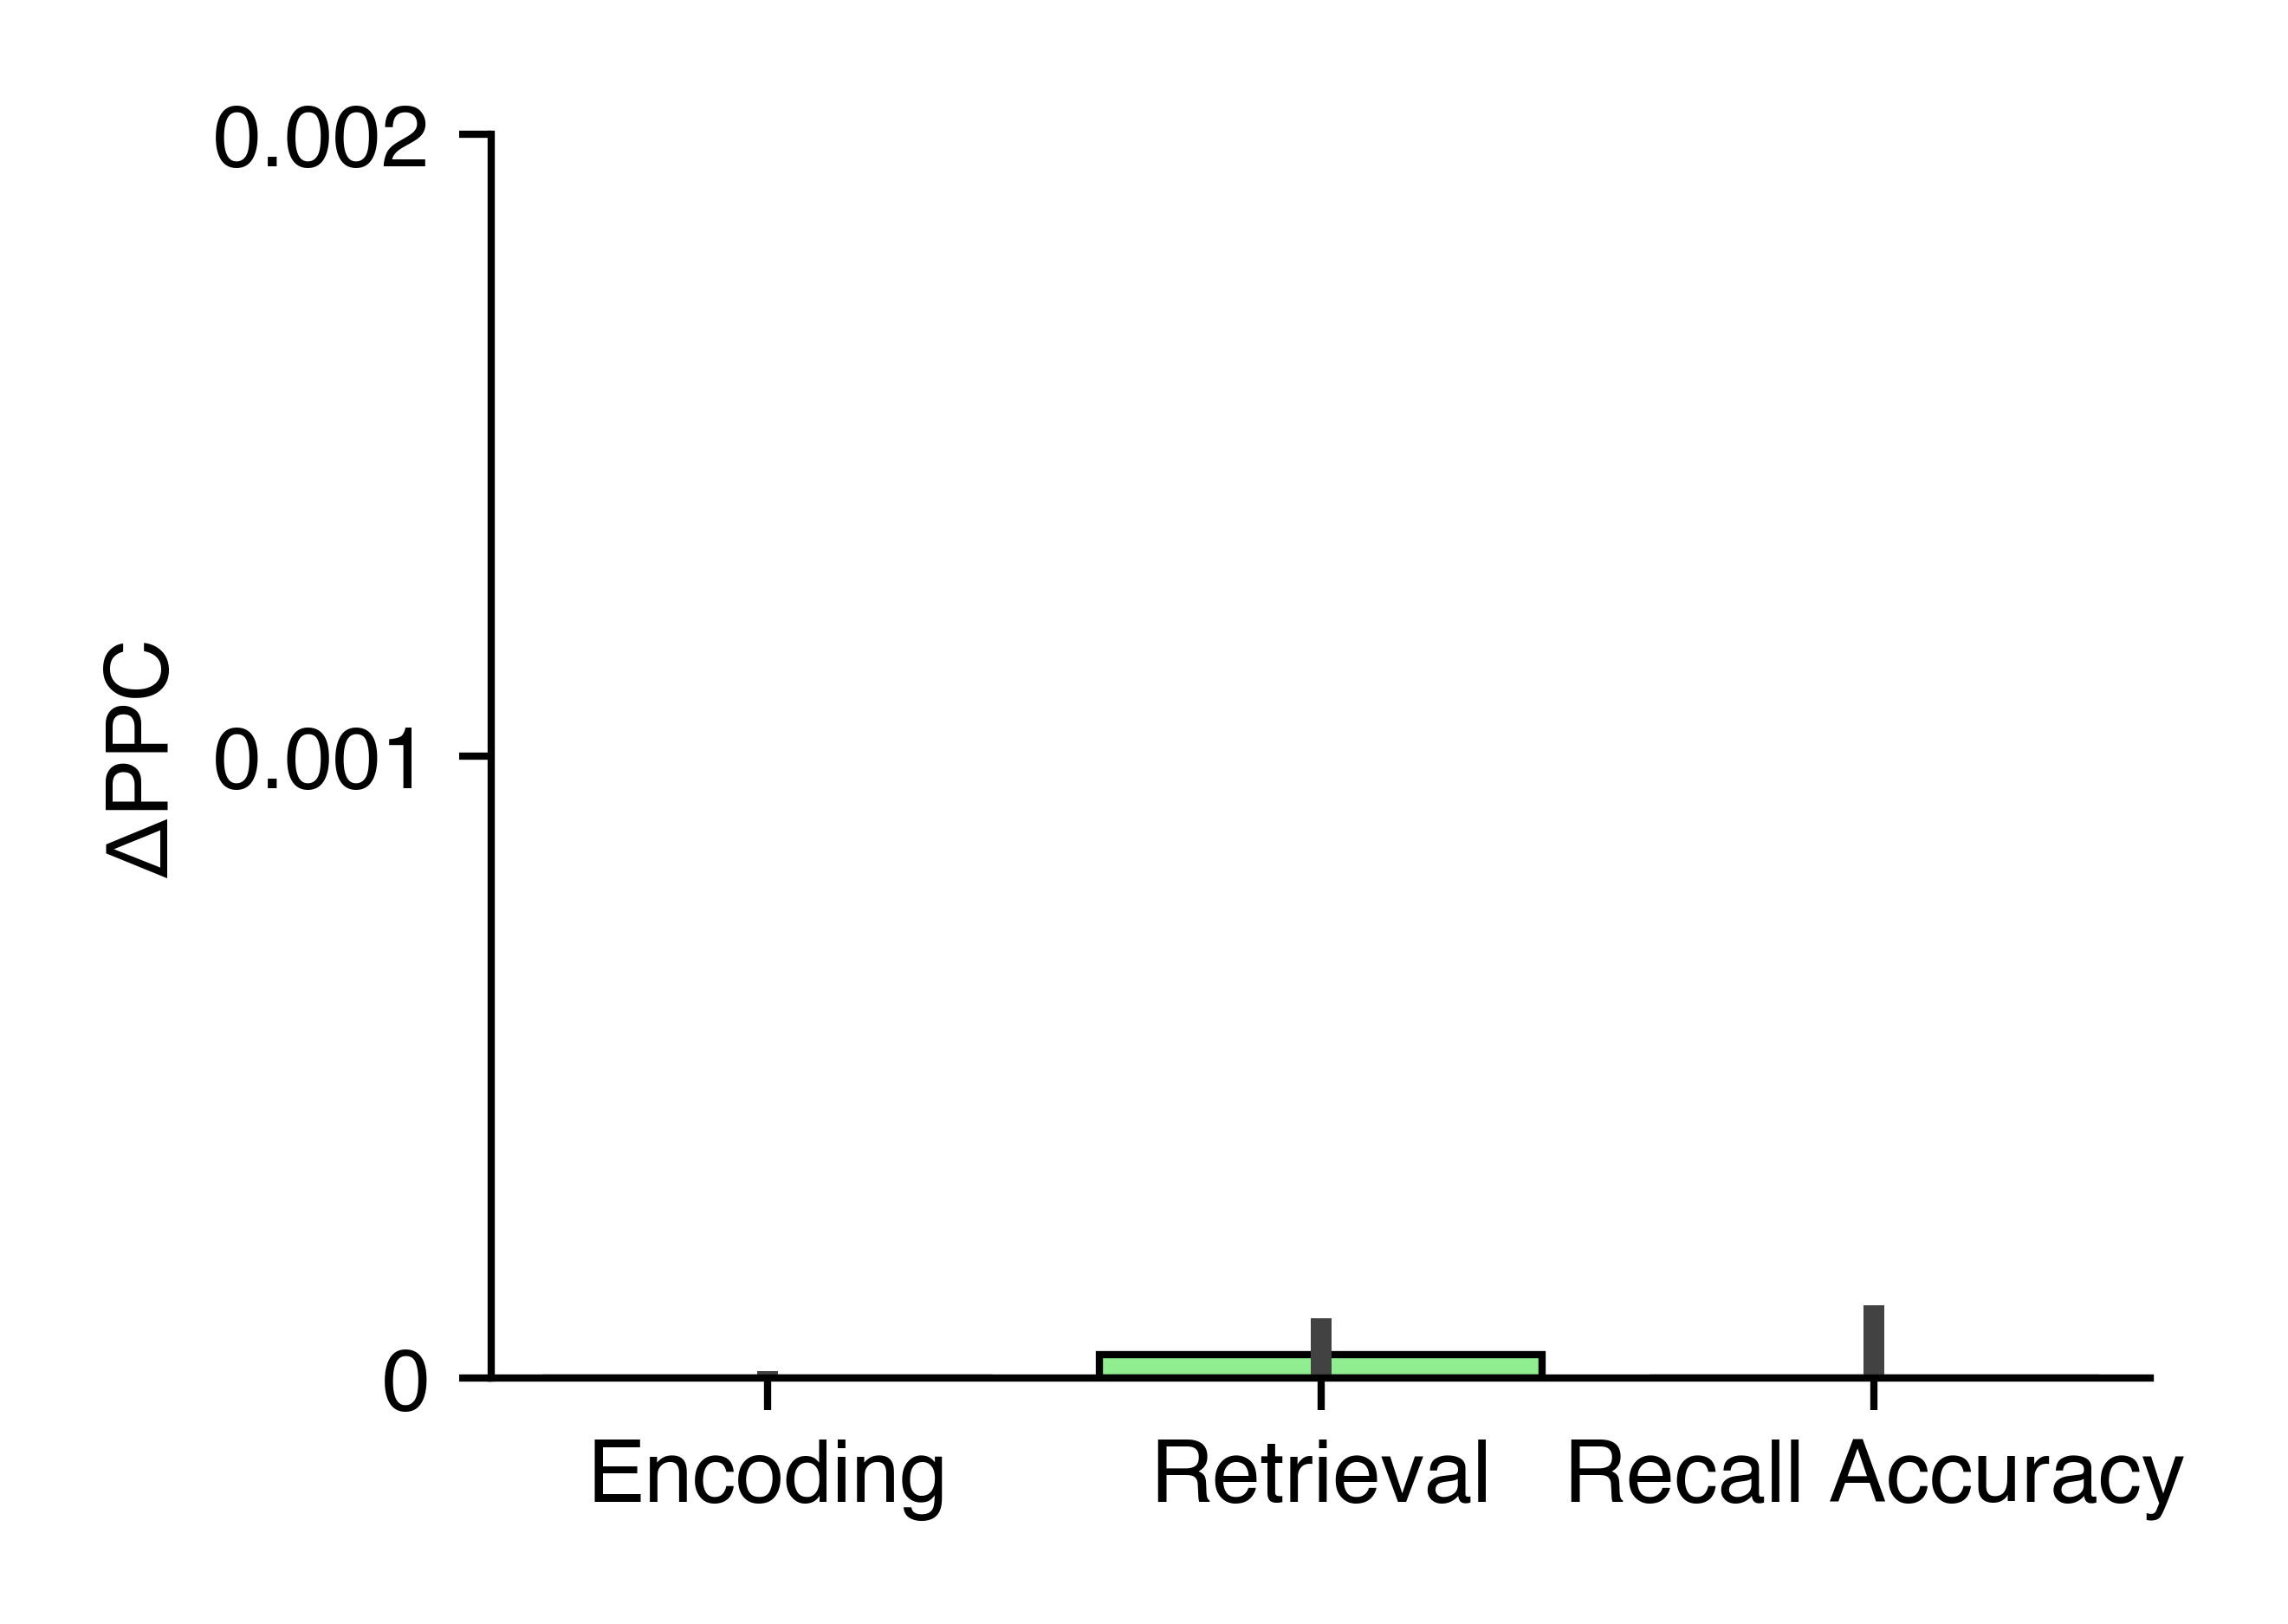

In [22]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.002
yticks = [0, .001, .002]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', data=fig2_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                  palette=['darkorange', 'lightgreen', 'deeppink'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()

No handles with labels found to put in legend.


Text(0, 0.5, 'ΔPPC')

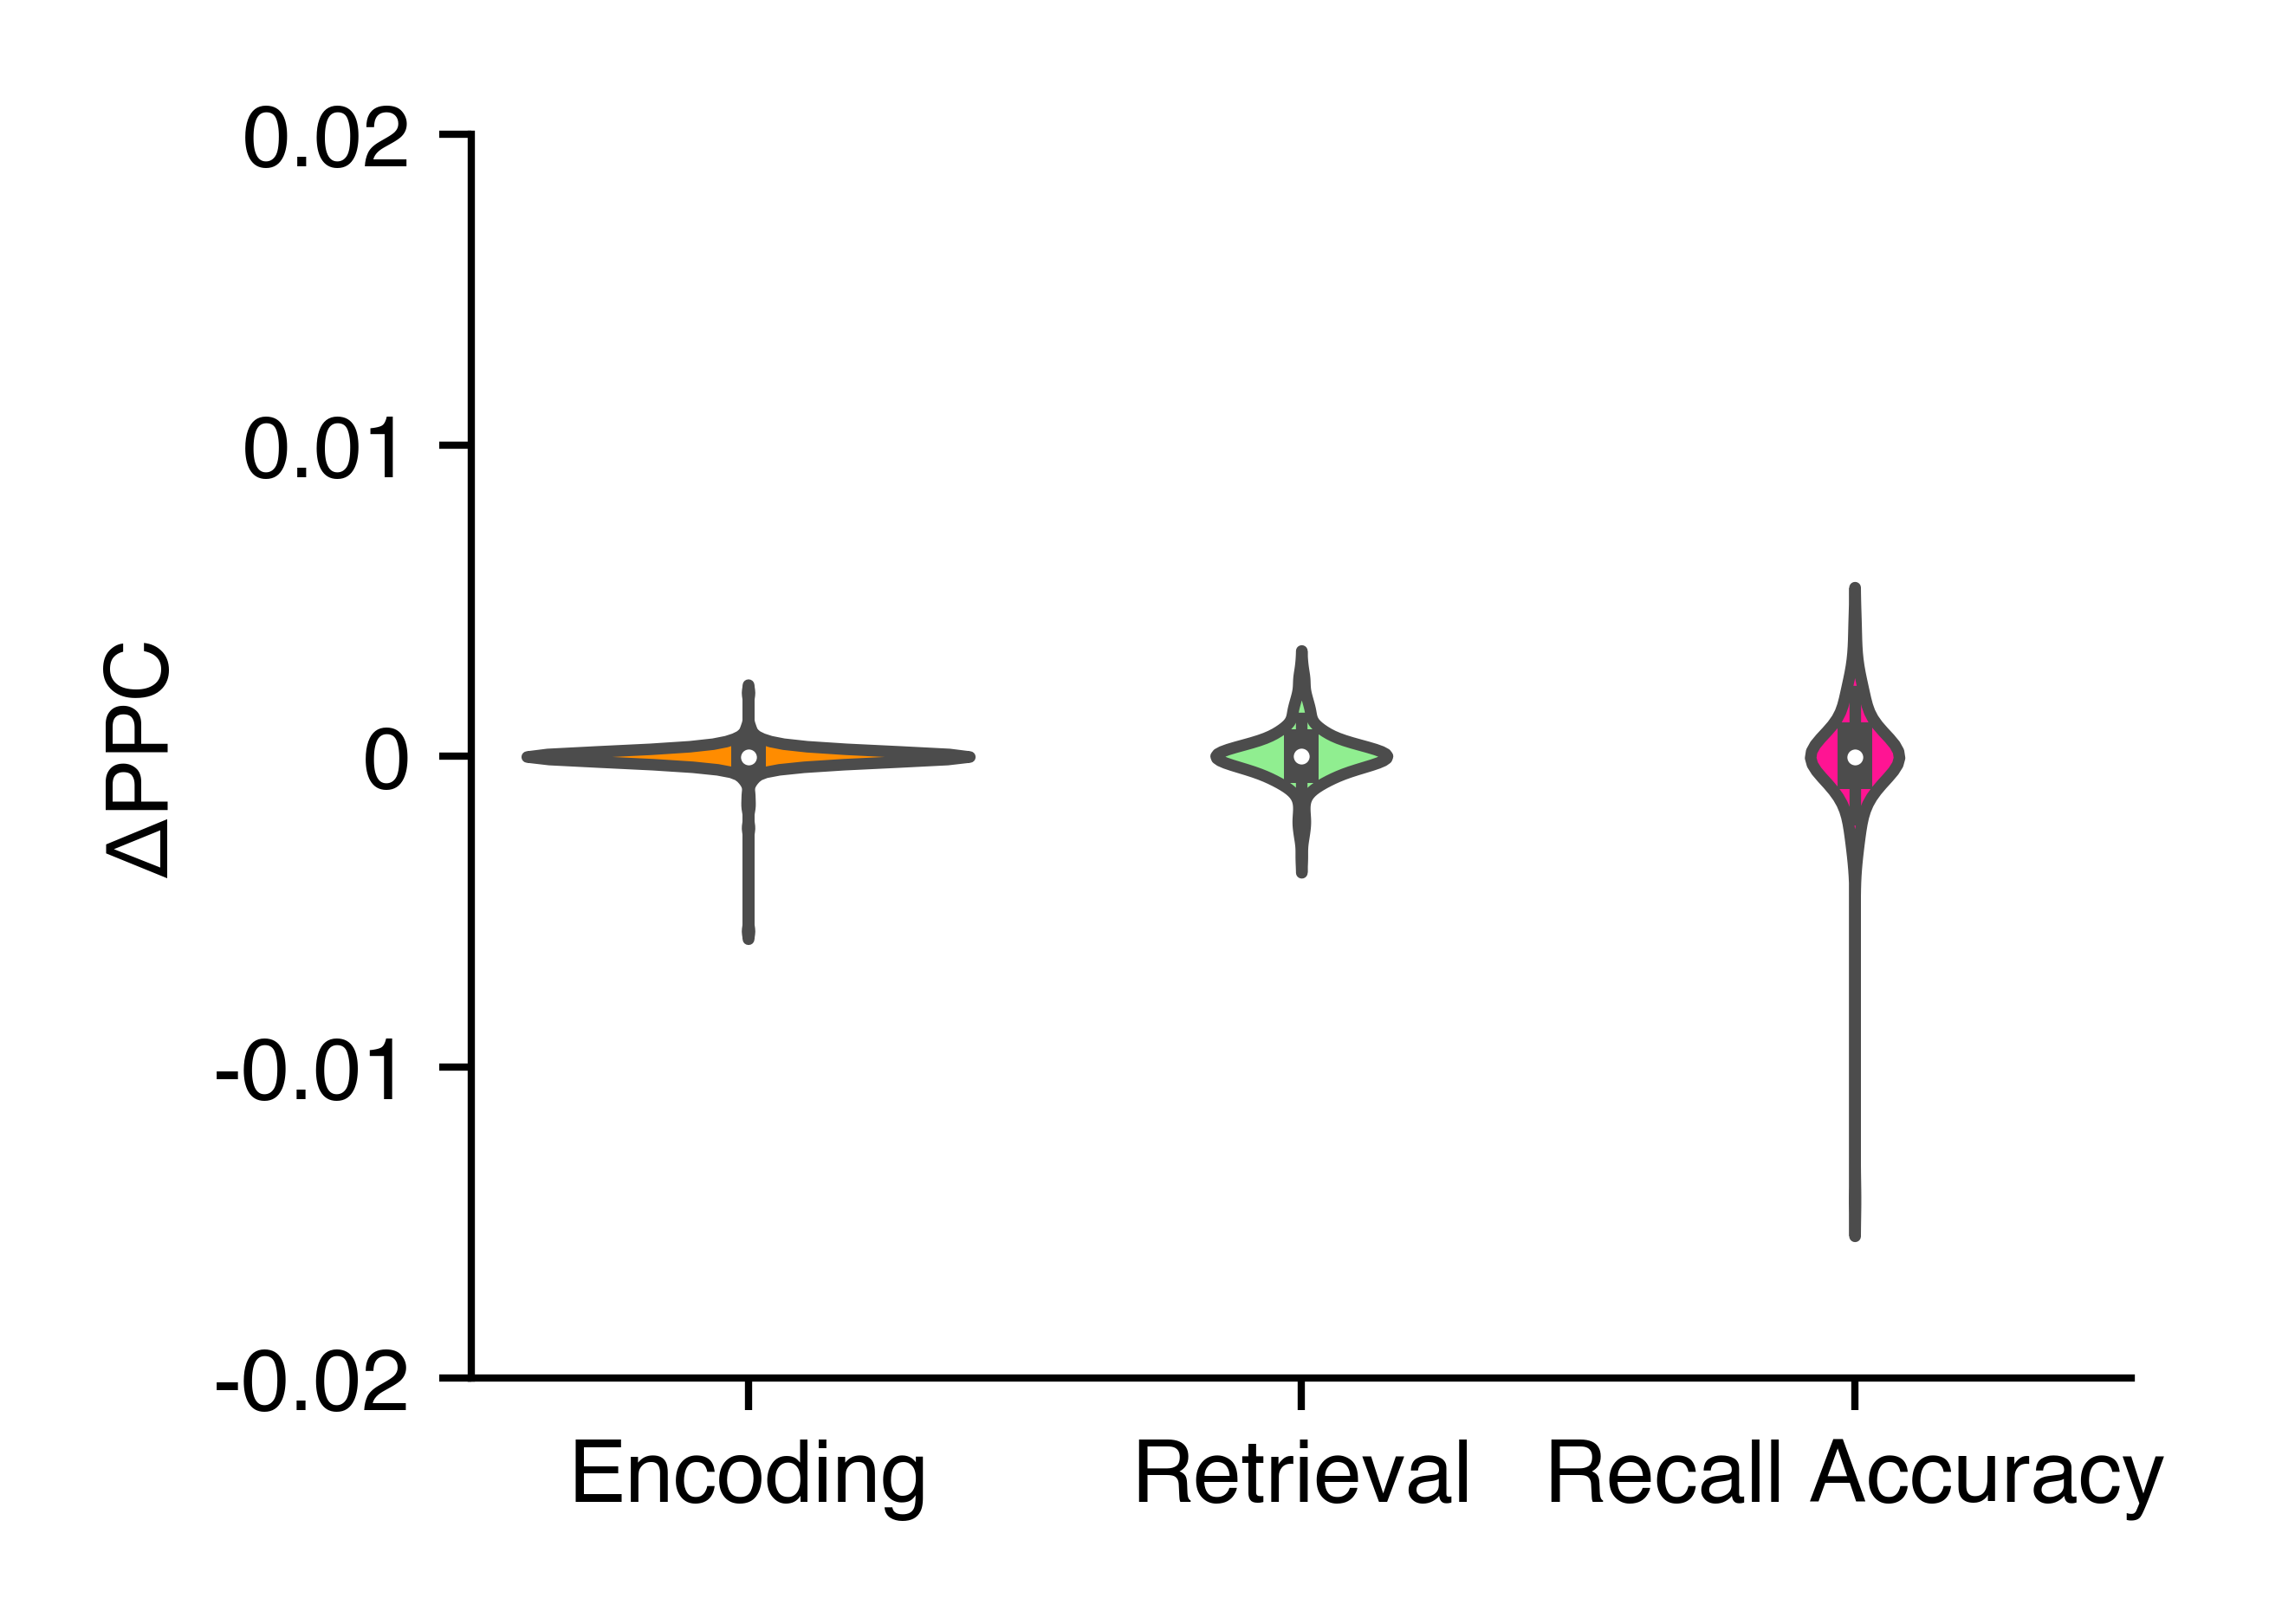

In [23]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
savefig = 0
overwrite = 0
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
ymin = -0.02
ymax = 0.02
yticks = [-0.02, -0.01, 0, 0.01, 0.02]
spine_lw = 0.5
ticklen = 2.2
tickpad = 0
labelpad = 3
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.violinplot(x='beh', y='data', data=fig2_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['darkorange', 'lightgreen', 'deeppink'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

# _ax.errorbar(np.arange(len(hub_df)),
#              hub_df_bar['mean'].to_numpy(),
#              yerr=hub_df_bar[['lower', 'upper']].to_numpy(),
#              ecolor='k', elinewidth=spine_lw, capsize=capsize,
#              capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


# Subject-level effects

## Trial count

In [24]:
def get_sub_trial_count(sub, beh, sess_list_df):
    
    sub_dfrows = sess_list_df.loc[[sub], ['sub', 'exp', 'sess', 'loc', 'mon']].reset_index(drop=True)
    
    def get_trial_count(dfrow, beh):
        events = load_events(dfrow, beh)
        return len(events)//2 if events is not None else np.nan
    
    sub_dfrows['event_count'] = sub_dfrows.apply(lambda dfrow: get_trial_count(dfrow, beh), axis=1)
    
    return sub_dfrows['event_count'].mean()

In [25]:
def get_event_count_effect_size(beh):
    
    if beh in ['en', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index('sub',drop=False)
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index('sub',drop=False)
        
    sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
    sub_list_df[f'{beh}_event_count'] = sub_list_df.apply(lambda r: get_sub_trial_count(r.name, beh, sess_list_df), axis=1)
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
    return sub_list_df

In [26]:
def compute_event_count_effect_size_correlation(sub_list_df):
    
    np.random.seed(202409)
    
    event_counts = sub_list_df[f'{beh}_event_count'].values
    effect_sizes = sub_list_df[f'{beh}_effect_size'].values
    r_true = scipy.stats.pearsonr(event_counts, effect_sizes)[0]
    
    shuffle_count = 999
    rs_shuffled = []
    for _ in range(shuffle_count):
        
        event_counts_shuffled = deepcopy(event_counts)
        effect_sizes_shuffled = deepcopy(effect_sizes)
        np.random.shuffle(event_counts_shuffled)
        np.random.shuffle(effect_sizes_shuffled)
        
        r_shuffled = scipy.stats.pearsonr(event_counts_shuffled, effect_sizes_shuffled)[0]
        rs_shuffled.append(r_shuffled)
        
    rs = [r_true] + rs_shuffled
    p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
    print_header(beh)
    print(f'Pearson\'s r: {r_true}, p = {p}')

In [27]:
for beh in ['en', 'rm', 'ri']:
    
    sub_list_df = get_event_count_effect_size(beh)
    compute_event_count_effect_size_correlation(sub_list_df)

---------en---------
Pearson's r: 0.03227915745482959, p = 0.566
---------rm---------
Pearson's r: -0.05441506864187145, p = 0.286
---------ri---------
Pearson's r: 0.03326780931700402, p = 0.662


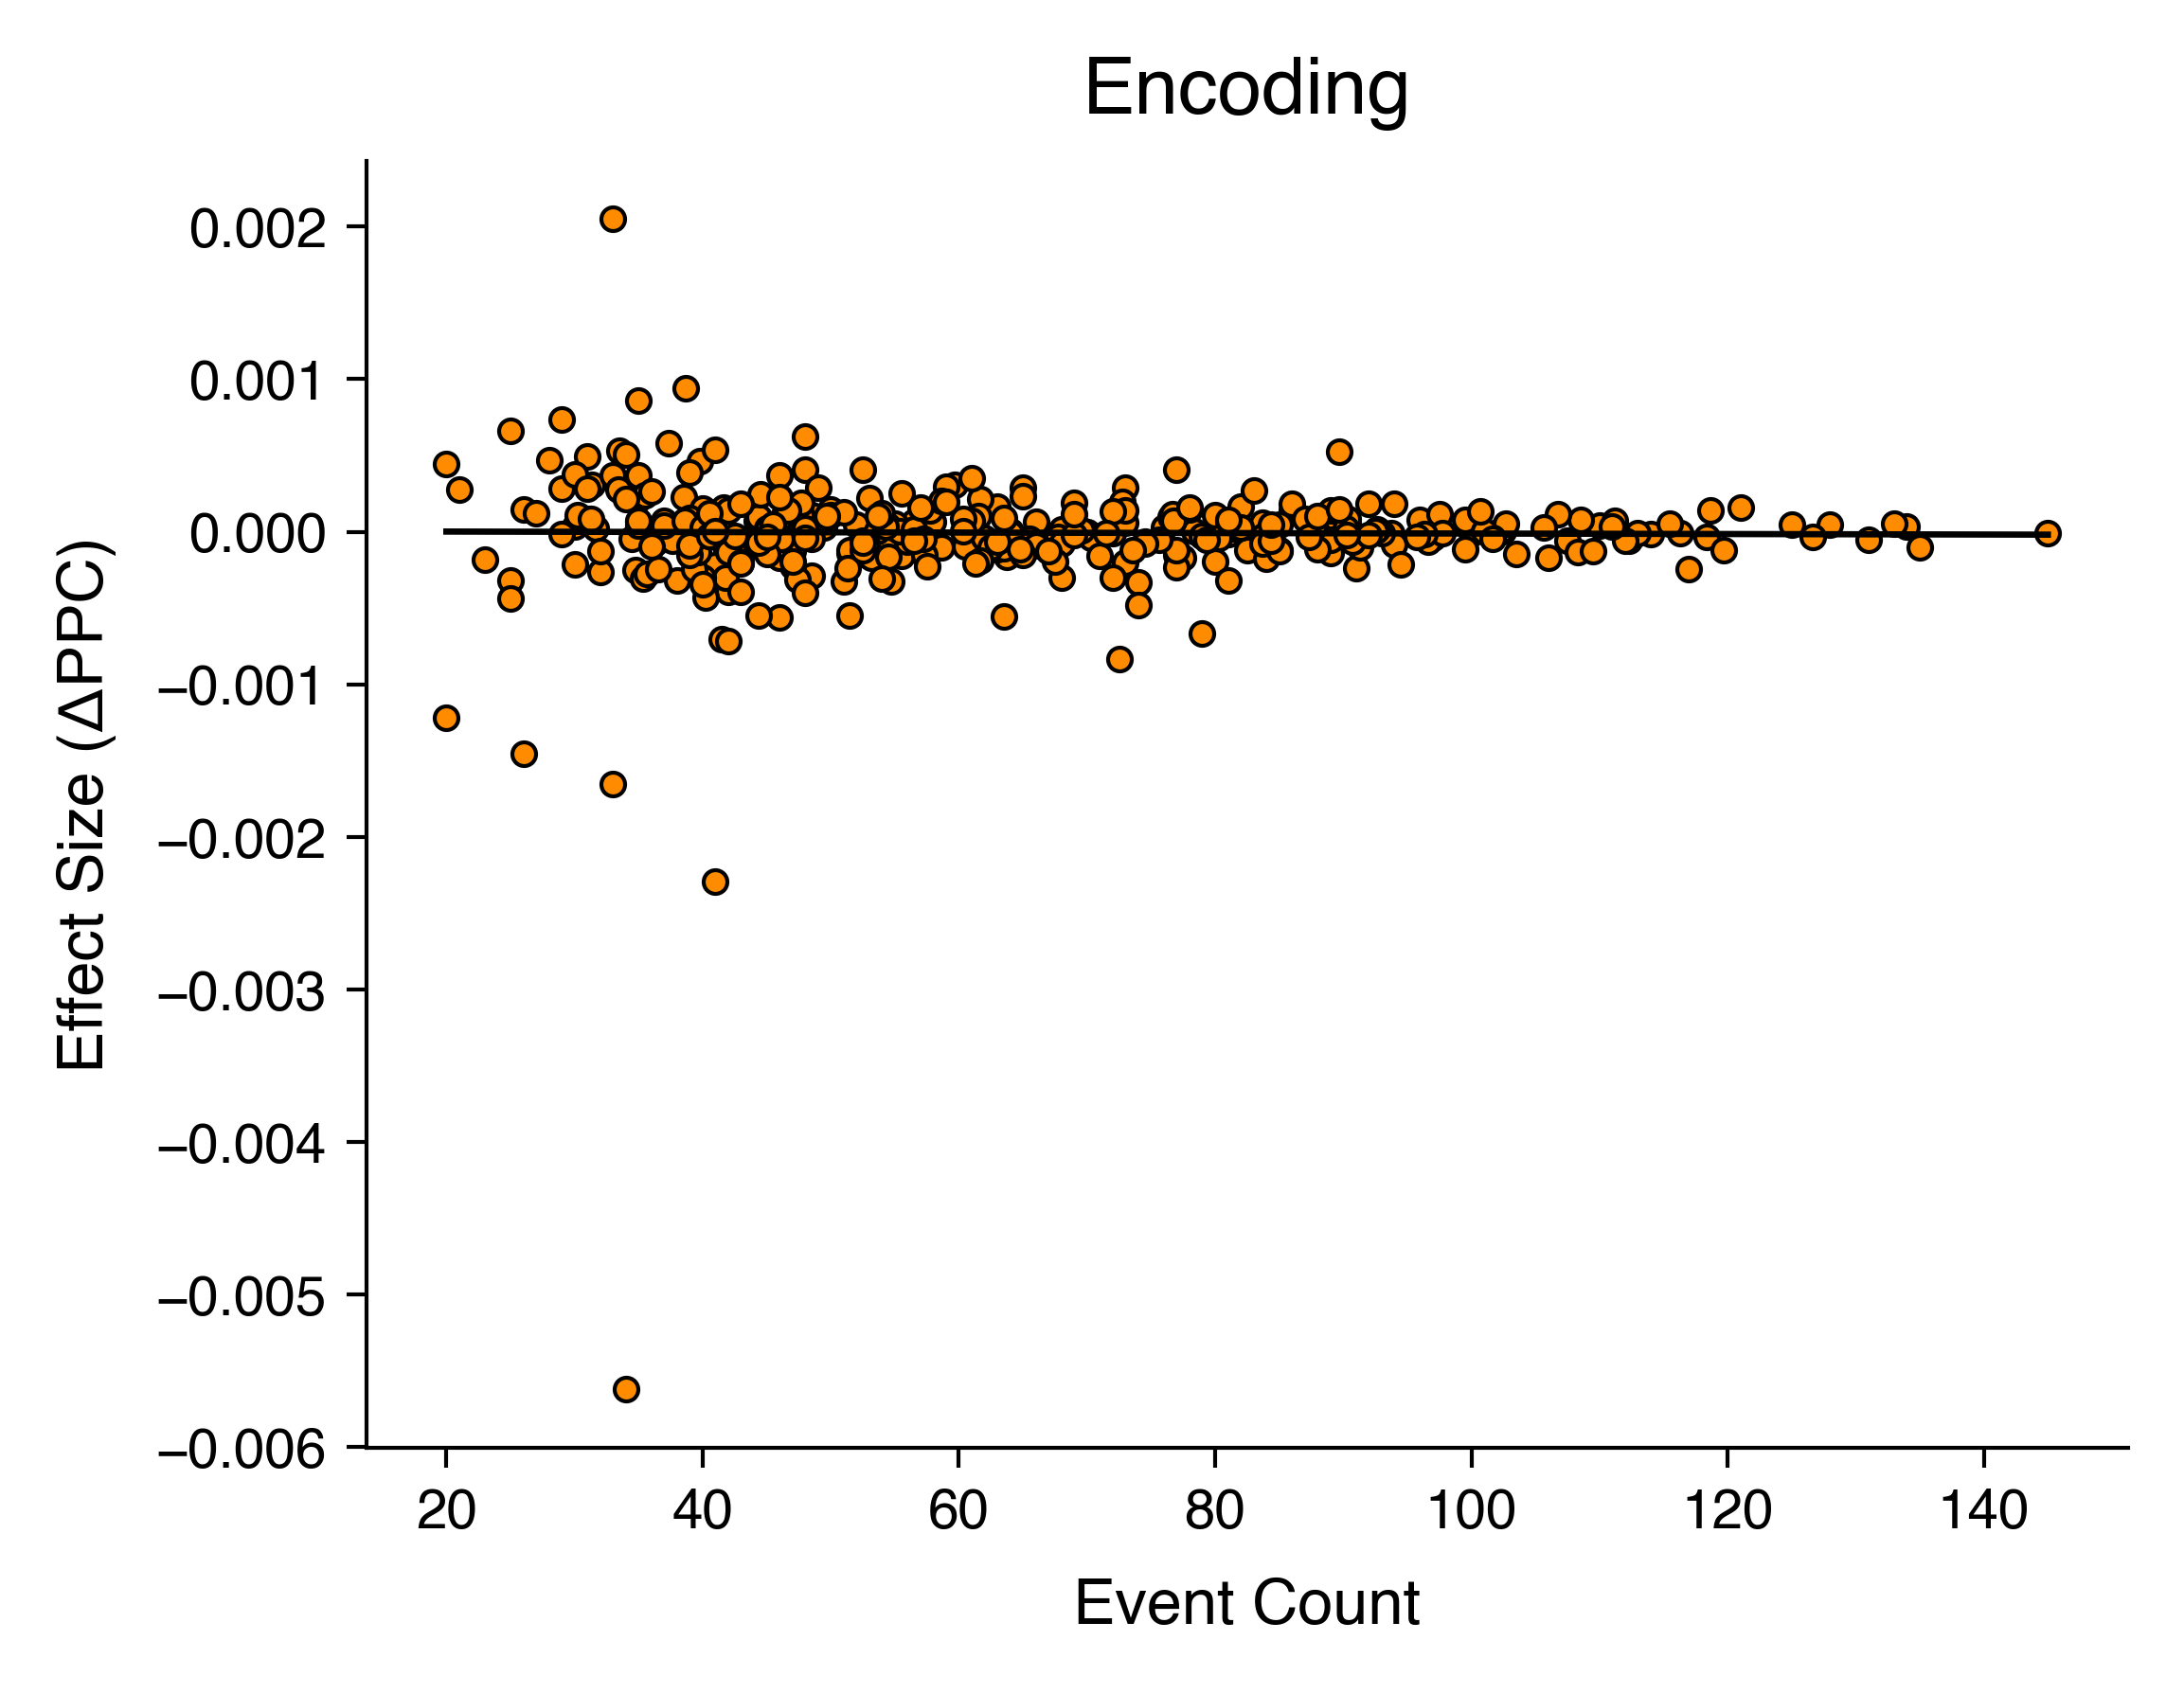

In [28]:
beh = 'en'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='darkorange', edgecolor='black')
ax.set_title('Encoding')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

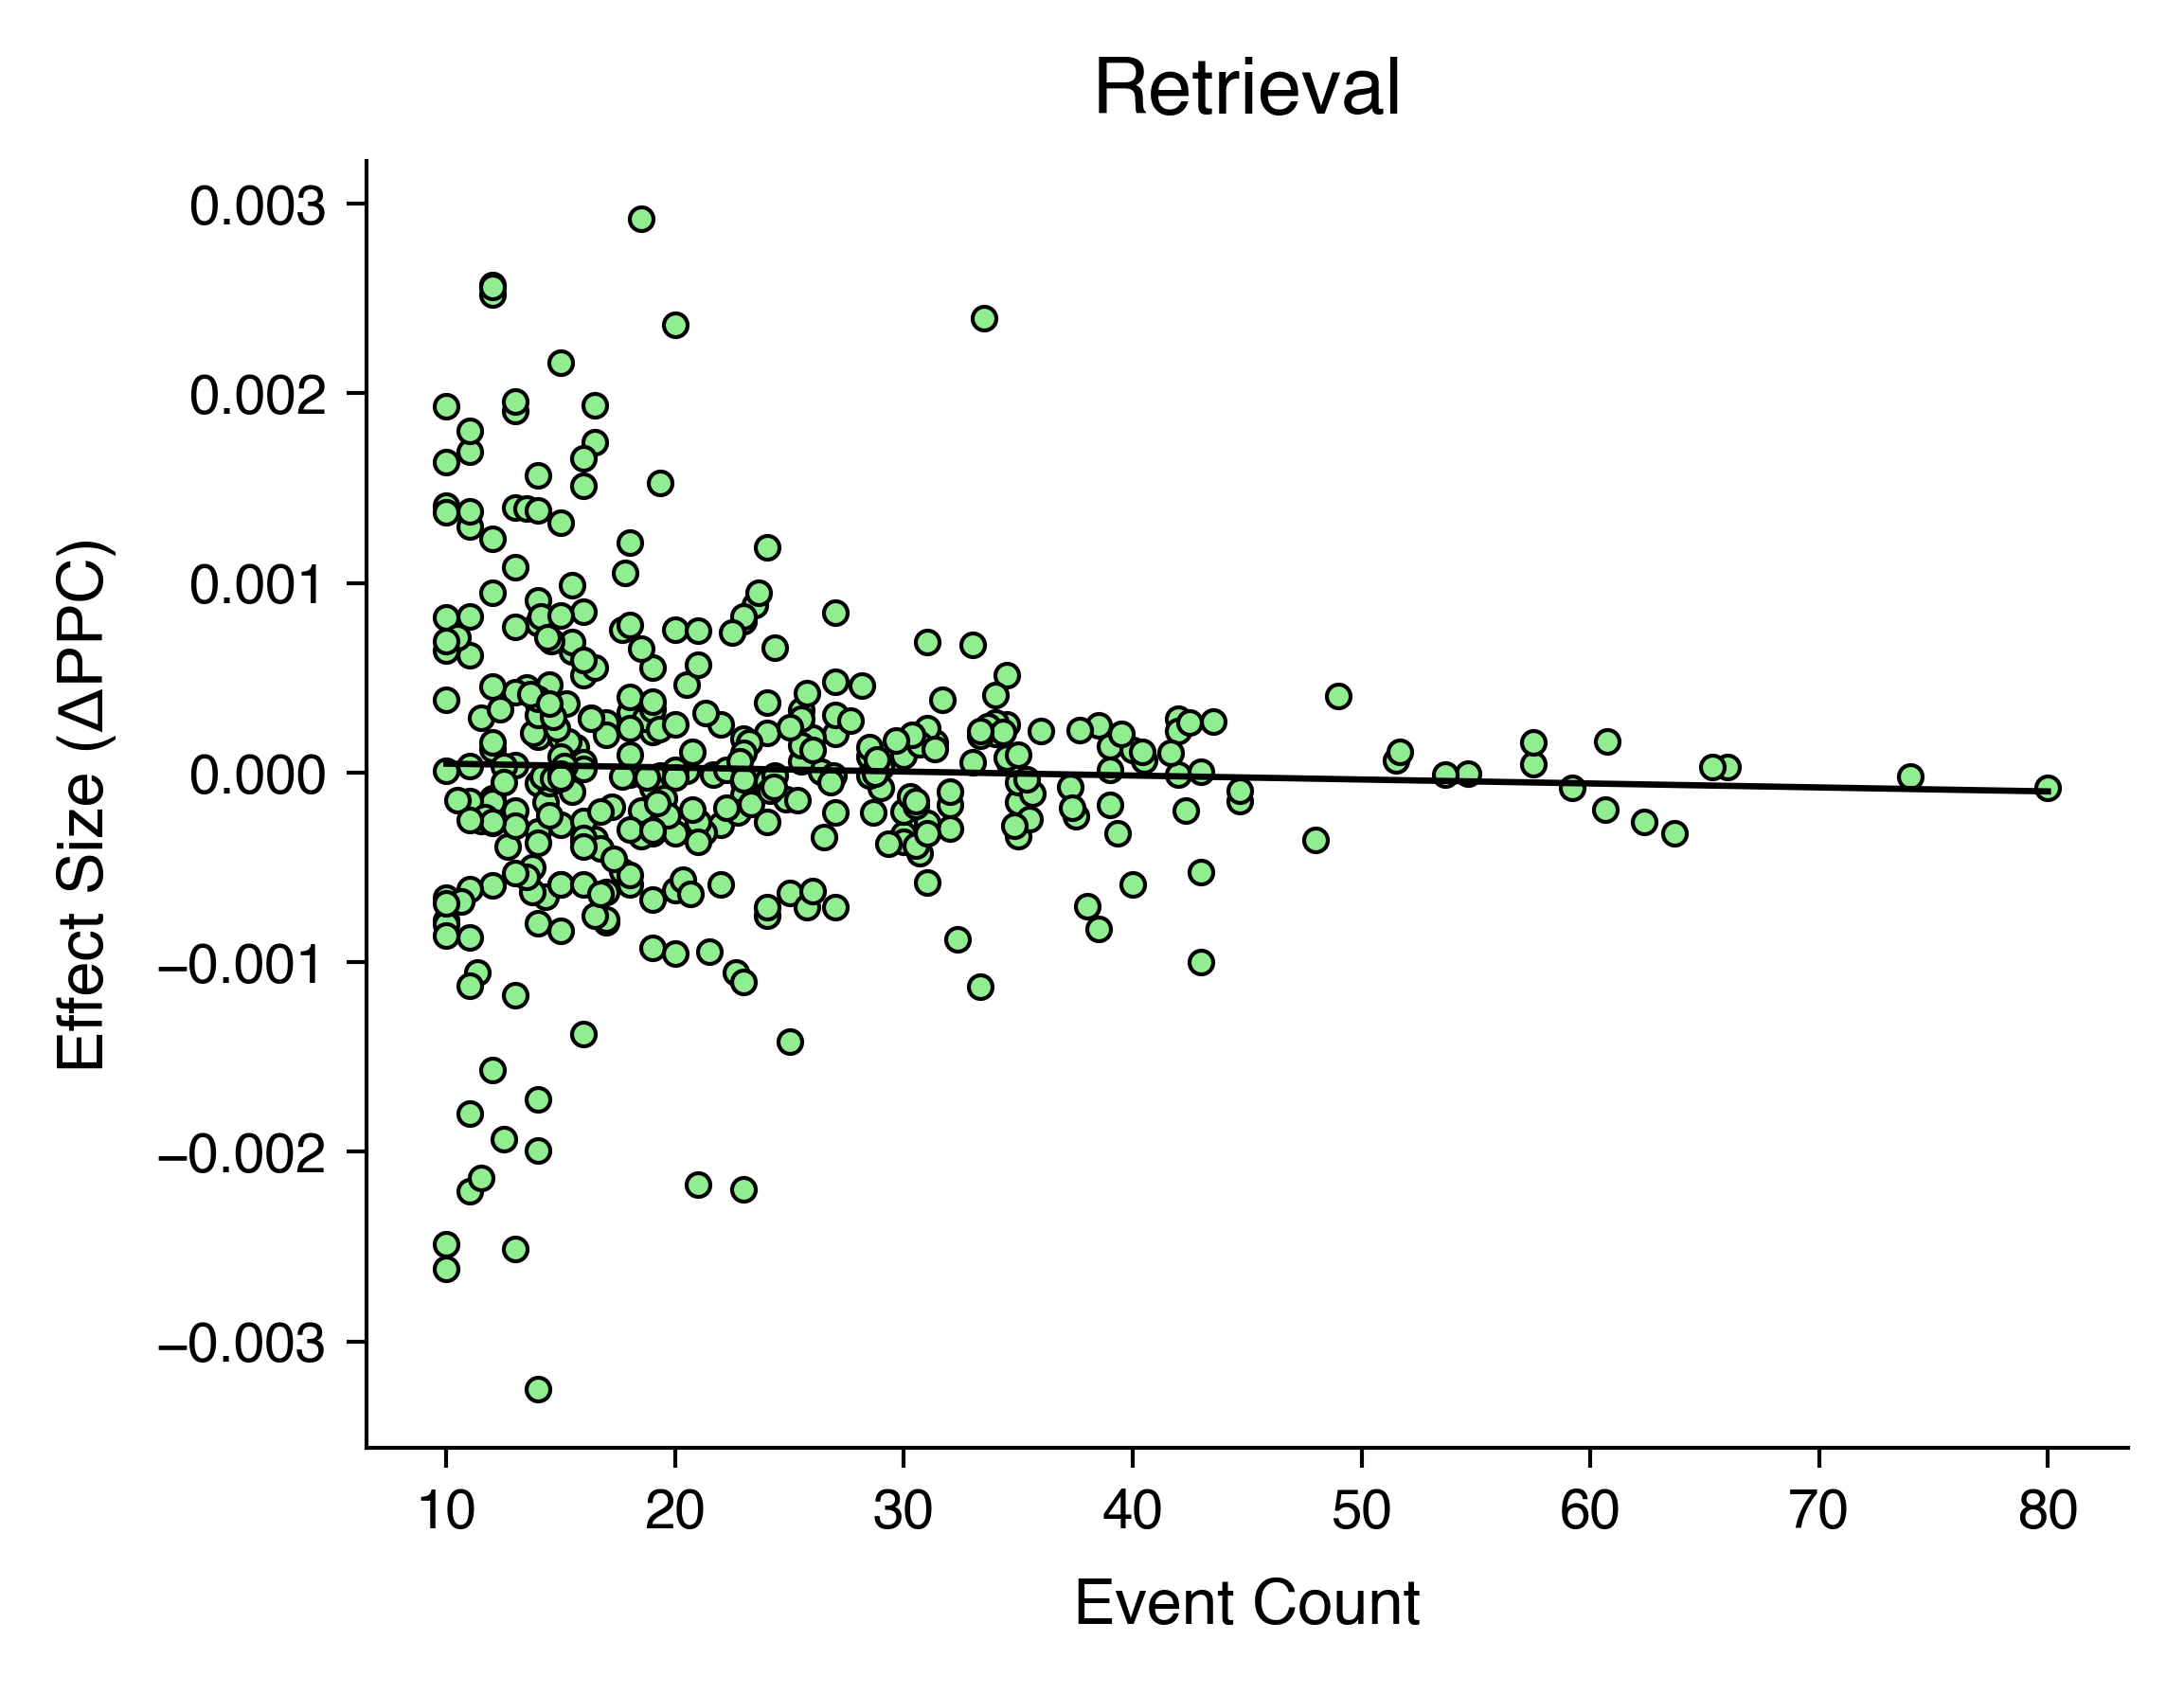

In [29]:
beh = 'rm'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='lightgreen', edgecolor='black')
ax.set_title('Retrieval')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

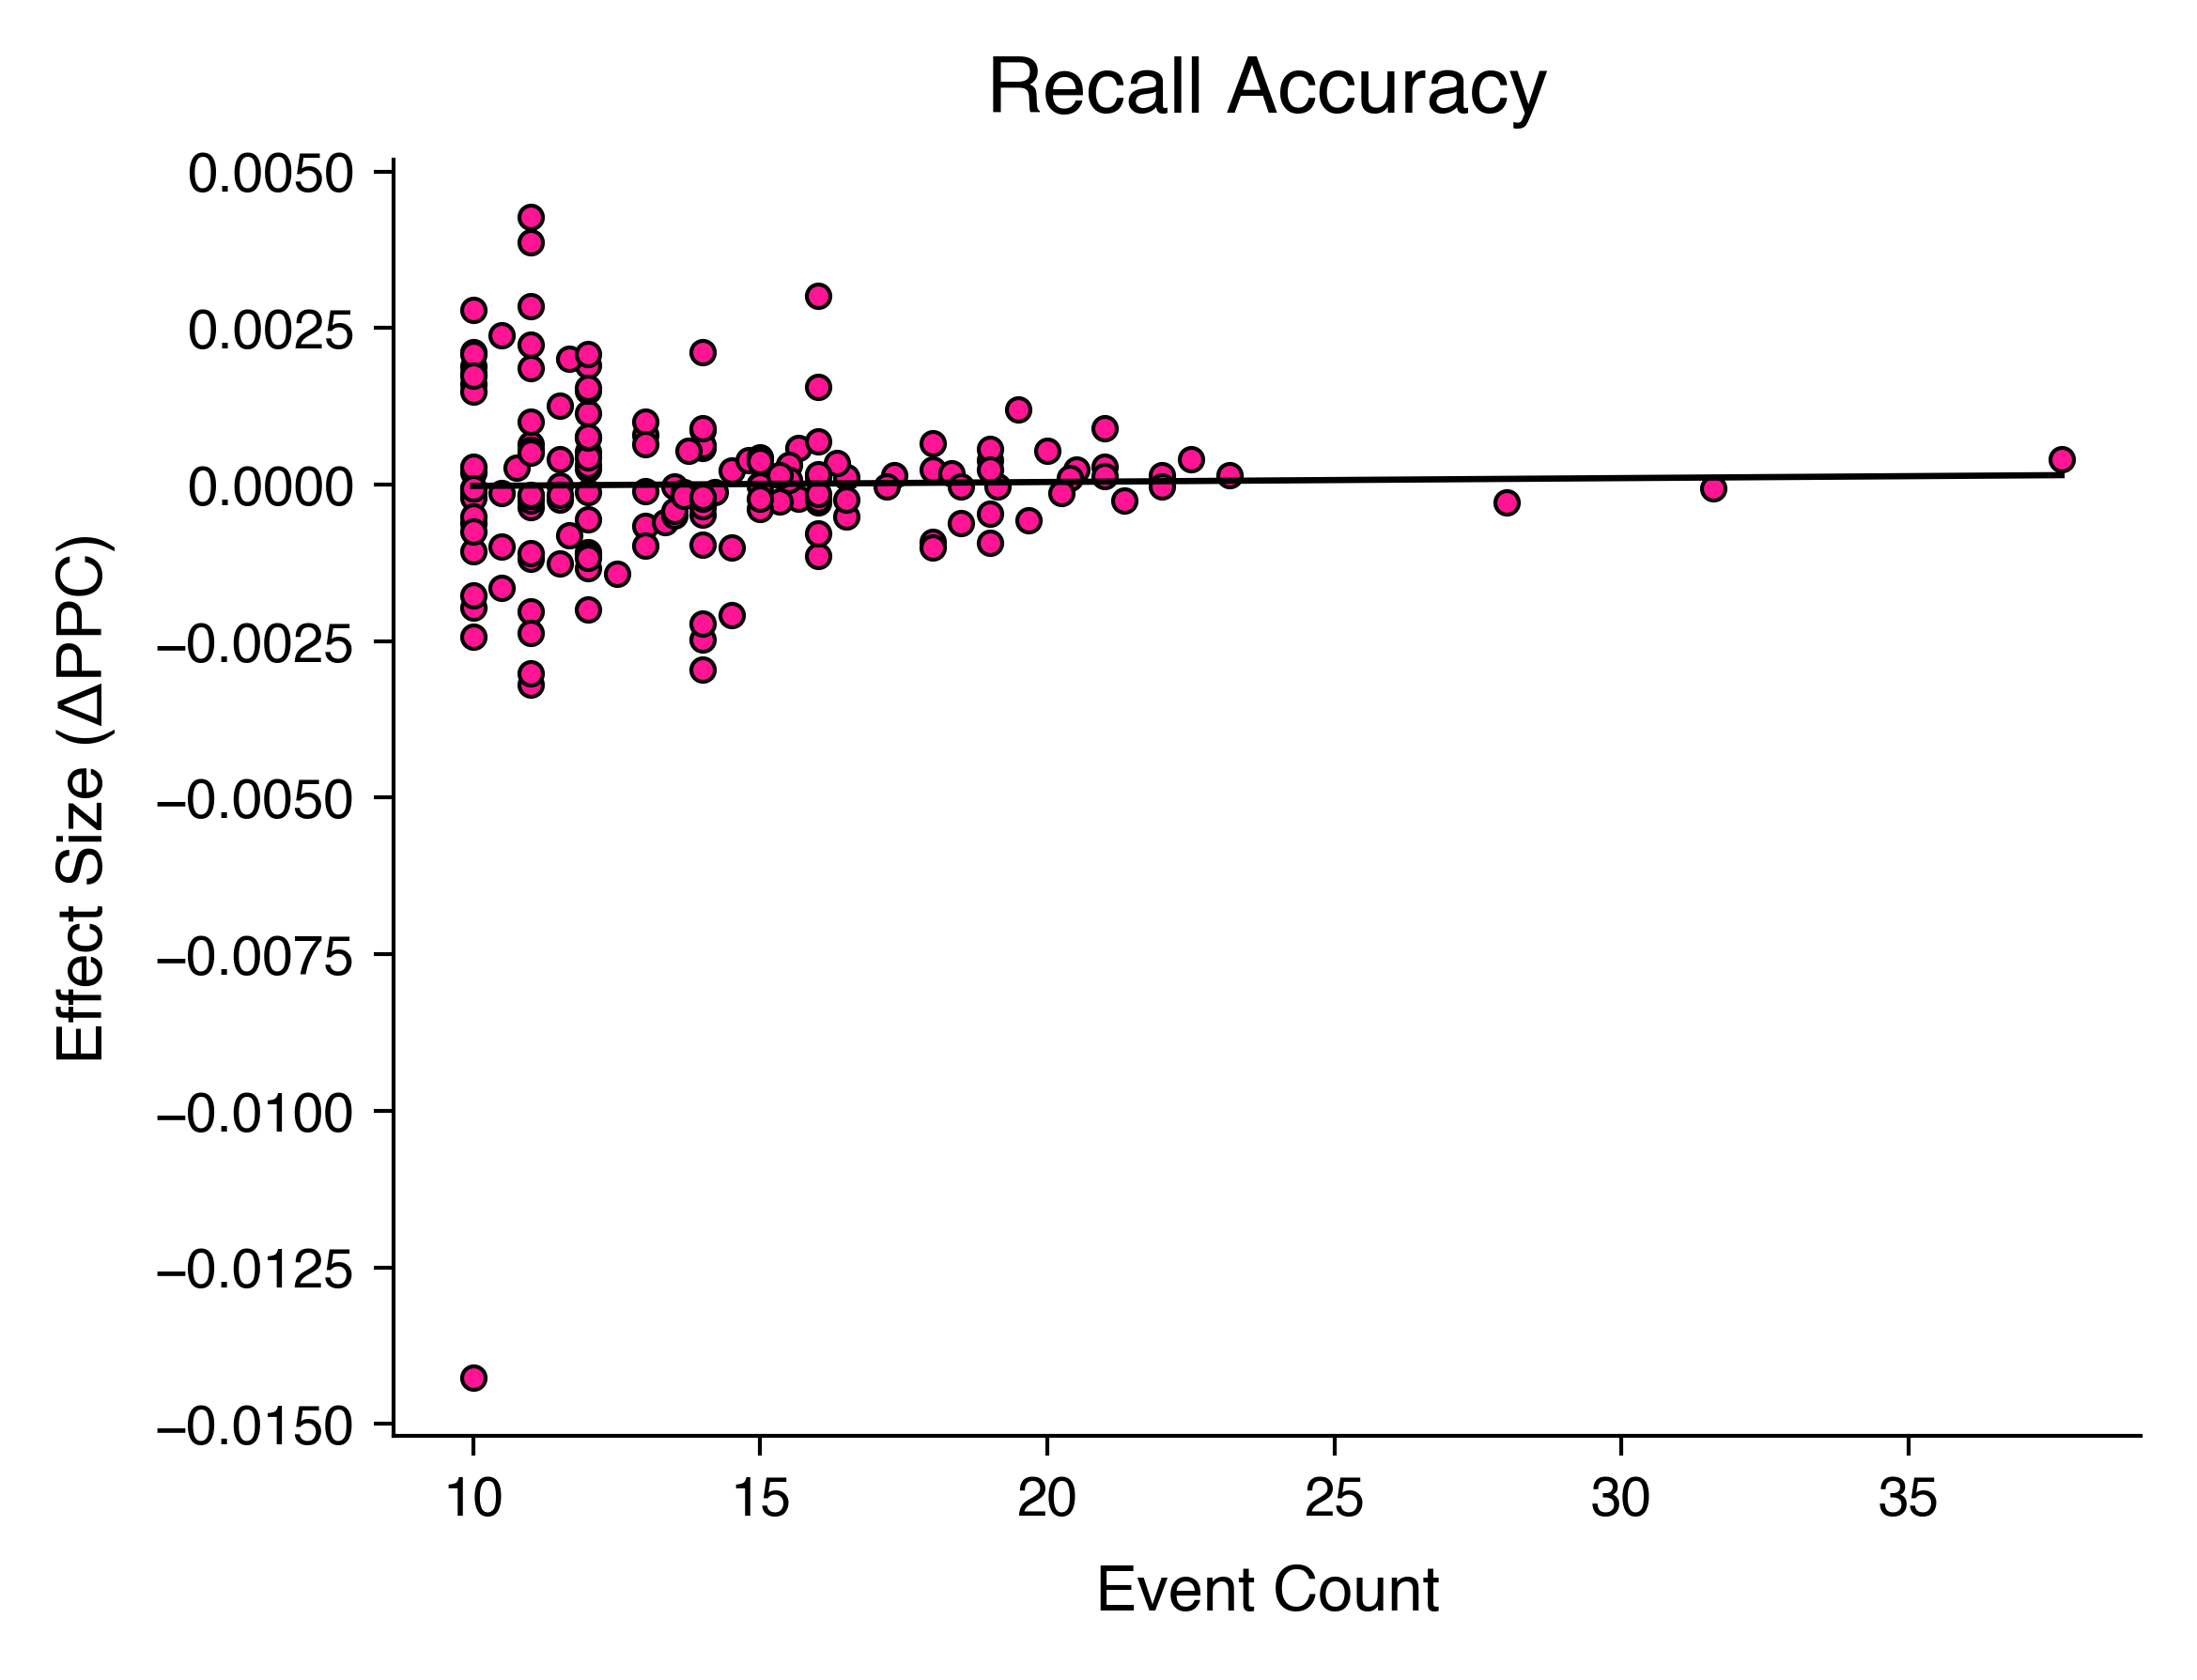

In [30]:
beh = 'ri'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='deeppink', edgecolor='black')
ax.set_title('Recall Accuracy')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

## Noise floors

In [31]:
# shuffle_count = 20

In [32]:
# path = join(root_dir, 'noise_floor_analysis')
# if not ex(path): os.mkdir(path)
# for beh in ['en', 'rm', 'ri']:
#     path = join(root_dir, 'noise_floor_analysis', beh)
#     if not ex(path): os.mkdir(path)
#     path = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates')
#     if not ex(path): os.mkdir(path)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         if not ex(path): os.mkdir(path)
#         for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
#             path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
#             if not ex(path): os.mkdir(path)
# # directory structure: {root_dir}/noise_floor_analysis/en/shuffle_1/shuffled_masks
# # {root_dir}/noise_floor_analysis/en/shuffle_1/elsymxs
# # {root_dir}/noise_floor_analysis/en/shuffle_1/regsymxs

In [33]:
# import shutil
# path = join(root_dir, 'noise_floor_analysis')
# if ex(path): shutil.rmtree(path)
# for beh in ['en', 'rm']:
#     path = join(root_dir, 'noise_floor_analysis', beh)
#     if ex(path): shutil.rmtree(path)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         if ex(path): shutil.rmtree(path)
#         for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
#             path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
#             if ex(path): shutil.rmtree(path)

In [34]:
# def run_pipeline_en_rm_shuffled(dfrow):
    
#     dfrow = get_dfrow(dfrow)
#     for beh in ['en', 'rm']:
#         np.random.seed(202410)
#         for iShuffle in np.arange(1, shuffle_count+1):
#             events = load_events(dfrow, beh)
#             save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#             shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
#             if ex(shuffled_mask_fname):
#                 events.attrs['mask'] = npl(shuffled_mask_fname)
#             else:
#                 np.random.shuffle(events.attrs['mask'])
#                 np.save(shuffled_mask_fname, events.attrs['mask'])
#             run_pipeline(dfrow, beh, events, save_dir)

In [35]:
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
# sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [36]:
# client = cl('run_pipeline_en_rm_shuffled', '20G', int(2000/10), walltime=200000) 
# futures = client.map(run_pipeline_en_rm_shuffled, sess_list)
# wait(futures, client, check_delay=30)

In [37]:
# client.shutdown()

In [38]:
# get_ex(futures, sess_list)

In [39]:
# np.all([future.status == 'finished' for future in futures])

In [40]:
# len(ld(root_dir + '/noise_floor_analysis/rm/shuffle_20/regsymxs'))

In [41]:
# def run_pipeline_ri_shuffled(dfrow):
    
#     dfrow = get_dfrow(dfrow)
#     beh = 'ri'
#     np.random.seed(202410)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         events = load_events(dfrow, beh)
#         save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
#         if ex(shuffled_mask_fname):
#             events.attrs['mask'] = npl(shuffled_mask_fname)
#         else:
#             np.random.shuffle(events.attrs['mask'])
#             np.save(shuffled_mask_fname, events.attrs['mask'])
#         run_pipeline(dfrow, beh, events, save_dir)

In [42]:
# sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
# sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [43]:
# client2 = cl('run_pipeline_ri_shuffled', '20G', int(1500/10), walltime=200000) 
# futures2 = client2.map(run_pipeline_ri_shuffled, sess_list_ri)
# wait(futures2, client2, check_delay=30)

In [44]:
# client.shutdown()
# client2.shutdown()

In [45]:
# not_done_fnames = []
# for beh in ['en', 'rm', 'ri']:
#     for iShuffle in range(1, 21):
#         for i, dfrow in sess_list_df.iterrows():
#             fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
#             if ex(fname):
#                 try:
#                     xr.open_dataarray(fname)
#                 except:
#                     not_done_fnames.append(fname)

In [46]:
# print(len(not_done_fnames))

In [47]:
# for fname in not_done_fnames:
#     os.system(f'rm {fname}')

In [48]:
# def estimate_noise_floor_en_rm(dfrow):
    
#     dfrow = get_dfrow(dfrow)
    
#     for beh in ['en', 'rm']:
#         noise_floor_estimates = []
#         for iShuffle in np.arange(1, shuffle_count+1):
#             fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
#             mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#             mx = mx.sel(success=1) - mx.sel(success=0)
#             noise_floor_estimate = float(mx.values)
#             noise_floor_estimates += [noise_floor_estimate]
        
#         save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
#         np.save(save_fname, noise_floor_estimates)

In [49]:
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
# sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [50]:
# client = cl('estimate_noise_floor_en_rm', '20G', int(2000/10), walltime=200000) 
# futures = client.map(estimate_noise_floor_en_rm, sess_list)
# wait(futures, client, check_delay=30)

In [51]:
# def estimate_noise_floor_ri(dfrow):
    
#     dfrow = get_dfrow(dfrow)
    
#     beh = 'ri'
#     noise_floor_estimates = []
#     for iShuffle in np.arange(1, shuffle_count+1):
#         fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
#         mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#         mx = mx.sel(success=1) - mx.sel(success=0)
#         noise_floor_estimate = float(mx.values)
#         noise_floor_estimates += [noise_floor_estimate]

#     save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
#     np.save(save_fname, noise_floor_estimates)

In [52]:
# sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
# sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [53]:
# client2 = cl('estimate_noise_floor_ri', '20G', int(2000/10), walltime=200000) 
# futures2 = client2.map(estimate_noise_floor_ri, sess_list_ri)
# wait(futures2, client2, check_delay=30)

In [54]:
# client.shutdown()
# client2.shutdown()

In [55]:
# def get_noise_floor_effect_size(beh):
    
#     if beh in ['en', 'en_all', 'rm']:
#         sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
#     elif beh == 'ri':
#         sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon']]
        
#     sess_list_df[f'{beh}_noise_floor'] = sess_list_df.apply(lambda dfrow: np.mean(npl(join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy'))), axis=1)
                                                            
#     sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
#     sub_list_df[f'{beh}_noise_floor'] = sub_list_df.apply(lambda r: sess_list_df[sess_list_df['sub'] == r.name][f'{beh}_noise_floor'].mean(), axis=1)
#     mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#     mx = mx.sel(success=1) - mx.sel(success=0)
#     sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
#     return sub_list_df

In [56]:
# def compute_noise_floor_effect_size_correlation(sub_list_df):
    
#     np.random.seed(202409)
    
#     noise_floors = sub_list_df[f'{beh}_noise_floor'].values
#     effect_sizes = sub_list_df[f'{beh}_effect_size'].values
#     r_true = scipy.stats.pearsonr(noise_floors, effect_sizes)[0]
    
#     shuffle_count = 999
#     rs_shuffled = []
#     for _ in range(shuffle_count):
        
#         noise_floors_shuffled = deepcopy(noise_floors)
#         effect_sizes_shuffled = deepcopy(effect_sizes)
#         np.random.shuffle(noise_floors_shuffled)
#         np.random.shuffle(effect_sizes_shuffled)
        
#         r_shuffled = scipy.stats.pearsonr(noise_floors_shuffled, effect_sizes_shuffled)[0]
#         rs_shuffled.append(r_shuffled)
        
#     rs = [r_true] + rs_shuffled
#     p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
#     print_header(beh)
#     print(f'Pearson\'s r: {r_true}, p = {p}')

In [57]:
# for beh in ['en', 'rm', 'ri']:
    
#     sub_list_df = get_noise_floor_effect_size(beh)
#     compute_noise_floor_effect_size_correlation(sub_list_df)

In [58]:
# beh = 'en'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='darkorange', edgecolor='black')
# ax.set_title('Encoding')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

In [59]:
# beh = 'rm'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='lightgreen', edgecolor='black')
# ax.set_title('Retrieval')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

In [60]:
# beh = 'ri'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='deeppink', edgecolor='black')
# ax.set_title('Recall Accuracy')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

# Hub analysis

In [61]:
# def compute_hub_table(beh, freq):
    
#     np.random.seed(202407)
        
#     assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
#     symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean(['epoch', 'reg2'])
    
#     if freq == 'theta': symx = symx.mean('freq')
#     else: symx = symx.sel(freq=freq)
        
#     hub_table = pd.DataFrame({'reg': symx.reg1.values})
    
#     def get_ppc_differences(reg):
        
#         symx_sel = symx.sel(reg1=reg)
#         ppc_successful = symx_sel.sel(success=1).data
#         ppc_unsuccessful = symx_sel.sel(success=0).data
#         return ppc_successful, ppc_unsuccessful
    
#     hub_table[['ppc_successful', 'ppc_unsuccessful']] = hub_table.apply(lambda r: get_ppc_differences(r['reg']), axis=1, result_type='expand')
#     hub_table['ppc_differences'] = hub_table['ppc_successful'] - hub_table['ppc_unsuccessful']
#     hub_table['sub_count'] = hub_table.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
#     shuffle_count = 10000
#     sub_threshold = 7
#     flip_masks = np.asarray([(2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
        
#     hub_table['t'] = hub_table.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0).statistic if r['sub_count'] >= sub_threshold else np.nan, axis=1)
#     hub_table['t_shuffled'] = hub_table.apply(lambda r: np.asarray([scipy.stats.ttest_1samp(finitize(r['ppc_differences']*flip_mask), popmean=0).statistic for flip_mask in flip_masks]) if not np.isnan(r['t']) else [], axis=1)
#     no_tests = np.sum(~pd.isna(hub_table['t']))
    
#     t_distribution = np.asarray([t for ts in hub_table['t_shuffled'].values for t in ts if len(ts) > 0])
#     p0 = (2*np.sum([np.quantile(t_distribution, 0.25) <= t <= np.quantile(t_distribution, 0.75) for t in hub_table['t'].values]))/no_tests
#     p0 = np.min([p0, 1])
    
#     hub_table['p_fdr'] = hub_table.apply(lambda r: p0*(np.sum(np.abs(t_distribution) >= np.abs(r['t']))+1)/(len(t_distribution)+1) if not np.isnan(r['t']) else np.nan, axis=1)
#     hub_table['hub'] = hub_table['p_fdr'] < 0.05
    
#     return hub_table, t_distribution, flip_masks
        

In [62]:
# hub_tables = pd.Series({})
# t_distributions = pd.Series({})
# for beh in ['en', 'rm', 'ri']:
#     hub_tables[beh], t_distributions[beh], _ = compute_hub_table(beh, 'theta')

In [63]:
# for beh in ['en', 'rm', 'ri']:
#     hubs = hub_tables[beh].query('hub==True')[['reg', 't']]
#     no_hubs = len(hubs)
#     no_positive_hubs = len(hubs.query('t > 0'))
#     no_negative_hubs = len(hubs.query('t < 0'))
#     print(f'{beh}: {no_hubs} hubs, {no_positive_hubs} positive hubs, {no_negative_hubs} negative hubs')
#     print(f'positive hubs: {hubs.query("t > 0")["reg"].values}')
#     print(f'negative hubs: {hubs.query("t < 0")["reg"].values}')

In [64]:
# hub_statistics = pd.DataFrame({'beh': ['en', 'rm', 'ri']})
# hub_statistics['hubs'] = hub_statistics.apply(lambda r: hub_tables[r['beh']].query('hub == True')['reg'].values, axis=1)
# hub_statistics['no_hubs'] = hub_statistics.apply(lambda r: len(r['hubs']), axis=1)
# hub_statistics.set_index('beh', inplace=True)

In [65]:
# save_pickle(join(root_dir, 'hub_tables.pkl'), hub_tables)
# save_pickle(join(root_dir, 't_distributions.pkl'), t_distributions)
# save_pickle(join(root_dir, 'hub_statistics.pkl'), hub_statistics)

In [66]:
# hub_tables = load_pickle(join(root_dir, 'hub_tables.pkl'))

In [67]:
# hub_statistics = load_pickle(join(root_dir, 'hub_statistics.pkl'))

In [68]:
# hub_statistics.loc['ri', 'hubs']

In [69]:
# hub_statistics.loc['ri', 'hubs']

In [70]:
# load_pickle(join(root_dir, 'hub_tables.pkl'))['en'].query('hub==True')[['reg', 't', 'p_fdr']]

In [71]:
# np.setdiff1d(hub_statistics.loc['en_all', 'hubs'], hub_statistics.loc['en', 'hubs'])

In [72]:
# hub_tables['ri'].query('hub==True')[['reg', 't', 'p_fdr']]

In [73]:
# hub_tables['rm'].query('(hub==True) & (t < 0)')['reg'].shape

In [74]:
# np.intersect1d(hub_tables['en'].query('hub==True')['reg'].values, hub_tables['en_all'].query('hub==True')['reg'].values)

In [75]:
# len(hub_tables['en'].query('hub==True')['reg'].values)

In [76]:
# hub_tables['rm'].query('reg=="L transverse temporal gyrus"')

## Create matrix for visualization

In [77]:
# def create_plot_matrix(beh):
#     symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean(['freq', 'epoch'])
#     symx = symx.sel(success=1) - symx.sel(success=0)
#     mask = (np.isfinite(symx).sum('sub') >= 7).astype(int)
#     symx = symx.mean('sub')
#     symx = symx*mask
#     matrix = np.empty(shape=symx.shape)
#     hubs = hub_tables[beh].query('hub == True')['reg'].values
#     positive_hubs = hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values
#     negative_hubs = hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values
#     rank_threshold = 5

#     for iReg1, reg1 in enumerate(symx.reg1.values):

#         if reg1 in hubs:
#             values = np.nan_to_num(symx.sel(reg1=reg1).data, nan=0)
#             if reg1 in positive_hubs: 
#                 values[values < 0] = 0
#                 ranks = len(values) - 1 - np.argsort(np.argsort(values))
#             elif reg1 in negative_hubs: 
#                 values[values > 0] = 0
#                 ranks = np.argsort(np.argsort(values))
#             reg1_rank_threshold = np.min([rank_threshold, np.sum(np.abs(values) > 0)])

#             matrix[iReg1, :] = values * (ranks < reg1_rank_threshold).astype(int)
#         else:
#             matrix[iReg1, :] = 0

#     return matrix


In [78]:
# for beh in ['en', 'rm', 'ri']:
    
#     matrix = create_plot_matrix(beh)
#     matrix = symmetrize(matrix)
#     pd.DataFrame(matrix).to_csv(join(root_dir, f'{beh}_plotmx.csv'), index=False)

In [79]:
# matrix = create_plot_matrix('ri')

In [80]:
# hub_statistics.loc['ri','hubs']

In [81]:
# hub_tables['rm'].query('(hub==True) & (t <0)')

In [82]:
# get_region_information('region_labels')

In [83]:
# np.where(matrix[50] != 0)[0]

In [84]:
# pd.read_csv(join(root_dir, 'ri_plotmx.csv')).loc[50, '69']

In [85]:
# matrix[50, 69]

In [86]:
# hub_tables['ri'].query('reg=="L ventral diencephalon"')

## Get MNI coordinates for regions

In [87]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')

In [88]:
coords = pd.DataFrame([], columns=['region', 'x', 'y', 'z'])
for iSess, rSess in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():

    pairs = get_pairs(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    localization = get_localization(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    regionalizations = regionalize_electrodes(pairs, localization)

    for iPair, pair in pairs.iterrows():
        
        for atlas in ['mni.', 'avg.']:
            if f'{atlas}x' in pairs.columns:
                xyz = tuple(pair[[f'{atlas}x', f'{atlas}y', f'{atlas}z']].values)
                if np.all([isinstance(c, float) for c in xyz]):
                    if np.all(np.isfinite(xyz)):
                        x, y, z = xyz
                        coords = pd.concat([coords, pd.DataFrame({'region': regionalizations[iPair],
                                                                  'x': x,
                                                                  'y': y,
                                                                  'z': z}, index=[0])], axis=0)
                        break
        

In [89]:
len(coords)

36148

In [90]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

392

In [91]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

392

In [92]:
coords.head(2)

,region,x,y,z
0,L middle frontal gyrus,-42.94905,56.40660,0.507948
0,L middle frontal gyrus,-50.44460,47.53225,-0.108563


In [93]:
# coords_df = pd.DataFrame()
# for reg in get_region_information('region_labels'):
#     reg_ = reg.replace(' ', '.')
#     coords_df.loc[reg_, ['x', 'y', 'z']] = coords.query('region==@reg')[['x', 'y', 'z']].mean()
#     for beh in ['en', 'rm', 'ri']:
#         if reg in hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 1
#         elif reg in hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 2
#         else:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 3

In [94]:
# coords_df.to_csv(join(root_dir, 'coords_df.csv'))

# MTL and hippocampus

## Create region-to-lobe assignment

In [95]:
unique_regions = get_region_information('unique_region_names')

In [96]:
# Note: the following cells manually create the set of 
# region mappings by direct user data entry (assigning a
# unique region to each region label from the CML
# localization pipeline
# for reproducing the original results, they should not be
# run. instead, the original regions_lobes_df.csv should 
# be loaded from repository

# regions_lobes_df = pd.DataFrame({'region': unique_regions})
# for region in unique_regions:
#     regions_lobes_df.loc[region, 'lobe'] = input(region)

In [97]:
# regions_lobes_df.to_csv(join(root_dir, 'regions_lobes_df.csv'), index=False)

In [98]:
# regions_lobes_df.drop('region',axis=1,inplace=True)

## Analyze lobes

In [99]:
regions_lobes_df = pd.read_csv('regions_lobes_df.csv').set_index('region')

In [100]:
regions_to_lobes = {}
for lobe in ['MTL', 'LTC', 'PFC', 'parietal']:
    regions_to_lobes[lobe] = regions_lobes_df.query('lobe == @lobe').index.values

In [101]:
for k in regions_to_lobes.keys():
    regions_to_lobes[k] = [i + ' ' + j for i in ['L', 'R'] for j in regions_to_lobes[k]]

In [102]:
lobes = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    lobes_df = pd.DataFrame()
    
    for lobe in ['LTC', 'PFC', 'parietal']:
        MTL_mx = mx.sel(reg1 = regions_to_lobes['MTL'], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes[lobe]]).mean('reg2').mean('reg1').data
        lobe2_mx = mx.sel(reg1 = regions_to_lobes[lobe], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes['MTL']]).mean('reg2').mean('reg1').data
        where_finite = np.isfinite(MTL_mx) & np.isfinite(lobe2_mx)
        MTL_mx = MTL_mx[where_finite]
        lobe2_mx = lobe2_mx[where_finite]
        
        t, p = scipy.stats.ttest_rel(MTL_mx, lobe2_mx, alternative='two-sided')
        lobes_df.loc[lobe, 'dof'] = len(MTL_mx) - 1
        lobes_df.loc[lobe, 't'] = t
        lobes_df.loc[lobe, 'p'] = p
        
    lobes[beh] = lobes_df

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [103]:
from statsmodels.stats import multitest

In [104]:
for beh in ['en', 'rm', 'ri']: lobes[beh]['p_fwe'] = multitest.multipletests(pvals=lobes[beh]['p'].values,method='holm')[1]

In [105]:
lobes['en']

,dof,t,p,p_fwe
LTC,295.0,0.685996,0.493255,1.0
PFC,263.0,0.148071,0.882400,1.0
parietal,242.0,0.860898,0.390146,1.0


In [106]:
lobes['rm']

,dof,t,p,p_fwe
LTC,295.0,0.627293,0.530952,0.731140
PFC,263.0,1.431043,0.153605,0.460815
parietal,242.0,0.906506,0.365570,0.731140


In [107]:
lobes['ri']

,dof,t,p,p_fwe
LTC,132.0,-0.868369,0.386768,1.0
PFC,117.0,-0.809121,0.420088,1.0
parietal,106.0,0.202477,0.839932,1.0


## Hippocampus and PFC

In [108]:
hippocampus_PFC = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hippocampus_PFC_df = pd.DataFrame()
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    MFG = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L middle frontal gyrus', 'R middle frontal gyrus']).mean('reg2').mean('reg1').data)
    mPFC = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L medial frontal cortex', 'R medial frontal cortex',
                                                                     'L anterior cingulate gyrus', 'R anterior cingulate gyrus']).mean('reg2').mean('reg1').data)
    hippocampus_PFC_df.loc['dlPFC', 'dof'] = len(MFG) - 1
    hippocampus_PFC_df.loc['mPFC', 'dof'] = len(mPFC) - 1

    hippocampus_PFC_df.loc['dlPFC', ['t', 'p']] = scipy.stats.ttest_1samp(MFG, popmean=0)[:]
    hippocampus_PFC_df.loc['mPFC', ['t', 'p']] = scipy.stats.ttest_1samp(mPFC, popmean=0)[:]
    hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p_fwe'] = multitest.multipletests(pvals=hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p'].values, method='holm')[1]
    hippocampus_PFC[beh] = hippocampus_PFC_df

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [109]:
hippocampus_PFC['en']

,dof,t,p,p_fwe
dlPFC,191.0,0.802984,0.422982,0.422982
mPFC,92.0,1.327608,0.187592,0.375185


In [110]:
hippocampus_PFC['rm']

,dof,t,p,p_fwe
dlPFC,191.0,0.042023,0.966524,0.966524
mPFC,92.0,1.146743,0.254462,0.508923


In [111]:
hippocampus_PFC['ri']

,dof,t,p,p_fwe
dlPFC,81.0,-0.588873,0.557585,1.0
mPFC,34.0,0.552851,0.583983,1.0


# Time-frequency plots

In [112]:
def compute_time_frequency_statistics(beh):
    
    np.random.seed(202407)
        
    symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('reg2').mean('reg1')
    
    tf_statistics = pd.DataFrame()
    tf_statistics[['epoch', 'freq']] = list(itertools.product(symx.epoch.values, symx.freq.values))
    
    def get_ppc_differences(epoch, freq):
        
        symx_sel = symx.sel(epoch=epoch, freq=freq)
        ppc_successful = symx_sel.sel(success=1).data
        ppc_unsuccessful = symx_sel.sel(success=0).data
        return ppc_successful, ppc_unsuccessful
    
    tf_statistics[['ppc_successful', 'ppc_unsuccessful']] = tf_statistics.apply(lambda r: get_ppc_differences(r['epoch'], r['freq']), axis=1, result_type='expand')
    tf_statistics['ppc_differences'] = tf_statistics['ppc_successful'] - tf_statistics['ppc_unsuccessful']
    tf_statistics['sub_count'] = tf_statistics.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
#     shuffle_count = 10000
#     sub_threshold = 7
#     flip_masks = np.asarray([(2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
        
#     tf_statistics['t'] = tf_statistics.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0).statistic if r['sub_count'] >= sub_threshold else np.nan, axis=1)
#     tf_statistics['t_shuffled'] = tf_statistics.apply(lambda r: np.asarray([scipy.stats.ttest_1samp(finitize(r['ppc_differences']*flip_mask), popmean=0).statistic for flip_mask in flip_masks]) if not np.isnan(r['t']) else [], axis=1)
#     no_tests = np.sum(~pd.isna(tf_statistics['t']))
    
#     t_distribution = np.asarray([t for ts in tf_statistics['t_shuffled'].values for t in ts if len(ts) > 0])
#     p0 = (2*np.sum([np.quantile(t_distribution, 0.25) <= t <= np.quantile(t_distribution, 0.75) for t in tf_statistics['t'].values]))/no_tests
#     p0 = np.min([p0, 1])
    
#     tf_statistics['p_fdr'] = tf_statistics.apply(lambda r: p0*(np.sum(np.abs(t_distribution) >= np.abs(r['t']))+1)/(len(t_distribution)+1) if not np.isnan(r['t']) else np.nan, axis=1)
#     tf_statistics['stat_sig'] = tf_statistics['p_fdr'] < 0.05
    
    return tf_statistics
#     return tf_statistics, t_distribution, flip_masks
        

In [113]:
tf_statistics = pd.Series({})
for beh in ['en', 'rm', 'ri']:
#     tf_statistics[beh], _, _ = compute_time_frequency_statistics(beh)
    tf_statistics[beh] = compute_time_frequency_statistics(beh)
save_pickle(join(root_dir, 'tf_statistics.pkl'), tf_statistics)

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [114]:
def create_tf_plot(tf_statistics_df, beh):
    
    freqs = np.sort(tf_statistics_df.index.get_level_values('freq').unique())
    epochs = np.sort(tf_statistics_df.index.get_level_values('epoch').unique())
    tf_plot = np.empty(shape=(len(freqs), len(epochs)))
#     stat_sig_mask = np.empty(shape=(len(freqs), len(epochs)))
    for iFreq, freq in enumerate(freqs):
        for iEpoch, epoch in enumerate(epochs):
            tf_plot[iFreq, iEpoch] = np.nanmean(tf_statistics_df.loc[(freq, epoch), 'ppc_differences'])
#             stat_sig_mask[iFreq, iEpoch] = tf_statistics_df.loc[(freq, epoch), 'stat_sig']
    
#     return tf_plot, stat_sig_mask
    return tf_plot

In [115]:
tf_plots = pd.Series({})
# stat_sig_masks = pd.Series({})
for beh in ['en', 'rm', 'ri']:
#     tf_plots[beh], stat_sig_masks[beh] = create_tf_plot(tf_statistics[beh].set_index(['freq', 'epoch']), beh)
    tf_plots[beh] = create_tf_plot(tf_statistics[beh].set_index(['freq', 'epoch']), beh)

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


## Figure 4B

In [116]:
import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use('preferred.mplstyle')
# matplotlib.rc('text', usetex=True)

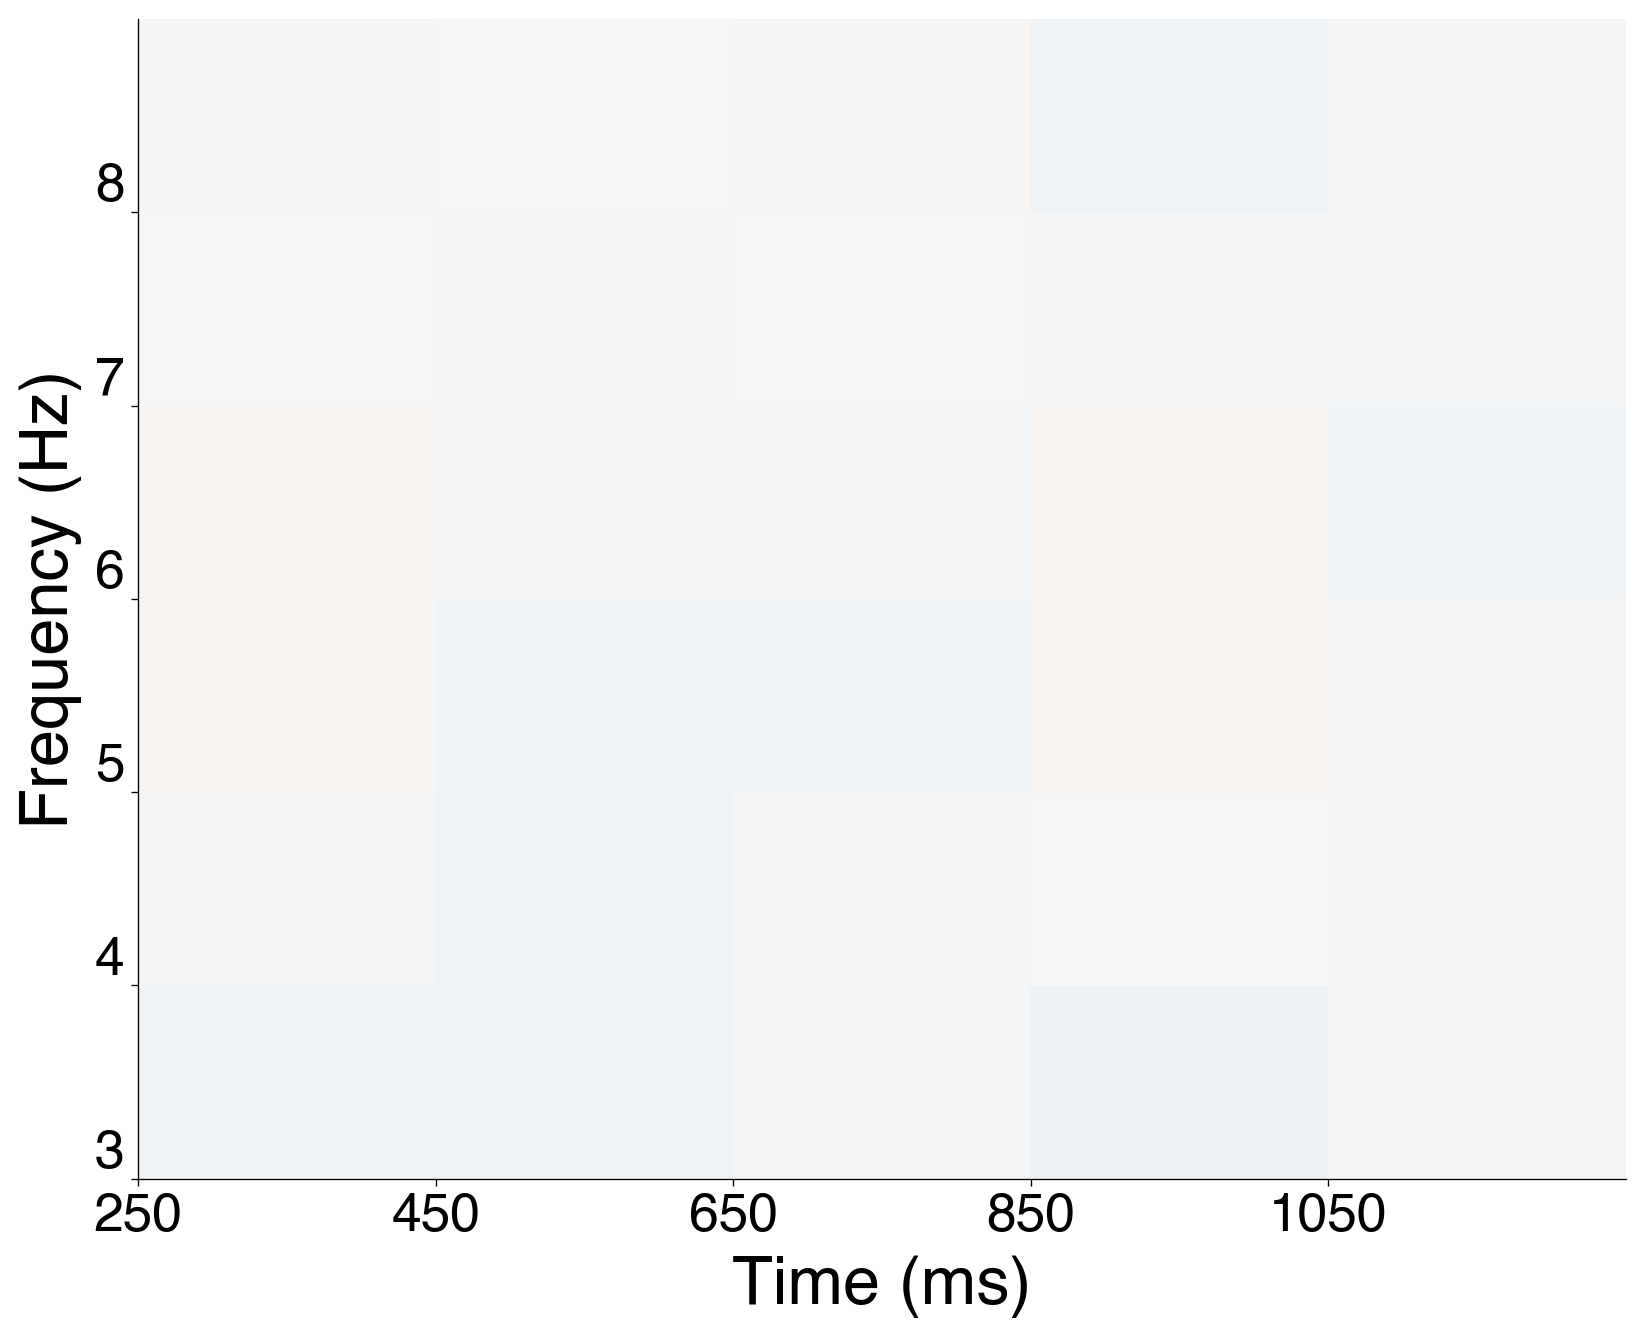

In [117]:
beh='en'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
# stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
# extent = im.get_extent()
# combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
# masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
# shape = mx_plot.shape
# linewidth = 10
# color = 'yellow'
# line_kwargs={"linewidth":4, "color":'k'}

# color='gold'
# for cell in masked_cells:
#     i, j = cell
#     if (i, j-1) not in masked_cells:
#         ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i, j+1) not in masked_cells:
#         ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i+1, j) not in masked_cells:
#         ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
#     if (i-1, j) not in masked_cells:
#         ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

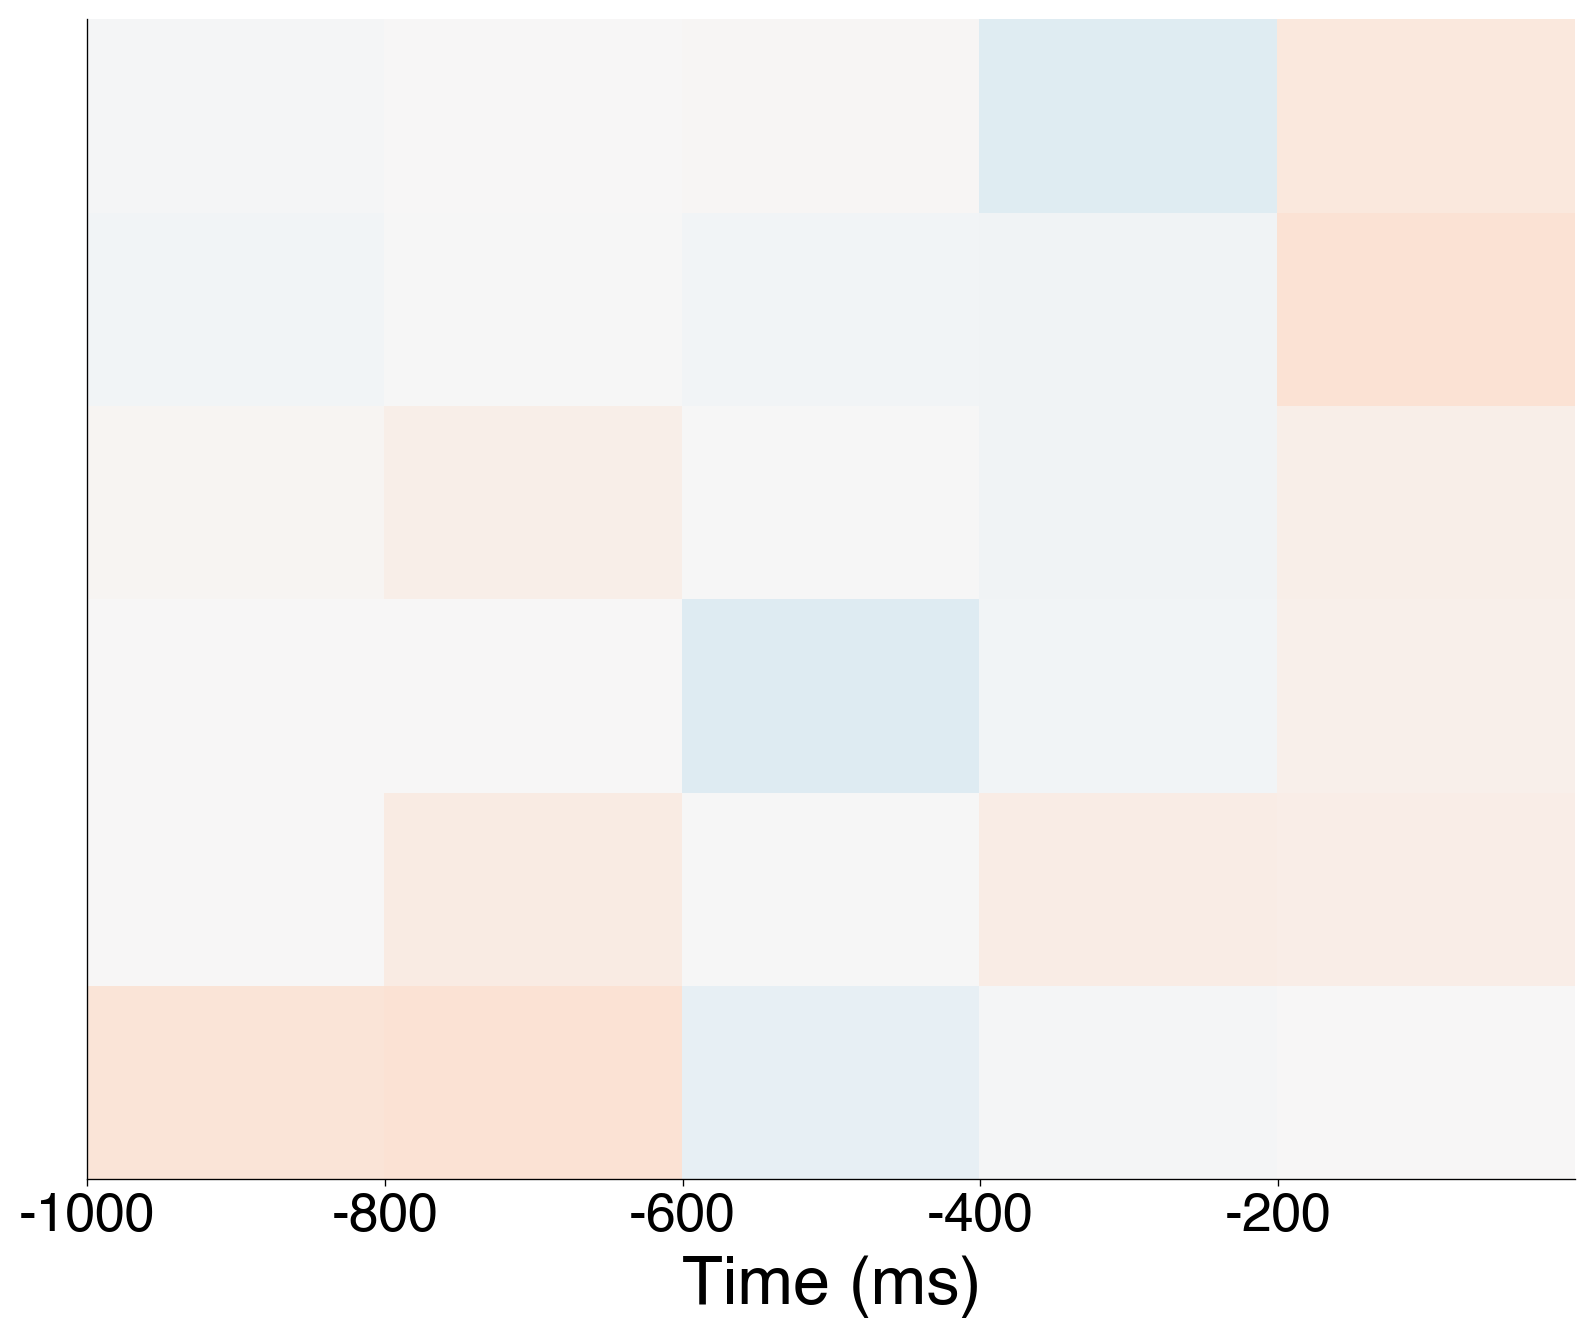

In [118]:
beh='rm'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
# stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
# extent = im.get_extent()
# combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
# masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
# shape = mx_plot.shape
# linewidth = 10
# color = 'yellow'
# line_kwargs={"linewidth":4, "color":'k'}

# color='gold'
# for cell in masked_cells:
#     i, j = cell
#     if (i, j-1) not in masked_cells:
#         ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i, j+1) not in masked_cells:
#         ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i+1, j) not in masked_cells:
#         ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
#     if (i-1, j) not in masked_cells:
#         ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

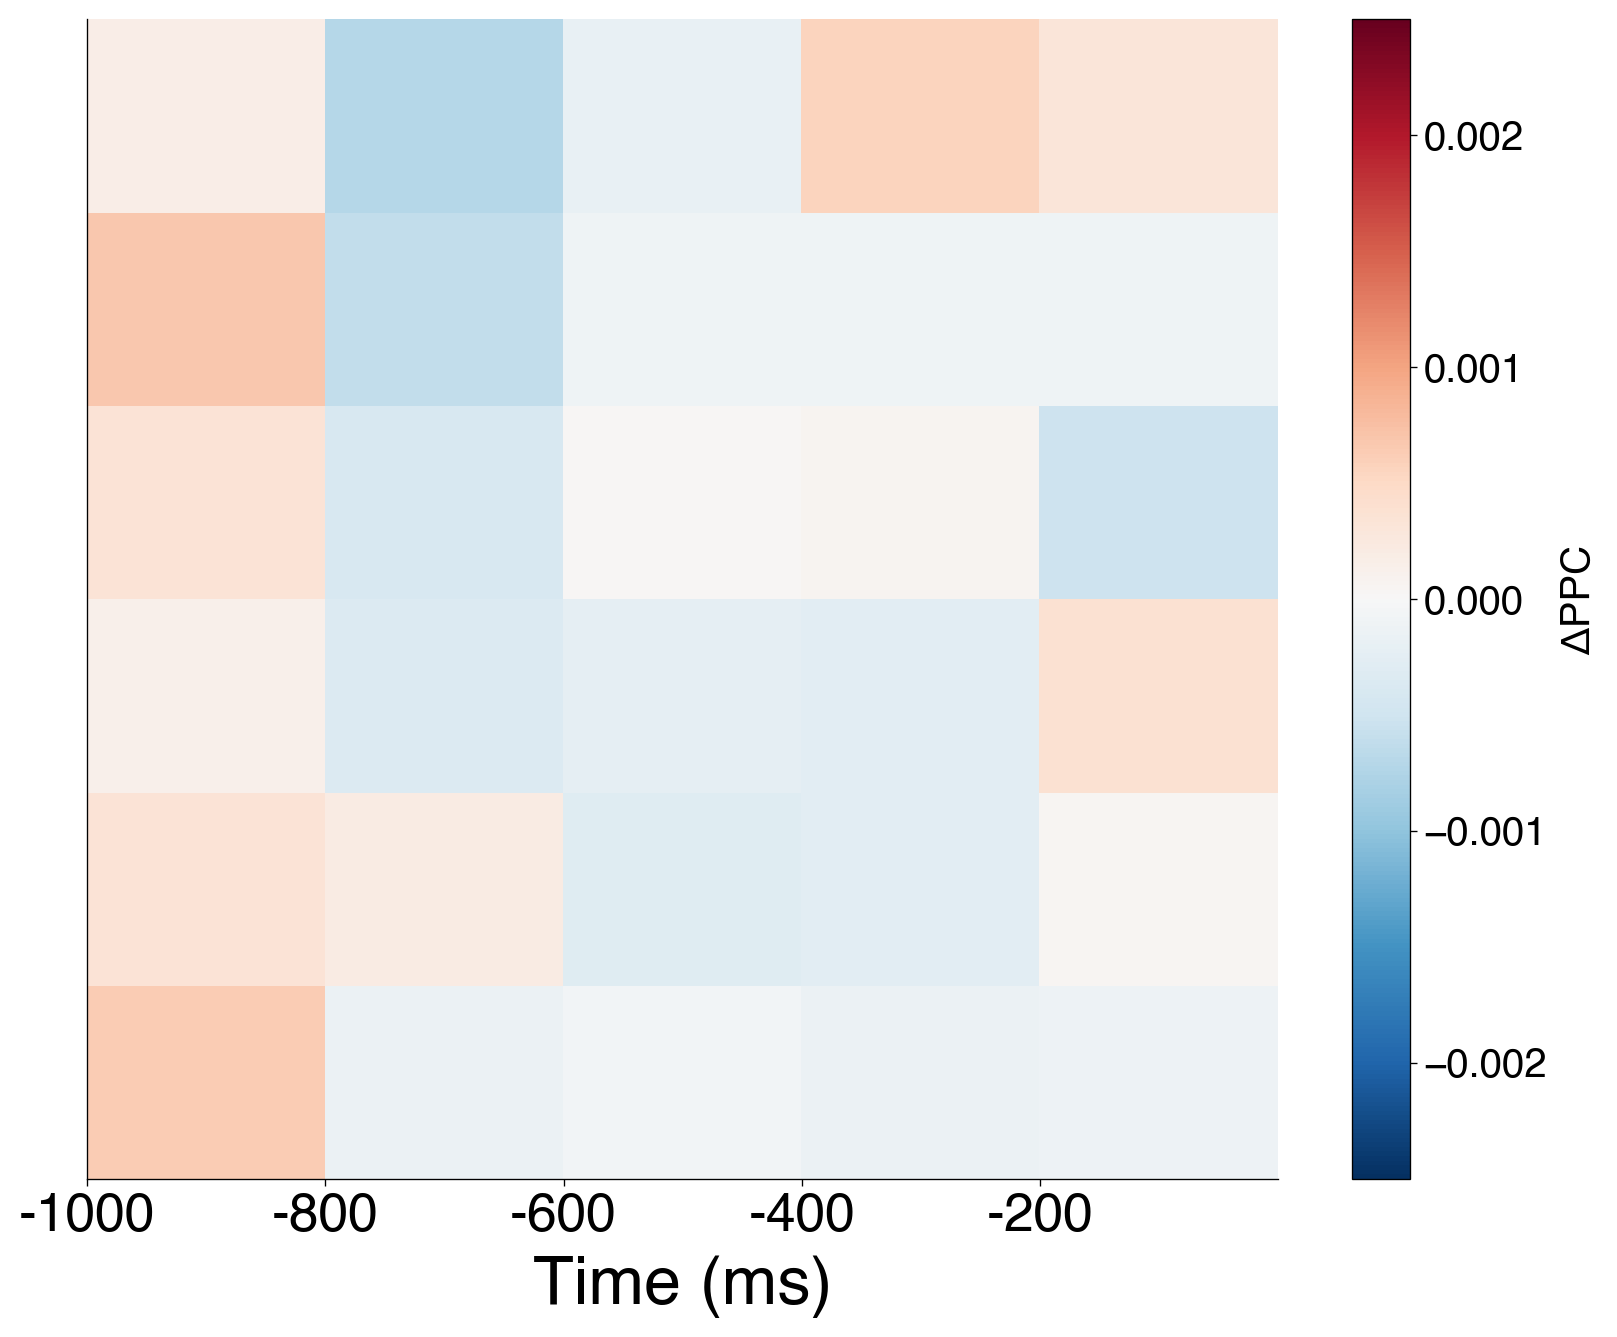

In [119]:
beh='ri'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
# stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
# extent = im.get_extent()
# combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
# masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
# shape = mx_plot.shape
# linewidth = 10
# color = 'yellow'
# line_kwargs={"linewidth":4, "color":'k'}

# color='gold'
# for cell in masked_cells:
#     i, j = cell
#     if (i, j-1) not in masked_cells:
#         ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i, j+1) not in masked_cells:
#         ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
#     if (i+1, j) not in masked_cells:
#         ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
#     if (i-1, j) not in masked_cells:
#         ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

# Difference in memory-evoked synchrony between 3 Hz and 8 Hz

In [120]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    print_ttest_1samp(mx.sel(freq=3).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = -1.76, p = 0.0792, Mean: -7.19e-05 ± 4.08e-05
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.877, p = 0.381, Mean: 8.98e-05 ± 0.000102
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.114, p = 0.91, Mean: 2.89e-05 ± 0.000254


In [121]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    print_ttest_1samp(mx.sel(freq=8).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = -0.406, p = 0.685, Mean: -1.05e-05 ± 2.58e-05
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_377 = -0.049, p = 0.961, Mean: -3.58e-06 ± 7.3e-05
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.131, p = 0.896, Mean: 2.29e-05 ± 0.000175


In [122]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    t, p = print_ttest_rel(mx.sel(freq=3).data, mx.sel(freq=8).data, beh)
    N = len(mx.sub)
    print(f'B_01: {jzs_bayes_factor(t, N)}')
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = -1.29, p = 0.198, Mean_A: -7.19e-05 ± 4.08e-05, Mean_B: -1.05e-05 ± 2.58e-05, Mean_Diff: -6.14e-05 ± 4.77e-05
B_01: 10.69128814516529
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.7, p = 0.484, Mean_A: 8.98e-05 ± 0.000102, Mean_B: -3.58e-06 ± 7.3e-05, Mean_Diff: 9.33e-05 ± 0.000133
B_01: 19.137166643908152
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.0209, p = 0.983, Mean_A: 2.89e-05 ± 0.000254, Mean_B: 2.29e-05 ± 0.000175, Mean_Diff: 5.98e-06 ± 0.000286
B_01: 16.2886947856851


## Figure 4A

In [123]:
fig4_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    for freq in [3, 8]:
        fig4_df = pd.concat([fig4_df, pd.DataFrame({'beh': beh,
                                                    'freq': freq,
                                                    'data': mx.sel(freq=freq).data})],
                            ignore_index=True,
                            axis=0)
fig4_df = fig4_df.replace({'en': 'Encoding',
                           'rm': 'Retrieval',
                           'ri': 'Recall Accuracy',
                            3: '3 Hz',
                            8: '8 Hz'})
fig4_df.to_json(join(root_dir, 'fig4_df.json'))

Text(0, 0.5, 'ΔPPC')

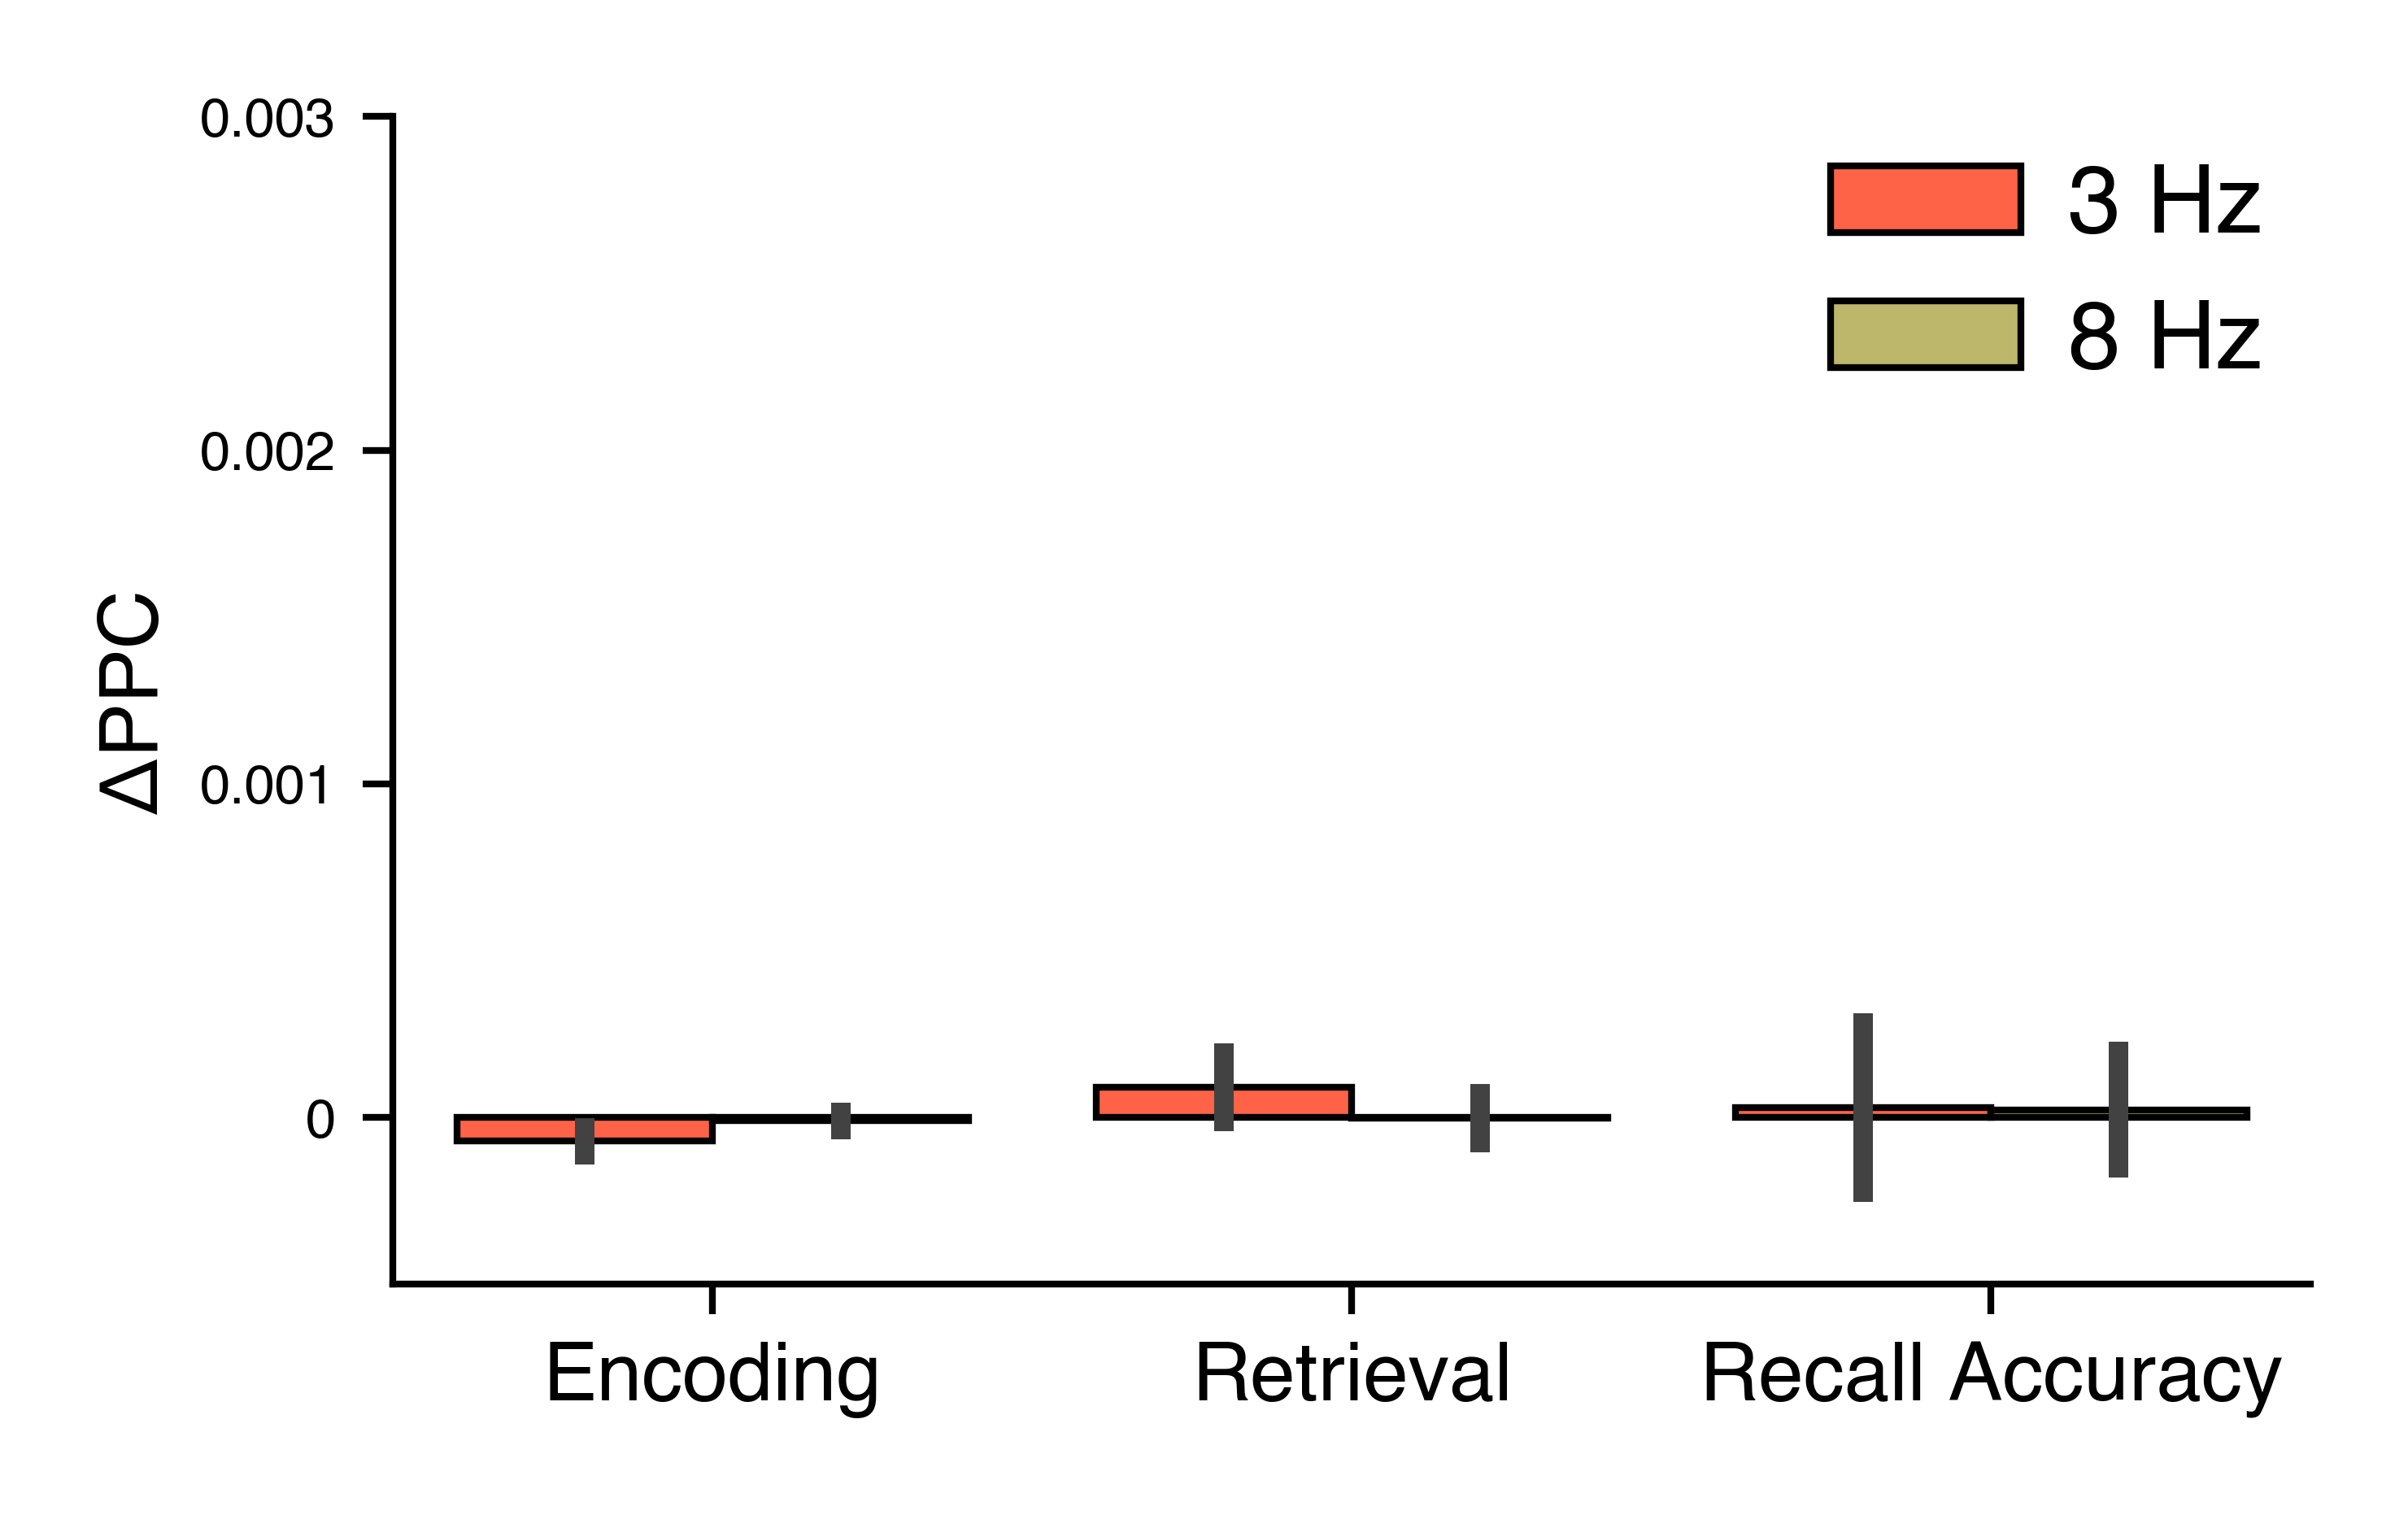

In [124]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0005
ymax = 0.003
yticks = [0, .001, .002, .003]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                 palette=['tomato', 'darkkhaki'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


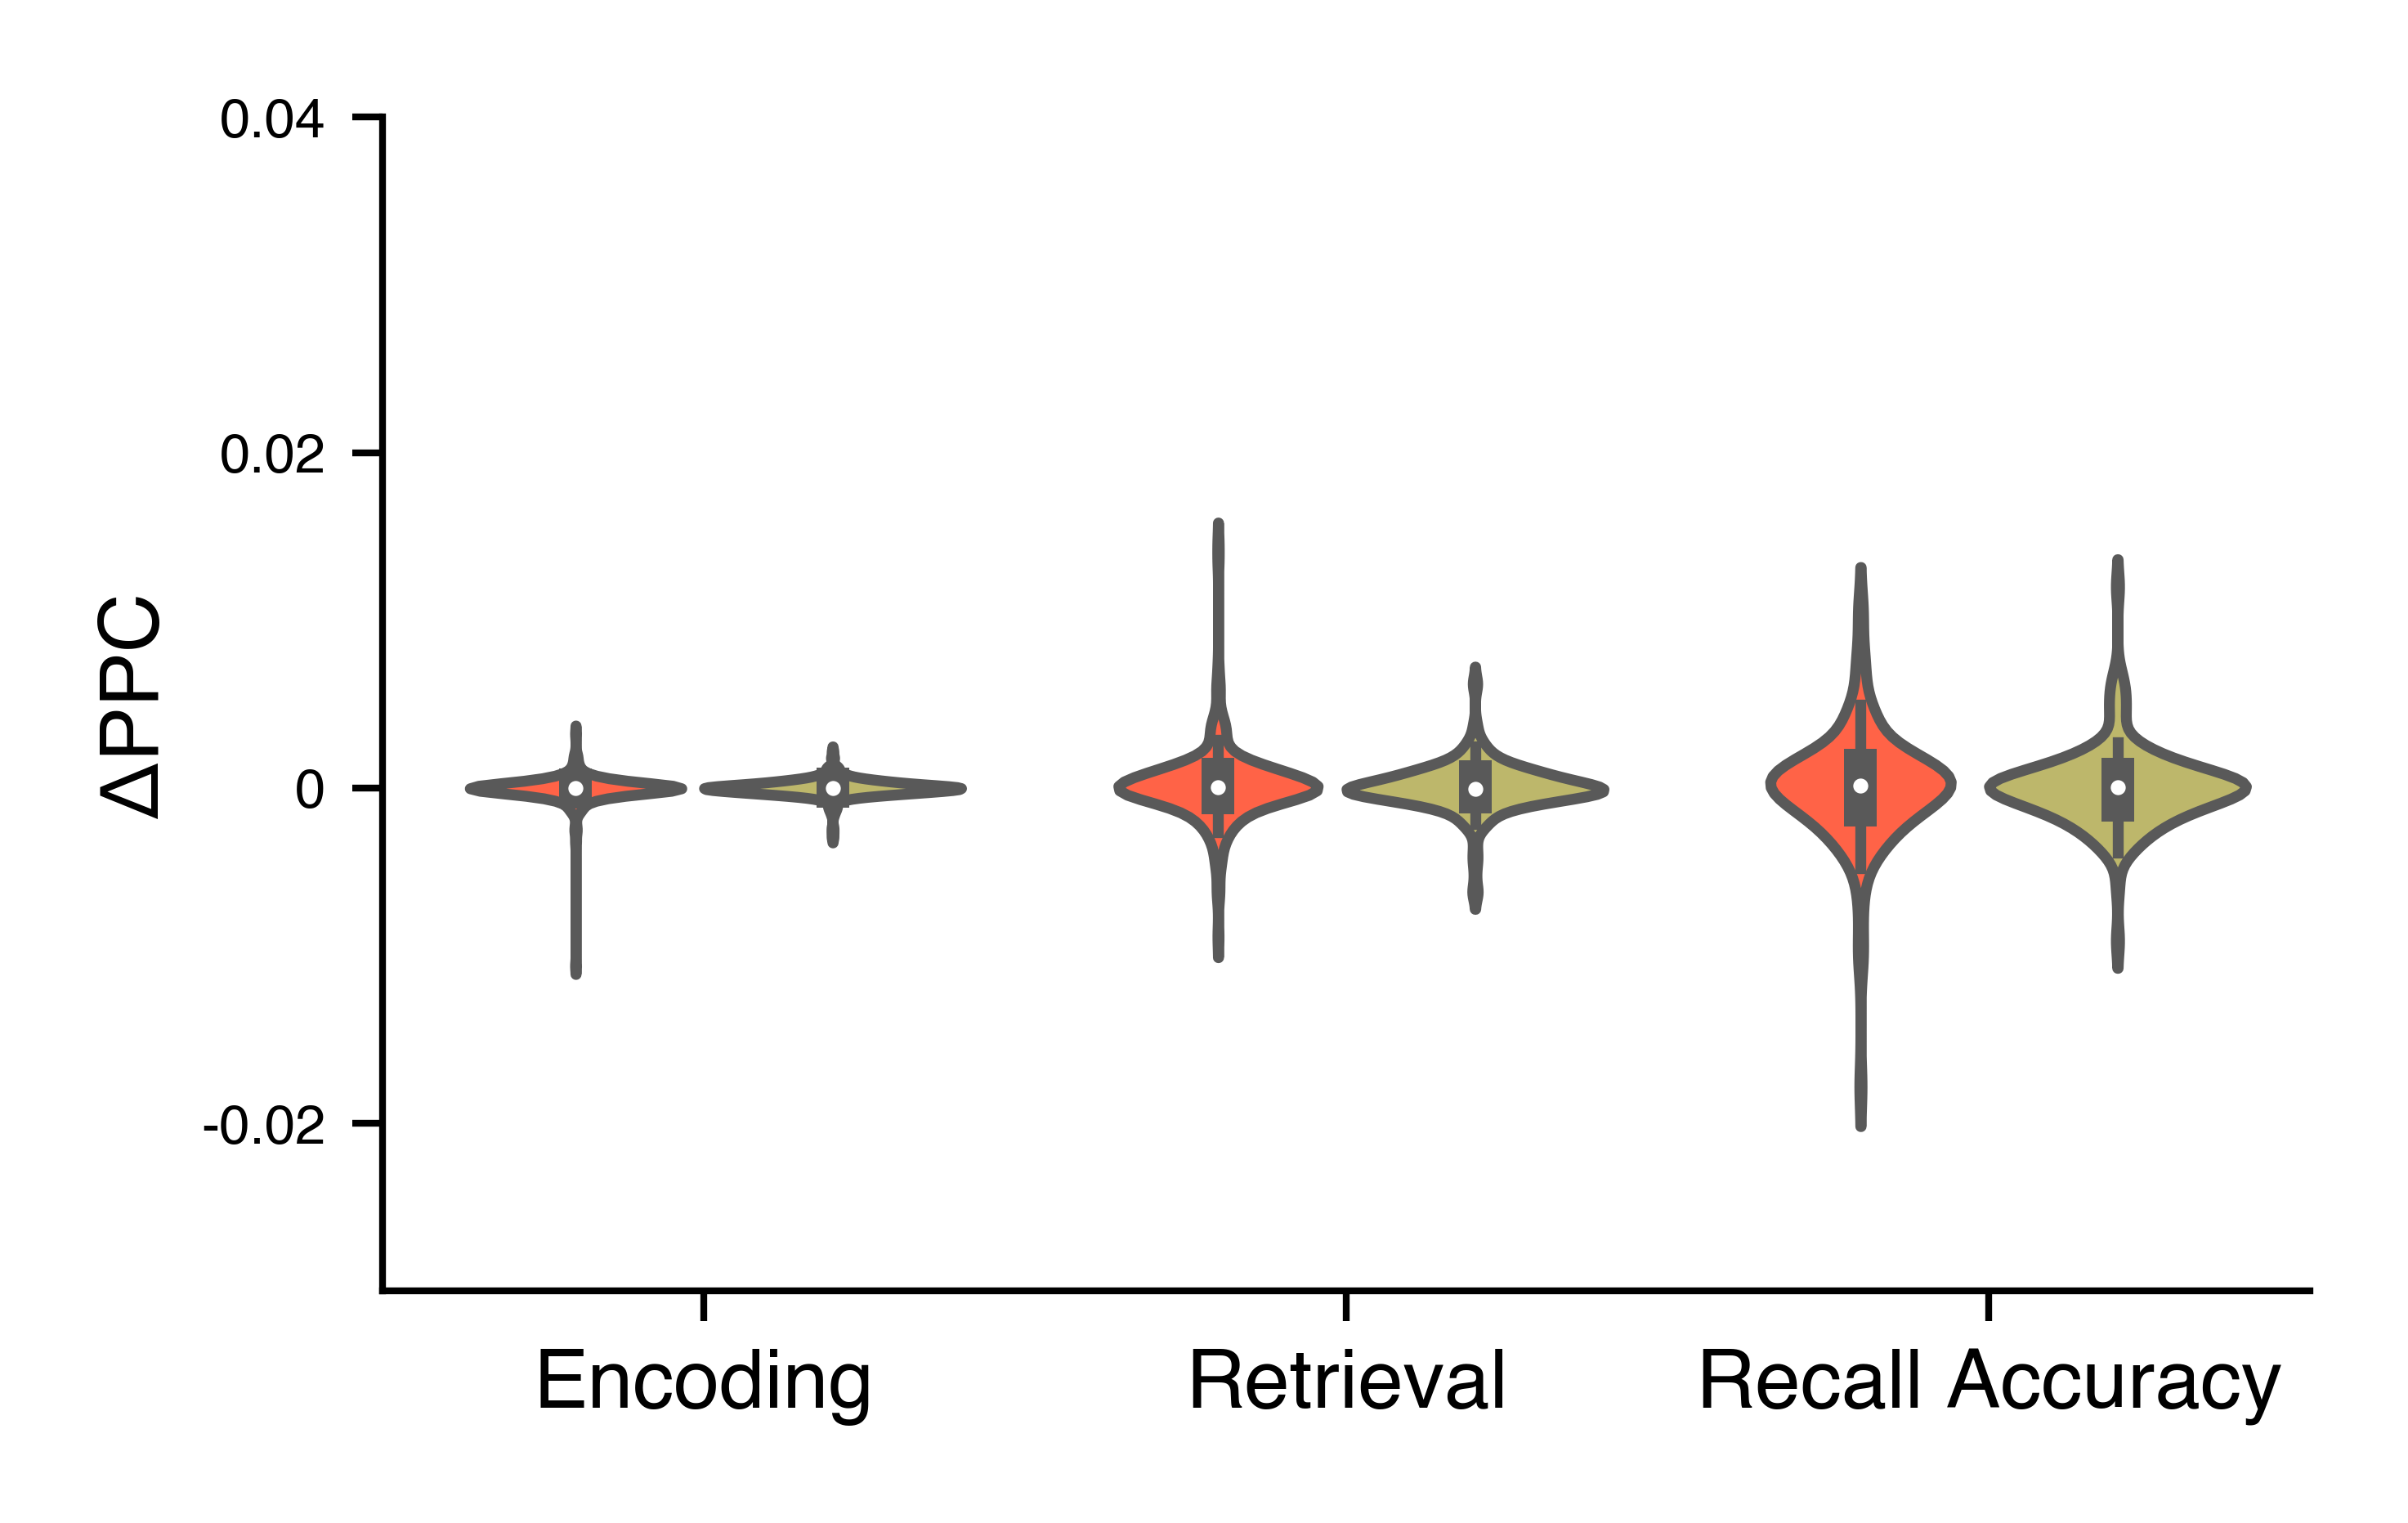

In [125]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.03
ymax = 0.04
yticks = [-0.02, 0, 0.02, 0.04]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['tomato', 'darkkhaki'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Encoding–retrieval correlation

In [126]:
import shutil
split_dir_path = join(root_dir, 'rm_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)
split_dir_path = join(root_dir, 'ri_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)

In [127]:
split_dir_path = join(root_dir, 'rm_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [128]:
def run_split_rm_events(dfrow):
    import helper
    helper.root_dir = root_dir
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    rm_events = load_events(dfrow, 'rm')    
    pair_count = len(rm_events)//2
    rm_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = rm_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = rm_events.query('pair_idx in @first_group_idxs')
    second_group = rm_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'rm_split', 'a', 'events', f'{ftag(dfrow)}_rm_events_split_a.json'))
    second_group.to_json(join(root_dir, 'rm_split', 'b', 'events', f'{ftag(dfrow)}_rm_events_split_b.json'))
        

In [129]:
def run_pipeline_rm_split(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'rm_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_rm_events_split_{split_idx}.json')
        if not ex(events_path): run_split_rm_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'rm'
        events.attrs['mask'] = (events['type'] == 'REC_WORD').values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): continue
        run_pipeline(dfrow, 'rm', events, save_dir, simulation_tag=simulation_tag)

In [130]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [131]:
client = cl('run_pipeline_rm_split', '30G', int(2000/10), walltime=100000) 
futures = client.map(run_pipeline_rm_split, sess_list)
wait(futures, client, check_delay=30)

Simulations finished after 1.55e+03 s: 980 / 980 (0.631 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [132]:
split_dir_path = join(root_dir, 'ri_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [133]:
def run_split_ri_events(dfrow):
    import helper
    helper.root_dir = root_dir
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    ri_events = load_events(dfrow, 'ri')    
    pair_count = len(ri_events)//2
    ri_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = ri_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = ri_events.query('pair_idx in @first_group_idxs')
    second_group = ri_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'ri_split', 'a', 'events', f'{ftag(dfrow)}_ri_events_split_a.json'))
    second_group.to_json(join(root_dir, 'ri_split', 'b', 'events', f'{ftag(dfrow)}_ri_events_split_b.json'))
        

In [134]:
def run_pipeline_ri_split(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'ri_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_ri_events_split_{split_idx}.json')
        if not ex(events_path): run_split_ri_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'ri'
        events.attrs['mask'] = (events['correct'] == 1).values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): continue
        run_pipeline(dfrow, 'ri', events, save_dir, simulation_tag=simulation_tag)

In [135]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [136]:
client2 = cl('run_pipeline_ri_split', '30G', int(2000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_ri_split, sess_list_ri)
wait(futures2, client2, check_delay=30)

Simulations finished after 7.33e+02 s: 317 / 317 (0.432 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [137]:
client.shutdown()
client2.shutdown()

In [138]:
get_ex(futures, sess_list)

In [139]:
get_ex(futures2, sess_list_ri)

In [140]:
def apply_spearman_brown_correction(r): return (2*r)/(1+r)

def compute_intercontrast_correlations(beh1, beh2):
    
    if ('ri' in beh1) or ('ri' in beh2): sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    
    sub_list = sess_list_df['sub'].unique()
    
    sub_corrs = []
    
    for iSub, sub in enumerate(sub_list):
        
        sess_corrs = []
        
        for iSess, rSess in sess_list_df.query('sub == @sub').iterrows():
            
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            beh1_mx = npl(join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
            beh2_mx = npl(join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
    
            beh1_mx = beh1_mx[..., 0] - beh1_mx[..., 1]
            beh2_mx = beh2_mx[..., 0] - beh2_mx[..., 1]
            
            beh1_mx = np.nanmean(np.nanmean(np.nanmean(beh1_mx, axis=-1), axis=-1), axis=-1)
            beh2_mx = np.nanmean(np.nanmean(np.nanmean(beh2_mx, axis=-1), axis=-1), axis=-1)
            
            r = scipy.stats.pearsonr(beh1_mx, beh2_mx)[0]
            if (beh1, beh2) in [('rm_split/a', 'rm_split/b'), ('rm_split/a', 'rm_split/b')]: 
                r = apply_spearman_brown_correction(r)

            sess_corrs.append(r)
            
        sub_corrs.append(np.mean(sess_corrs))
        
    return np.asarray(sub_corrs)
        

In [141]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x2af27a743210>>, <Task finished coro=<Cluster._sync_cluster_info() done, defined at /usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://192.168.86.145:40621 after 30 s')>)
Traceback (most recent call last):
  File "/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/distributed/comm/core.py", line 286, in connect
    timeout=min(intermediate_cap, time_left()),
  File "/usr/global/miniconda/py310_23.1.0-1/envs/

---------en / rm correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = -1.25, p = 0.213, Mean: -0.00495 ± 0.00397


(-1.2462748378587596, 0.2134373599561918)

In [142]:
rm_split_sub_corrs = compute_intercontrast_correlations('rm_split/a', 'rm_split/b')
print_ttest_1samp(rm_split_sub_corrs, header='rm split-half correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------rm split-half correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = -1.66, p = 0.0971, Mean: -0.0114 ± 0.00684


(-1.663066482122726, 0.09713018638851441)

In [143]:
en_ri_sub_corrs = compute_intercontrast_correlations('en', 'ri')
print_ttest_1samp(en_ri_sub_corrs, header='en / ri correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / ri correlation---------
Statistically Significant (p < 0.05)
t_166 = -2.79, p = 0.00582, Mean: -0.0174 ± 0.00622


(-2.7937469055974993, 0.005823125854608372)

In [144]:
ri_split_sub_corrs = compute_intercontrast_correlations('ri_split/a', 'ri_split/b')
print_ttest_1samp(ri_split_sub_corrs, header='ri split-half correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------ri split-half correlation---------
Statistically Significant (p < 0.05)
t_166 = -2.01, p = 0.0458, Mean: -0.0142 ± 0.00708


(-2.0124764474651933, 0.04578644505974205)

In [145]:
en_rm_t, en_rm_p = print_ttest_rel(en_rm_sub_corrs, rm_split_sub_corrs)

NOT Statistically Significant (p >= 0.05)
t_377 = 0.81, p = 0.419, Mean_A: -0.00495 ± 0.00397, Mean_B: -0.0114 ± 0.00684, Mean_Diff: 0.00642 ± 0.00793


In [146]:
en_ri_t, en_ri_p = print_ttest_rel(en_ri_sub_corrs, ri_split_sub_corrs)

NOT Statistically Significant (p >= 0.05)
t_166 = -0.318, p = 0.751, Mean_A: -0.0174 ± 0.00622, Mean_B: -0.0142 ± 0.00708, Mean_Diff: -0.00313 ± 0.00985


In [147]:
jzs_bayes_factor(t = en_rm_t, N = 378)

17.620194067180897

In [148]:
jzs_bayes_factor(t = en_ri_t, N = 167)

15.49347697504183

## Figure 5

In [149]:
fig5_df = pd.DataFrame([], columns=['beh', 'type', 'data'])
for name, correlation_type, behs in zip(['Encoding / Retrieval', 'Encoding / Retrieval', 'Encoding / Recall Accuracy', 'Encoding / Recall Accuracy'],
                                        ['Observed', 'Benchmark', 'Observed', 'Benchmark'],
                                        [('en', 'rm'), ('rm_split/a', 'rm_split/b'), ('en', 'ri'), ('ri_split/a', 'ri_split/b')]):
    
    rs = compute_intercontrast_correlations(*behs)
    fig5_df = pd.concat([fig5_df, pd.DataFrame({'name': name,
                                                'correlation_type': correlation_type,
                                                'data': rs})],
                         axis=0)

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


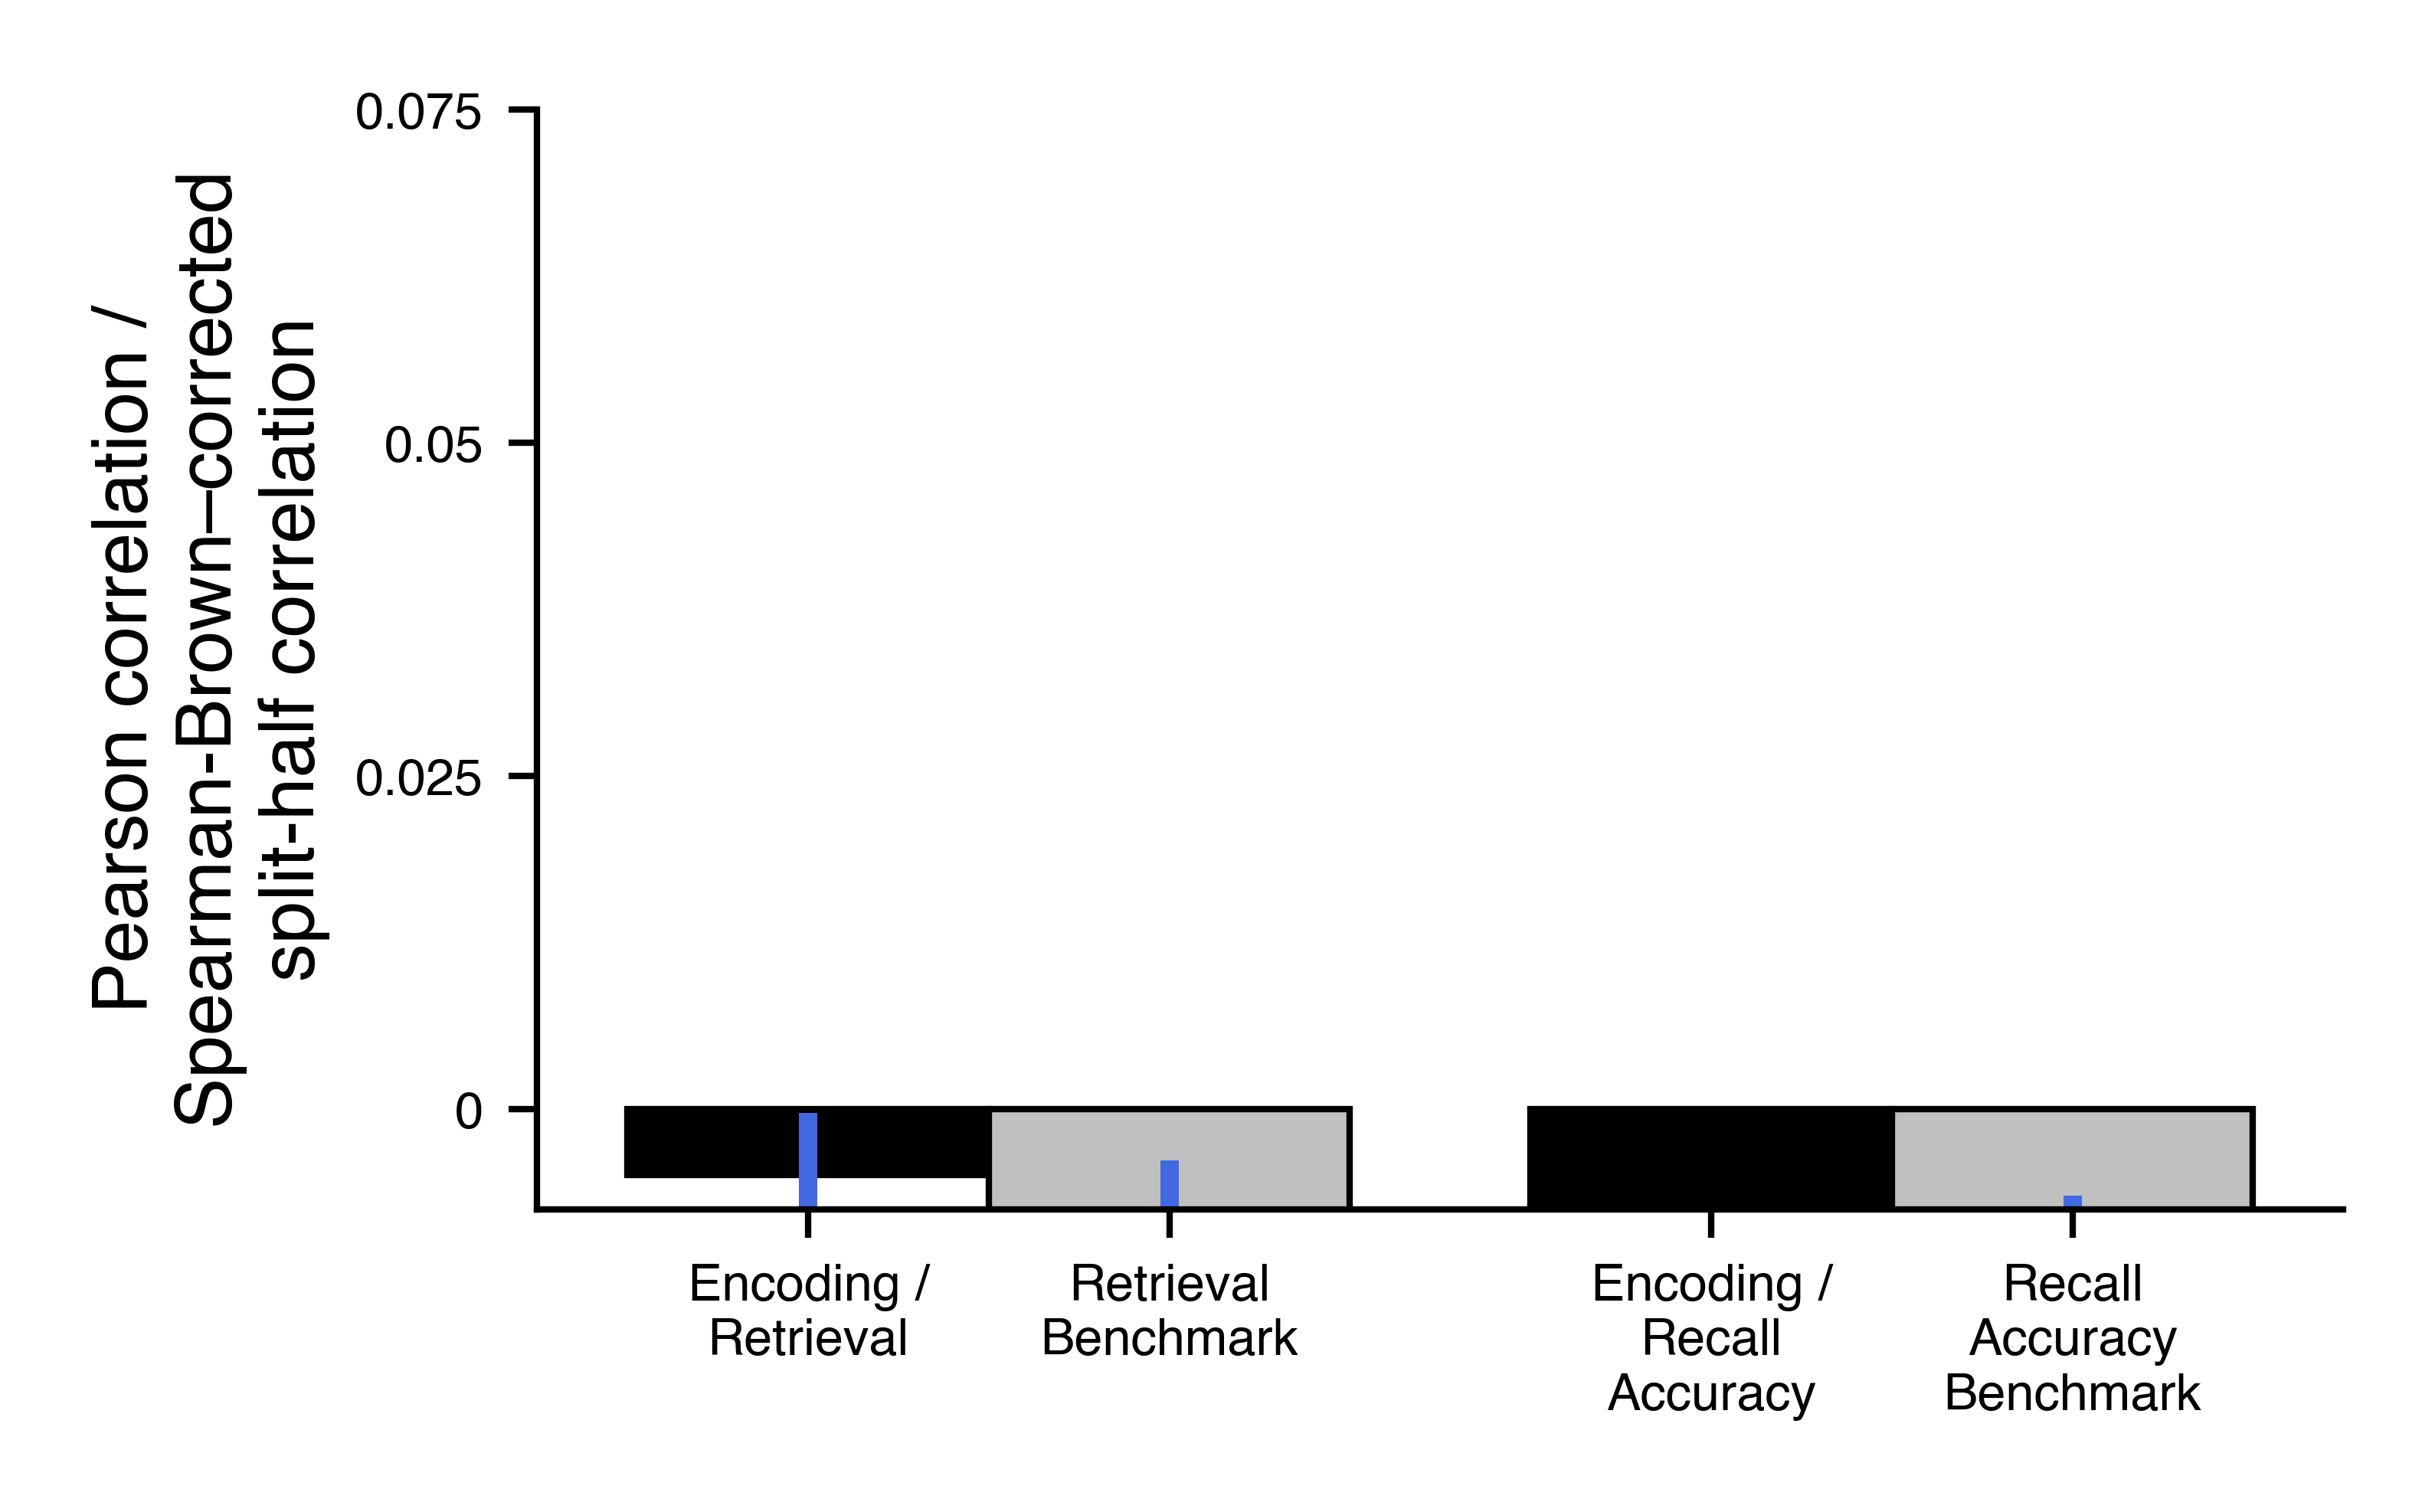

In [150]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *
import textwrap

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0075
ymax = 0.075
yticks = [0, 0.025, 0.05, 0.075]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='name', y='data', hue='correlation_type', data=fig5_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k', errcolor='royalblue',
                 palette=['black', 'silver'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
labels = ['Encoding / Retrieval', 'Retrieval Benchmark', 'Encoding / Recall Accuracy', 'Recall Accuracy Benchmark']
labels = [textwrap.fill(label, width=10, break_long_words=True) for label in labels]
_ax.set_xticklabels(labels, fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('Pearson correlation /\n Spearman-Brown–corrected\n split-half correlation', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Power–synchrony correlation

Here we compute the within-subject correlation between the theta synchrony effect of memory and the theta or gamma power memory effect. The correlation is performed across electrode contacts between the mean brain-wide memory-evoked synchrony values and the memory-evoked power values, after averaging over frequencies and epochs. We then perform a 1-sample t-test against population mean zero to test the statistical significance of the correlation.

In [151]:
def compute_power_synchrony_correlations(beh, freq):
    
    # assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
    
    if beh == 'ri': sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    sess_list_df = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    sess_list_df['correlation'] = np.nan
    
    def compute_power_synchrony_correlation(r):
        
        dfrow = get_dfrow(r.name)
        freq_band = 'gamma' if freq == 'gamma' else 'theta'
        symx_fname = join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        pomx_fname = join(root_dir, beh, 'elpomxs', freq_band, f'{ftag(dfrow)}_elpomxd.npy')
        
        symx = npl(symx_fname)
        pomx = npl(pomx_fname)
        
        symx = symx[...,0] - symx[...,1]
        if freq in ['theta', 'gamma']:
            symx = np.nanmean(np.nanmean(np.nanmean(symx, axis=-1), axis=-1), axis=-1)
            pomx = np.nanmean(np.nanmean(pomx, axis=-1), axis=-1)
        else:
            symx = symx[:, :, (freq-3), :]
            pomx = pomx[:, (freq-3), :]
            symx = np.nanmean(np.nanmean(symx, axis=-1), axis=-1)
            pomx = np.nanmean(pomx, axis=-1)
        
        where_finite = np.isfinite(symx) & np.isfinite(pomx)
        symx = symx[where_finite]
        pomx = pomx[where_finite]

        return scipy.stats.pearsonr(symx, pomx)[0]
    
    sess_list_df['correlation'] = sess_list_df.apply(lambda r: compute_power_synchrony_correlation(r), axis=1)
    
    return sess_list_df.groupby('sub')['correlation'].mean().values
    

In [152]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------en theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.46, p = 0.144, Mean: 0.00599 ± 0.00409


(1.4626130165938138, 0.14440642837019957)

In [153]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------rm theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.65, p = 0.0996, Mean: 0.00706 ± 0.00428


(1.6506741504806839, 0.09963789786936726)

In [154]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------ri theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.57, p = 0.118, Mean: 0.0119 ± 0.00758


(1.5727688082434381, 0.11767639624539993)

In [155]:
for beh in ['en', 'rm', 'ri']:
    rs_38 = []
    for freq in [3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        print_ttest_1samp(rs, header=f'{beh} {freq} power / synchrony correlation')
        rs_38.append(rs)
    rs_38 = np.subtract(rs_38[0], rs_38[1])
    print_ttest_1samp(rs_38, header='diff')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


---------en 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.52, p = 0.13, Mean: 0.00737 ± 0.00486
---------en 8 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 2.41, p = 0.0164, Mean: 0.0105 ± 0.00436
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_377 = -0.53, p = 0.596, Mean: -0.00315 ± 0.00593
---------rm 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.81, p = 0.0712, Mean: 0.0076 ± 0.0042
---------rm 8 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.08, p = 0.28, Mean: 0.00473 ± 0.00437
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.499, p = 0.618, Mean: 0.00287 ± 0.00576
---------ri 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.21, p = 0.227, Mean: 0.00847 ± 0.00698
---------ri 8 power / synchrony correlation---------
Stat

In [156]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------en theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.46, p = 0.144, Mean: 0.00599 ± 0.00409


(1.4626130165938138, 0.14440642837019957)

In [157]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------rm theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.65, p = 0.0996, Mean: 0.00706 ± 0.00428


(1.6506741504806839, 0.09963789786936726)

In [158]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------ri theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.57, p = 0.118, Mean: 0.0119 ± 0.00758


(1.5727688082434381, 0.11767639624539993)

In [159]:
rs = compute_power_synchrony_correlations('en', 'gamma')
print_ttest_1samp(rs, header='en gamma power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------en gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.64, p = 0.102, Mean: 0.00665 ± 0.00405


(1.641289715814258, 0.10157122000179952)

In [160]:
rs = compute_power_synchrony_correlations('rm', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.74, p = 0.082, Mean: 0.00669 ± 0.00384


(1.7435790756316036, 0.08204767151743489)

In [161]:
rs = compute_power_synchrony_correlations('ri', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = -1.28, p = 0.202, Mean: -0.00909 ± 0.00709


(-1.2819959395981753, 0.20163163415363633)

## Figure 6

In [162]:
fig6_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    for freq in ['theta', 3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        fig6_df = pd.concat([fig6_df, pd.DataFrame({'beh': beh,
                                                    'freq': f'{freq} Hz' if freq in [3, 8] else 'theta avg.',
                                                    'data': rs})],
                             axis=0)
fig6_df.replace({'en': 'Encoding', 'rm': 'Retrieval', 'ri': 'Recall Accuracy'}, inplace=True)

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


Text(0, 0.5, "Pearson\\'s \\textit{r}")

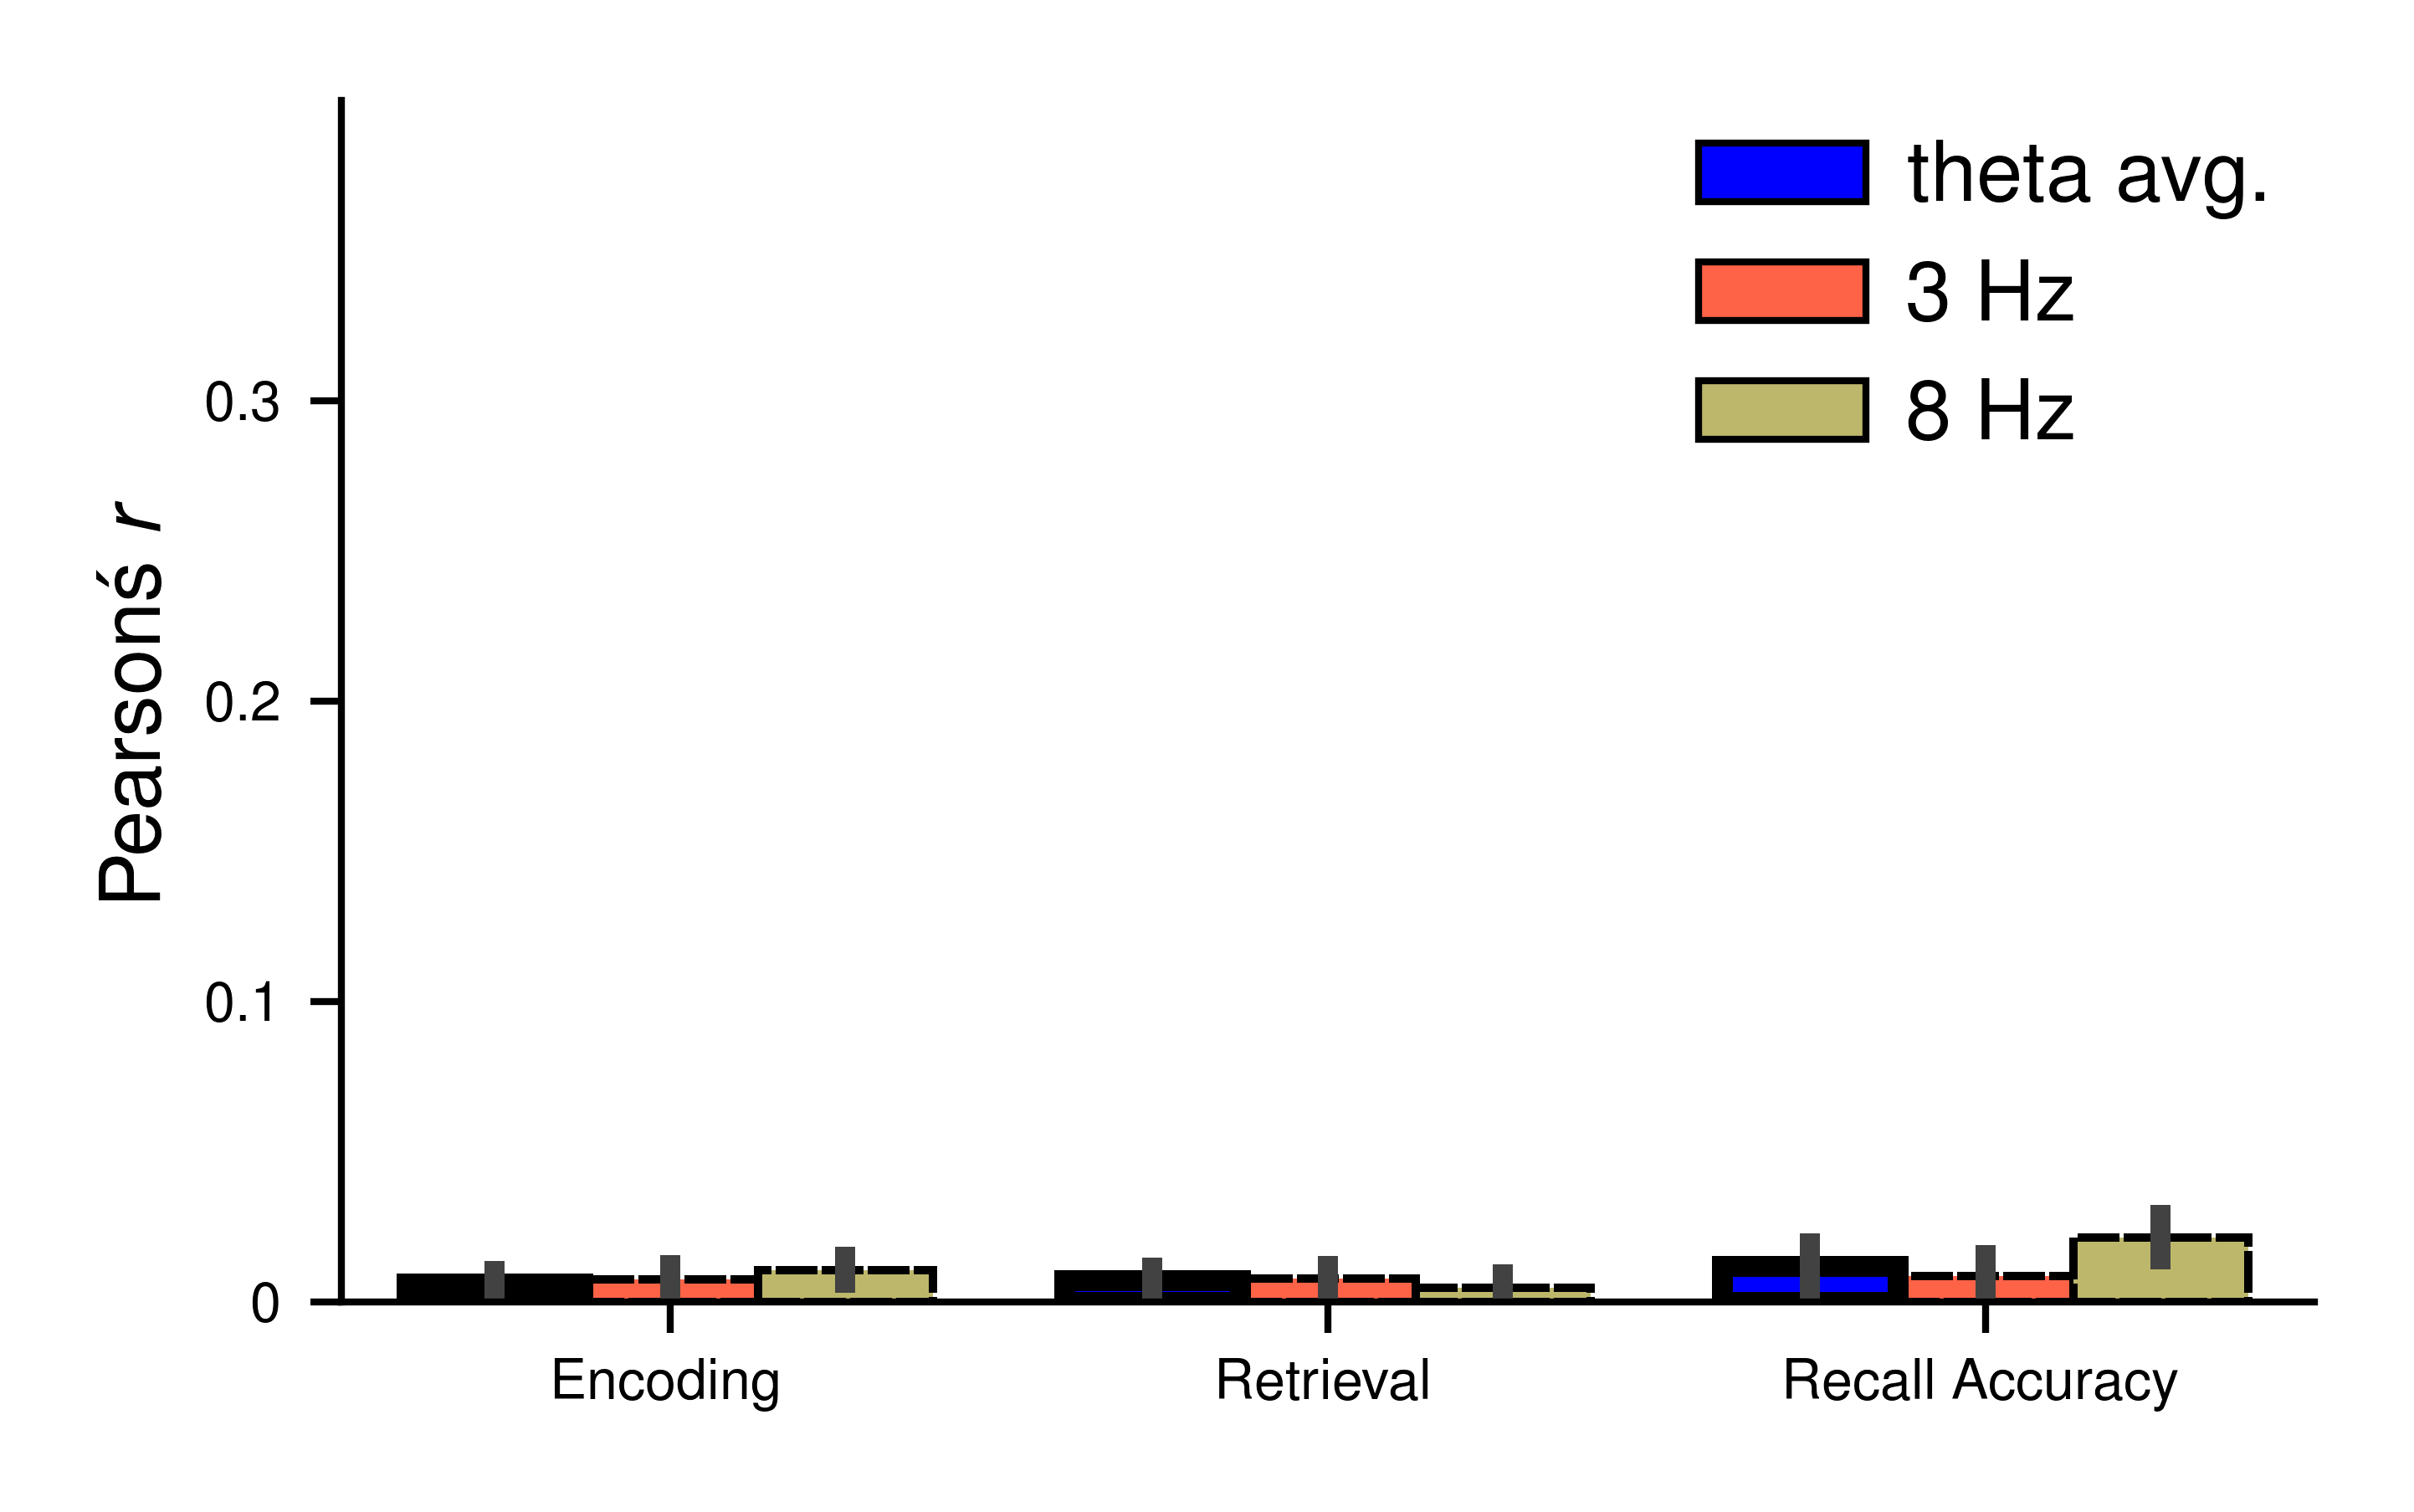

In [163]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=True)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.4
yticks = [0, 0.1, 0.2, 0.3]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
_ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
for i in np.arange(3):
    _ax.containers[0].patches[i].set(zorder=2, edgecolor='black', linewidth=1.5)
    for j in [1, 2]:
        _ax.containers[j].patches[i].set(linestyle=(0, (5, 0.5)), linewidth=0.6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


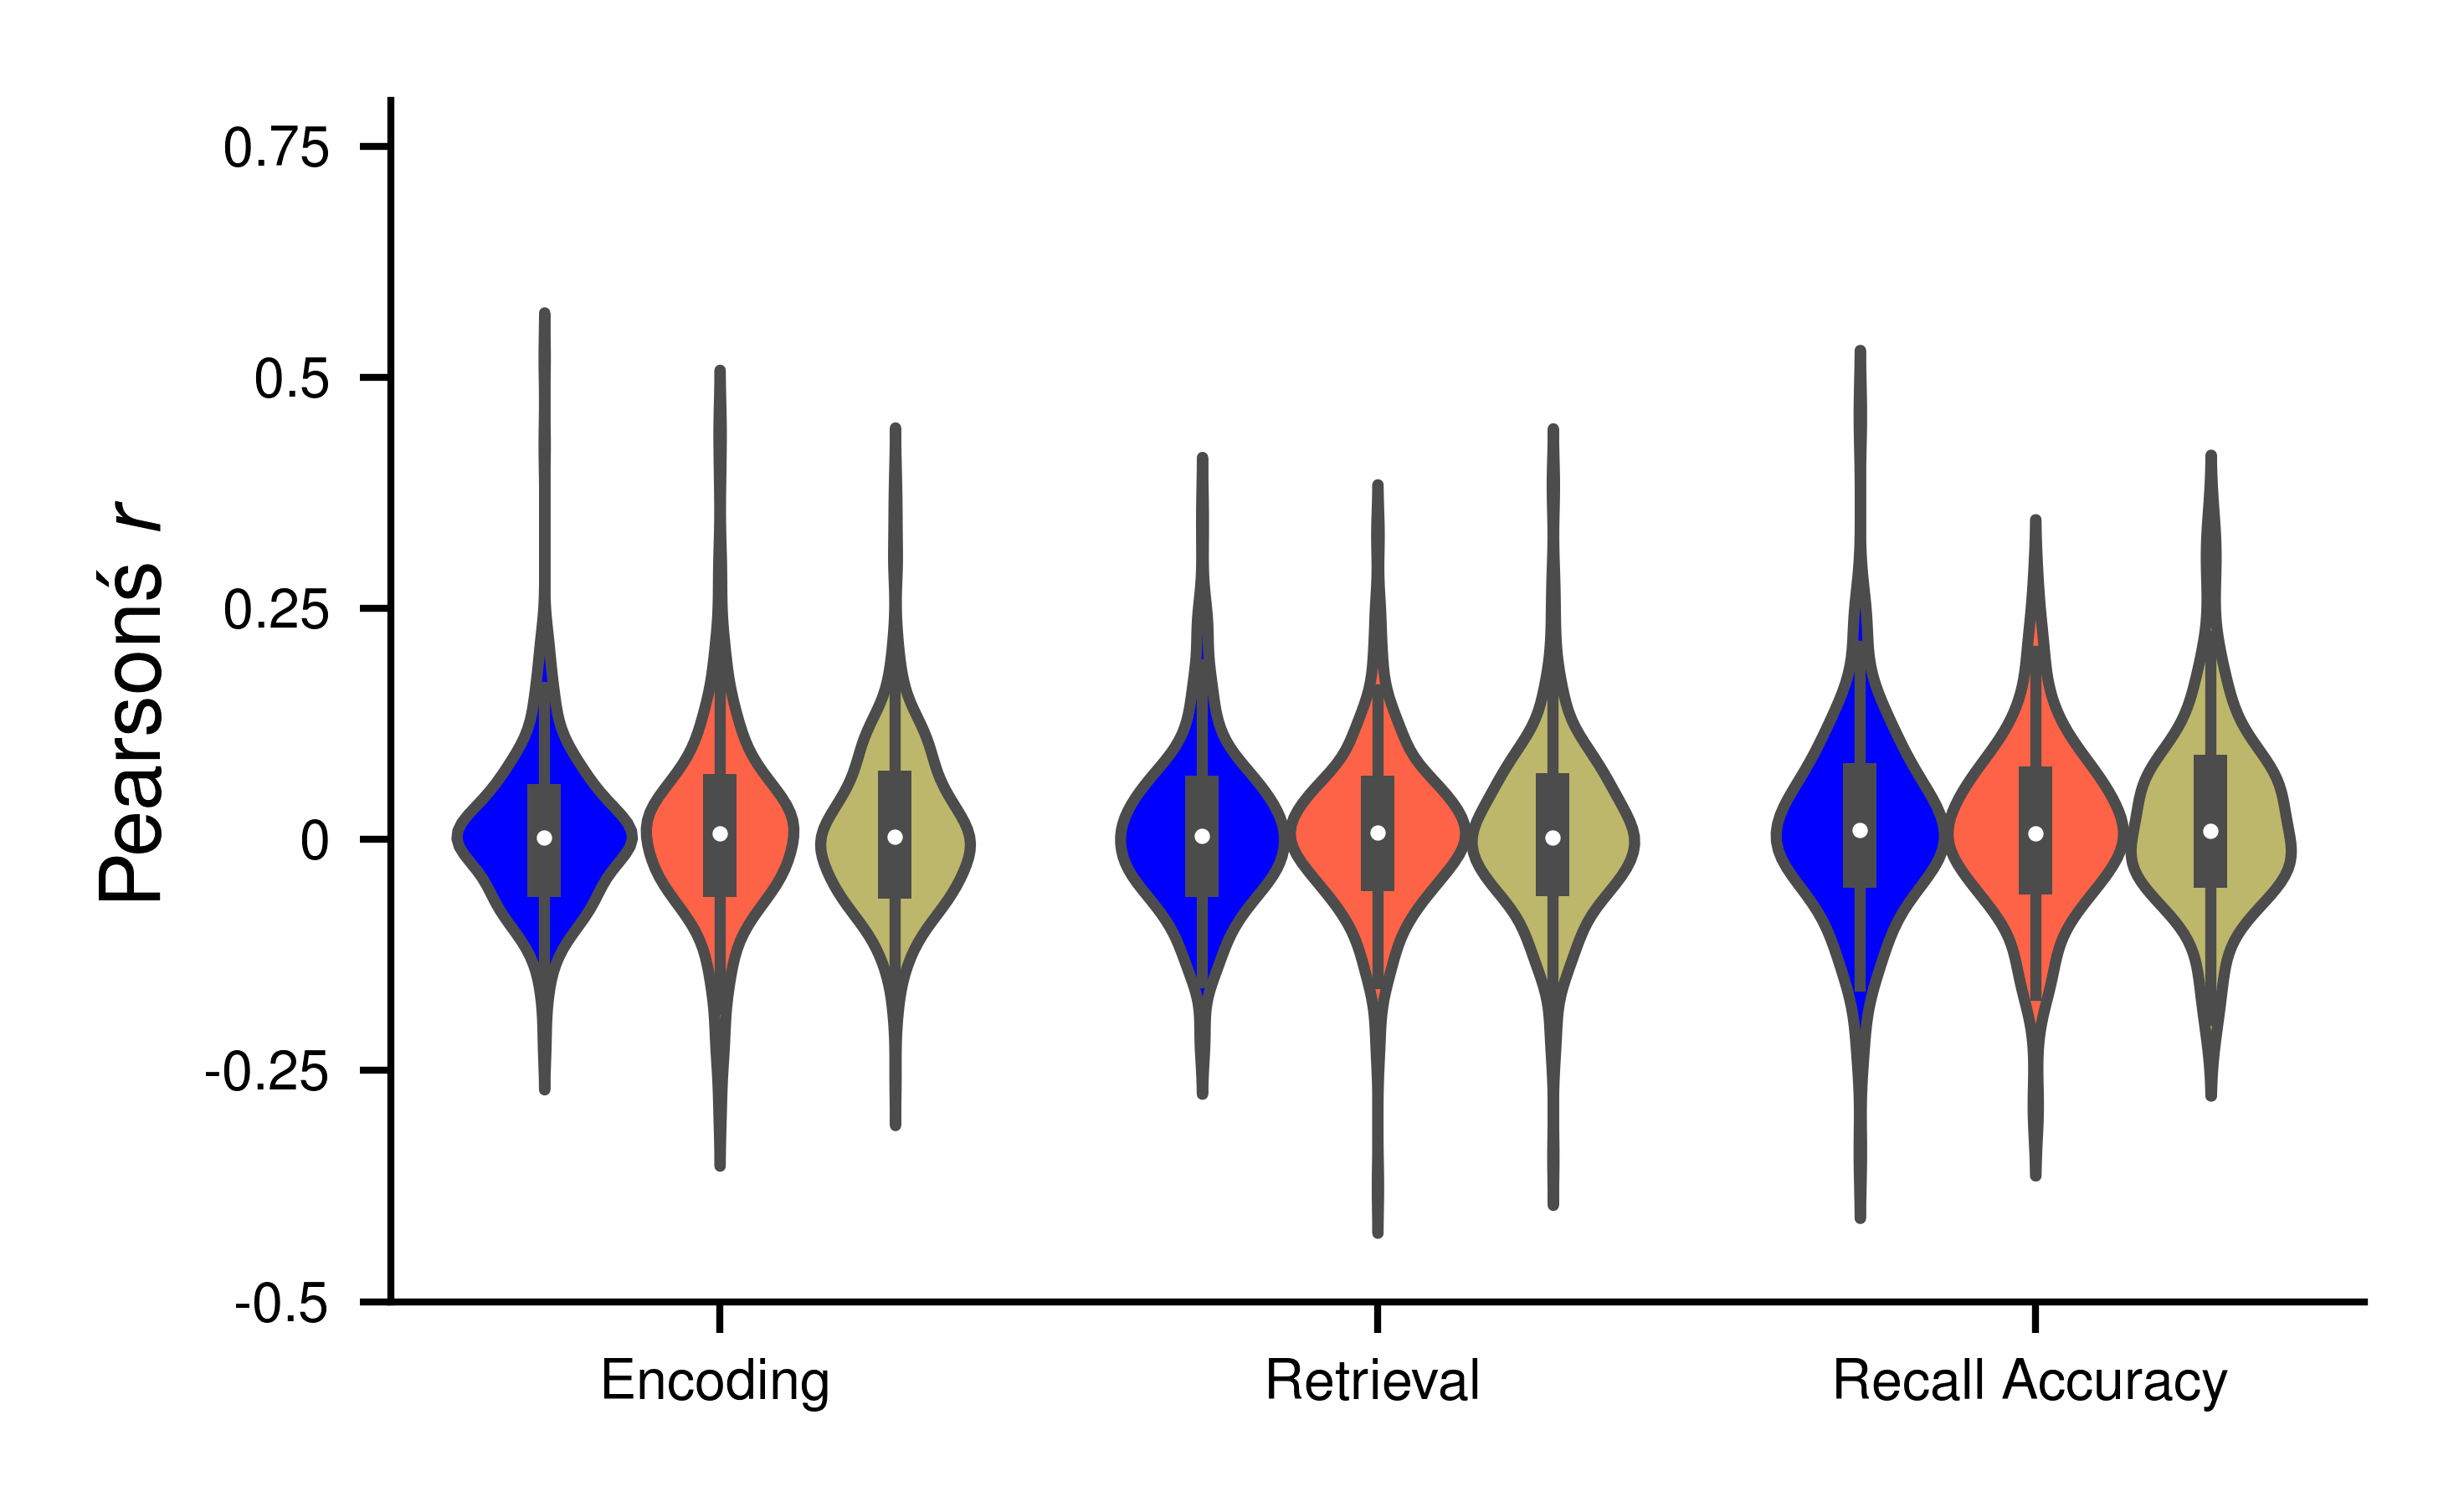

In [164]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=True)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.5
ymax = 0.8
yticks = [-0.5, -0.25, 0, 0.25, 0.5, 0.75]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
# _ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()
